# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk

In [4]:
import networkx as nx

# Setting

In [5]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [6]:
setting = Setting()

# Dataset

## Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

### Load all data

In [7]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between
    
    
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

### Split Data

In [8]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)
            
split_data(path=setting.data_split, x=synthetic, y=between)

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [10]:
def to_data(x, y):
    edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    ### between centrality
    bcs = []
    bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
    bc = bc.t().contiguous()
    row, col = bc
    bc = col
    bc = bc.numpy()
    bcs = torch.from_numpy(
            np.array([[b] for b in bc], dtype=np.float))

    data = Data(x=vertice, edge_index=edge_index, y=bcs)
    
    return data

#### Read data

In [11]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

#### Cvt

In [12]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

#### Use all data

In [13]:
all_loader = to_dataloader(synthetic, between, batch=1)

#### Use YT data

In [14]:
# yt_loader = to_dataloader(yt, yt_score, batch=1)

# Model

## Hyper params

In [15]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

# setting.params_node2vec = dict(
#     edge_index, 
#     embedding_dim, 
#     walk_length = 10, 
#     context_size,
#     p = 1,
#     q = 2
# )

## DrBC

In [16]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [42]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [43]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [44]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [45]:
from torch_geometric.nn import Node2Vec

In [46]:
class BC_node2vec(nn.Module):
    
    def __init__(self, node2vec_params):
        super().__init__()
        
        self.node2vec = Node2Vec(**node2vec_params)
        self.mlp = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, data):
        
        x = self.node2vec(data)
        x = self.mlp(x)
        
        return x

# Load model

In [47]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(setting.device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

# Evaluation

### Top k %

In [48]:
def top_n(model, data, k):

    with torch.no_grad():

        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]
        k = int(nodes * k / 100)

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().to(setting.device)
        bc_pr = bc_pr.squeeze()

        gt_value, gt_indice = torch.topk(bc_gt, k)
        pr_value, pr_indice = torch.topk(bc_pr, k)

        gt_indice = set(gt_indice.cpu().numpy())
        pr_indice = set(pr_indice.cpu().numpy())

        intersect = len(gt_indice & pr_indice)
        top = intersect/k
            
       

        return top

### Tau Kendal

In [49]:
from scipy import stats

def tau_distance(model, data):
    
    
    with torch.no_grad():
 
        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().cpu().numpy()
        bc_pr = bc_pr.squeeze().cpu().numpy()


        tau, p_value = stats.kendalltau(bc_gt, bc_pr)
       

    return tau

### Evaluation Mode

In [50]:
def eval_model(model, data):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item()

In [55]:
def from_networkx(G, between_list):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    data['y'] = torch.from_numpy(
        np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

# Train

In [58]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

use a new optimizer


In [59]:
nodes_cnt = 200


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = list(betweenness.values())
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    

    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    bc_gt = pyg_data.y
#     bc_gt = np.array(bc_gt)
#     bc_gt = torch.from_numpy(bc_gt)
    bc_gt = torch.reshape(bc_gt, (-1, ))

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation:- Train
    top1 = top_n(model, pyg_data, k=1)
    top5 = top_n(model, pyg_data, k=5)
    top10 = top_n(model, pyg_data, k=10)
    kendal = tau_distance(model, pyg_data)

    print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            loss.item(),
            top1,
            top5,
            top10,
            kendal
    ))

    train_info["bce"].append(loss.item())
    train_info["top1"].append(top1)
    train_info["top5"].append(top5)
    train_info["top10"].append(top10)
    train_info["kendal"].append(kendal)

    with open(setting.train_info_p, 'w') as f:
        json.dump(train_info, f)



    ### Evaluation:- Synthetic
    bce_l = []
    top1_l = []
    top5_l = []
    top10_l = []
    kendal_l = []

    for data in all_loader:
        bce_l.append(eval_model(model, data))
        top1_l.append(top_n(model, data, k=1))
        top5_l.append(top_n(model, data, k=5))
        top10_l.append(top_n(model, data, k=10))
        kendal_l.append(tau_distance(model, data))
        
    bce = sum(bce_l)/len(bce_l)
    top1 = sum(top1_l)/len(top1_l)
    top5 = sum(top5_l)/len(top5_l)
    top10 = sum(top10_l)/len(top10_l)
    kendal = sum(kendal_l)/len(kendal_l)
        
    print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
        bce,
        top1,
        top5,
        top10,
        kendal
    ))

    valid_info["bce"].append(bce)
    valid_info["top1"].append(top1)
    valid_info["top5"].append(top5)
    valid_info["top10"].append(top10)
    valid_info["kendal"].append(kendal)

    with open(setting.val_info_p, 'w') as f:
        json.dump(valid_info, f)
        
    
    if top10 > top_10:
        checkpoint = {
            'model_stat': model.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, setting.weight_drbc)
        top_10 = top10


Epoch: 1
Train: loss = 693.1531420272001, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0, kendal = -0.5618090452261306
Valid: loss = 17328.707089159845, top 1 = 0.0, top 5 = 0.0014666666666666671, top 10 = 0.006533333333333336, kendal = -0.4446918610388745

Epoch: 2
Train: loss = 693.1499410954619, top 1 = 0.0, top 5 = 0.0, top 10 = 0.1, kendal = -0.27909547738693463
Valid: loss = 17328.695772592975, top 1 = 0.0, top 5 = 0.0014666666666666671, top 10 = 0.006533333333333336, kendal = -0.4395440688137629

Epoch: 3
Train: loss = 693.1468303601068, top 1 = 0.0, top 5 = 0.9, top 10 = 0.9, kendal = -0.014170854271356783
Valid: loss = 17328.6862403012, top 1 = 0.0, top 5 = 0.0014666666666666671, top 10 = 0.006600000000000003, kendal = -0.35186958991798367

Epoch: 4
Train: loss = 693.1426166113039, top 1 = 0.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.22040201005025123
Valid: loss = 17328.679412900306, top 1 = 0.056666666666666685, top 5 = 0.2256, top 10 = 0.3075333333333333, kendal = -0.05937419483896

Valid: loss = 17329.082640033877, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.6311333333333332, kendal = 0.3738846702673868

Epoch: 34
Train: loss = 693.0980515467928, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.7939698492462312
Valid: loss = 17329.09653895004, top 1 = 0.6639999999999999, top 5 = 0.6341333333333333, top 10 = 0.6311333333333332, kendal = 0.3747245982529838

Epoch: 35
Train: loss = 693.0827118523066, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.7750753768844221
Valid: loss = 17329.117841552437, top 1 = 0.6633333333333333, top 5 = 0.6338666666666667, top 10 = 0.6308666666666666, kendal = 0.37561562445822505

Epoch: 36
Train: loss = 693.096371470973, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8035175879396985
Valid: loss = 17329.138541971268, top 1 = 0.6653333333333332, top 5 = 0.6337333333333334, top 10 = 0.6308666666666667, kendal = 0.37650493298659726

Epoch: 37
Train: loss = 693.0902862496177, top 1 = 1.0, top 5 = 1.0, top

Valid: loss = 17329.45275805111, top 1 = 0.66, top 5 = 0.628, top 10 = 0.6267333333333333, kendal = 0.4109533053277322

Epoch: 67
Train: loss = 693.092798403397, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7925628140703518
Valid: loss = 17329.452756561797, top 1 = 0.6606666666666666, top 5 = 0.6277333333333334, top 10 = 0.6266666666666665, kendal = 0.41216063479362547

Epoch: 68
Train: loss = 693.0810232318878, top 1 = 1.0, top 5 = 0.9, top 10 = 0.8, kendal = 0.8261306532663316
Valid: loss = 17329.454870968573, top 1 = 0.66, top 5 = 0.6278666666666667, top 10 = 0.6267999999999997, kendal = 0.41352178702407144

Epoch: 69
Train: loss = 693.0886542658101, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.830753768844221
Valid: loss = 17329.45767612107, top 1 = 0.66, top 5 = 0.6278666666666667, top 10 = 0.6266666666666665, kendal = 0.41503626058545046

Epoch: 70
Train: loss = 693.0975407770042, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8208040201005025
Valid: loss = 17329

Valid: loss = 17329.695441682994, top 1 = 0.658, top 5 = 0.6250666666666668, top 10 = 0.6249333333333331, kendal = 0.4472684403547376

Epoch: 100
Train: loss = 693.0925464550223, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8157788944723617
Valid: loss = 17329.697701934496, top 1 = 0.6586666666666667, top 5 = 0.6250666666666668, top 10 = 0.6251333333333334, kendal = 0.44810850703474026

Epoch: 101
Train: loss = 693.0861409033773, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8146733668341708
Valid: loss = 17329.69455642348, top 1 = 0.6586666666666667, top 5 = 0.6249333333333333, top 10 = 0.6250666666666667, kendal = 0.44860080816163245

Epoch: 102
Train: loss = 693.0607311321756, top 1 = 0.5, top 5 = 0.9, top 10 = 0.9, kendal = 0.8015075376884422
Valid: loss = 17329.705768205902, top 1 = 0.6586666666666667, top 5 = 0.6249333333333333, top 10 = 0.6254666666666665, kendal = 0.44847838367673537

Epoch: 103
Train: loss = 693.0793326803882, top 1 = 1.0, top 5 = 0.9, top 10 = 0.

Valid: loss = 17329.941763652463, top 1 = 0.658, top 5 = 0.6217333333333334, top 10 = 0.6282666666666666, kendal = 0.44537928919117165

Epoch: 134
Train: loss = 693.0317207623522, top 1 = 1.0, top 5 = 0.9, top 10 = 0.85, kendal = 0.7565829145728642
Valid: loss = 17329.952223101616, top 1 = 0.658, top 5 = 0.6217333333333334, top 10 = 0.6283333333333334, kendal = 0.44532889511235574

Epoch: 135
Train: loss = 693.0738144964455, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7736683417085427
Valid: loss = 17329.9617434218, top 1 = 0.658, top 5 = 0.6217333333333334, top 10 = 0.6284000000000002, kendal = 0.44505202373808095

Epoch: 136
Train: loss = 693.0711427947092, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7624120603015075
Valid: loss = 17329.957841825362, top 1 = 0.658, top 5 = 0.6214666666666667, top 10 = 0.6285333333333333, kendal = 0.44484251516970075

Epoch: 137
Train: loss = 693.065071418878, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.731356783919598
Valid: lo

Valid: loss = 17330.27907208826, top 1 = 0.6553333333333333, top 5 = 0.6225333333333333, top 10 = 0.6304000000000001, kendal = 0.4400519677268787

Epoch: 167
Train: loss = 693.0770536837804, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.7643216080402009
Valid: loss = 17330.23329950716, top 1 = 0.6553333333333333, top 5 = 0.6226666666666667, top 10 = 0.6303333333333333, kendal = 0.4413900966860039

Epoch: 168
Train: loss = 693.0322474118489, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.7415075376884421
Valid: loss = 17330.212754738935, top 1 = 0.6553333333333333, top 5 = 0.6226666666666667, top 10 = 0.6305333333333334, kendal = 0.44236179502567186

Epoch: 169
Train: loss = 693.0841715463324, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8162814070351758
Valid: loss = 17330.19204958387, top 1 = 0.6553333333333333, top 5 = 0.6226666666666668, top 10 = 0.6306666666666667, kendal = 0.4428746922717877

Epoch: 170
Train: loss = 693.0656500037354, top 1 = 1.0, top 5 = 0.9, top

Valid: loss = 17330.367223565823, top 1 = 0.656, top 5 = 0.6265333333333334, top 10 = 0.634, kendal = 0.43151209975328403

Epoch: 201
Train: loss = 693.0675553919623, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8314572864321607
Valid: loss = 17330.411885386635, top 1 = 0.6566666666666667, top 5 = 0.6265333333333333, top 10 = 0.634, kendal = 0.4288835847169433

Epoch: 202
Train: loss = 693.0444477015, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8056281407035176
Valid: loss = 17330.453785640035, top 1 = 0.6573333333333334, top 5 = 0.6270666666666667, top 10 = 0.6340666666666667, kendal = 0.42695203040608115

Epoch: 203
Train: loss = 693.0721712447942, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8105527638190955
Valid: loss = 17330.458751286635, top 1 = 0.6573333333333334, top 5 = 0.6272, top 10 = 0.6341333333333332, kendal = 0.4255654597586185

Epoch: 204
Train: loss = 693.070028416722, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.7786934673366834
Valid: loss 

Train: loss = 693.0603243623734, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.84
Valid: loss = 17330.59110468429, top 1 = 0.6573333333333334, top 5 = 0.6285333333333335, top 10 = 0.6342666666666668, kendal = 0.41787280656131226

Epoch: 235
Train: loss = 693.0293852878317, top 1 = 1.0, top 5 = 0.9, top 10 = 0.8, kendal = 0.8114572864321608
Valid: loss = 17330.600376086073, top 1 = 0.6573333333333334, top 5 = 0.6285333333333335, top 10 = 0.6343333333333334, kendal = 0.4180122157764886

Epoch: 236
Train: loss = 693.0628924764319, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8305527638190954
Valid: loss = 17330.589620319566, top 1 = 0.6573333333333334, top 5 = 0.6285333333333335, top 10 = 0.6344666666666666, kendal = 0.4190491004867641

Epoch: 237
Train: loss = 693.0279770818966, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.7888442211055275
Valid: loss = 17330.55997733172, top 1 = 0.6573333333333334, top 5 = 0.6280000000000001, top 10 = 0.6344666666666666, kendal = 0.420

Train: loss = 693.0797356886529, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.840502512562814
Valid: loss = 17330.810684018295, top 1 = 0.658, top 5 = 0.6301333333333333, top 10 = 0.6350666666666666, kendal = 0.4040329772621191

Epoch: 267
Train: loss = 693.0741307272692, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8510552763819095
Valid: loss = 17330.901964330158, top 1 = 0.658, top 5 = 0.6306666666666667, top 10 = 0.6352666666666666, kendal = 0.4051006414616258

Epoch: 268
Train: loss = 693.046916460228, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8265326633165828
Valid: loss = 17330.951478962055, top 1 = 0.658, top 5 = 0.6309333333333333, top 10 = 0.6355999999999999, kendal = 0.40717386677335465

Epoch: 269
Train: loss = 693.0667147830858, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8197989949748743
Valid: loss = 17330.93219100663, top 1 = 0.658, top 5 = 0.6309333333333333, top 10 = 0.6356666666666667, kendal = 0.4105086190571448

Epoch: 270
Train: loss

Train: loss = 693.070283170238, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.801608040201005
Valid: loss = 17330.842598723, top 1 = 0.658, top 5 = 0.6316, top 10 = 0.6361333333333332, kendal = 0.4087735360405414

Epoch: 300
Train: loss = 693.0176103774077, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7798994974874371
Valid: loss = 17330.841085003052, top 1 = 0.658, top 5 = 0.6317333333333334, top 10 = 0.6366666666666667, kendal = 0.41051789557911583

Epoch: 301
Train: loss = 693.0550675512702, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7915577889447235
Valid: loss = 17330.908365969062, top 1 = 0.658, top 5 = 0.6317333333333334, top 10 = 0.6370666666666668, kendal = 0.4119842208441689

Epoch: 302
Train: loss = 693.0482691083839, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.7676381909547738
Valid: loss = 17330.977539556025, top 1 = 0.6573333333333334, top 5 = 0.632, top 10 = 0.6370666666666668, kendal = 0.41307272121090893

Epoch: 303
Train: loss = 693.042222

Valid: loss = 17331.222321528705, top 1 = 0.6566666666666666, top 5 = 0.632, top 10 = 0.6377333333333334, kendal = 0.41711084083483374

Epoch: 332
Train: loss = 693.065478315845, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.7827135678391959
Valid: loss = 17331.22906453231, top 1 = 0.6566666666666666, top 5 = 0.632, top 10 = 0.6375333333333334, kendal = 0.41385975328399016

Epoch: 333
Train: loss = 693.0644368503714, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.7851256281407035
Valid: loss = 17331.224244219597, top 1 = 0.6566666666666666, top 5 = 0.6321333333333334, top 10 = 0.6374, kendal = 0.4114932266453291

Epoch: 334
Train: loss = 693.075830936939, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8127638190954773
Valid: loss = 17331.19108247104, top 1 = 0.6566666666666666, top 5 = 0.632, top 10 = 0.6373333333333334, kendal = 0.40993324531572983

Epoch: 335
Train: loss = 693.0482448558269, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8218090452261306
Valid: lo

Valid: loss = 17331.018619246697, top 1 = 0.656, top 5 = 0.632, top 10 = 0.6385333333333333, kendal = 0.4108907381476296

Epoch: 366
Train: loss = 693.0971363247223, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8378894472361809
Valid: loss = 17330.982132340167, top 1 = 0.656, top 5 = 0.6321333333333334, top 10 = 0.6389333333333334, kendal = 0.4116889191171567

Epoch: 367
Train: loss = 693.0703593872828, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8450251256281407
Valid: loss = 17330.97872466334, top 1 = 0.656, top 5 = 0.632, top 10 = 0.6390666666666667, kendal = 0.4117696872707875

Epoch: 368
Train: loss = 693.0726267094535, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8525628140703517
Valid: loss = 17331.003298538813, top 1 = 0.656, top 5 = 0.6321333333333334, top 10 = 0.6387333333333333, kendal = 0.41121748616389947

Epoch: 369
Train: loss = 693.0457820853696, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.7952763819095477
Valid: loss = 17330.935998378773, 

Valid: loss = 17331.096735382147, top 1 = 0.6579999999999999, top 5 = 0.632, top 10 = 0.6397333333333335, kendal = 0.4114502153764086

Epoch: 399
Train: loss = 693.0380158986447, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8355778894472361
Valid: loss = 17331.09198144555, top 1 = 0.6573333333333333, top 5 = 0.6321333333333333, top 10 = 0.6396666666666668, kendal = 0.4105238541041542

Epoch: 400
Train: loss = 693.0778687069419, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8620100502512562
Valid: loss = 17331.08537591882, top 1 = 0.6573333333333333, top 5 = 0.6325333333333334, top 10 = 0.6394000000000001, kendal = 0.4093456024538241

Epoch: 401
Train: loss = 693.0681336049829, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8575879396984923
Valid: loss = 17331.15944345061, top 1 = 0.6579999999999999, top 5 = 0.6324000000000001, top 10 = 0.6393333333333332, kendal = 0.4078640048009603

Epoch: 402
Train: loss = 693.0454592112526, top 1 = 0.5, top 5 = 0.9, top 10 = 0.9, ke

Train: loss = 693.0848841997633, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8567839195979899
Valid: loss = 17331.16278893176, top 1 = 0.656, top 5 = 0.6314666666666666, top 10 = 0.6384000000000001, kendal = 0.408648049609922

Epoch: 432
Train: loss = 693.0848288676189, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8628140703517587
Valid: loss = 17331.237552732437, top 1 = 0.656, top 5 = 0.6313333333333334, top 10 = 0.6380666666666667, kendal = 0.40550024138160967

Epoch: 433
Train: loss = 693.0424524236283, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.854572864321608
Valid: loss = 17331.254668267724, top 1 = 0.656, top 5 = 0.6314666666666666, top 10 = 0.6379333333333334, kendal = 0.40302599186503957

Epoch: 434
Train: loss = 693.0138312448416, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8168844221105528
Valid: loss = 17331.26774554911, top 1 = 0.656, top 5 = 0.6314666666666667, top 10 = 0.6379333333333335, kendal = 0.4023745229045809

Epoch: 435
Train: loss 

Valid: loss = 17331.11714837044, top 1 = 0.6579999999999999, top 5 = 0.6342666666666669, top 10 = 0.6409333333333332, kendal = 0.4195948843101954

Epoch: 464
Train: loss = 693.0237240480665, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8031155778894472
Valid: loss = 17331.067881096547, top 1 = 0.6579999999999999, top 5 = 0.6340000000000002, top 10 = 0.6410666666666667, kendal = 0.4208108395012335

Epoch: 465
Train: loss = 693.0169989381204, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8081407035175878
Valid: loss = 17331.147561875998, top 1 = 0.6579999999999999, top 5 = 0.6338666666666668, top 10 = 0.6410666666666667, kendal = 0.420326801360272

Epoch: 466
Train: loss = 693.0704625064361, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8470351758793969
Valid: loss = 17331.225283496726, top 1 = 0.6579999999999999, top 5 = 0.6336, top 10 = 0.6408666666666665, kendal = 0.41855885843835433

Epoch: 467
Train: loss = 693.0609855617587, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95

Valid: loss = 17331.489688219135, top 1 = 0.6586666666666666, top 5 = 0.6349333333333332, top 10 = 0.6413333333333333, kendal = 0.41389586183903443

Epoch: 496
Train: loss = 693.0638728047693, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8506532663316583
Valid: loss = 17331.488379548824, top 1 = 0.6586666666666666, top 5 = 0.6349333333333332, top 10 = 0.6419333333333334, kendal = 0.41405452290458095

Epoch: 497
Train: loss = 693.0670568288317, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8418090452261305
Valid: loss = 17331.406237095252, top 1 = 0.6586666666666666, top 5 = 0.6349333333333332, top 10 = 0.6420666666666667, kendal = 0.41587221977728883

Epoch: 498
Train: loss = 693.0330133631797, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8378894472361809
Valid: loss = 17331.321570768258, top 1 = 0.6586666666666666, top 5 = 0.6348, top 10 = 0.6419999999999999, kendal = 0.41851694605587775

Epoch: 499
Train: loss = 693.0667040473649, top 1 = 1.0, top 5 = 0.9, top 10 

Valid: loss = 17331.527103829365, top 1 = 0.6579999999999999, top 5 = 0.6349333333333333, top 10 = 0.6413333333333333, kendal = 0.4134842168433687

Epoch: 529
Train: loss = 693.0677352760817, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8615075376884421
Valid: loss = 17331.49453164324, top 1 = 0.6579999999999999, top 5 = 0.6349333333333333, top 10 = 0.6414666666666665, kendal = 0.4137675801827033

Epoch: 530
Train: loss = 693.0876574411302, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8619095477386934
Valid: loss = 17331.499803268016, top 1 = 0.6579999999999999, top 5 = 0.6350666666666668, top 10 = 0.6416000000000001, kendal = 0.4142681656331267

Epoch: 531
Train: loss = 693.0547266405524, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8019095477386934
Valid: loss = 17331.379987141197, top 1 = 0.6586666666666666, top 5 = 0.6350666666666668, top 10 = 0.6421333333333334, kendal = 0.41716079215843166

Epoch: 532
Train: loss = 693.0414833819511, top 1 = 1.0, top 5 = 1.0, 

Valid: loss = 17331.227872996915, top 1 = 0.6586666666666666, top 5 = 0.6352, top 10 = 0.6417999999999999, kendal = 0.42018975528439023

Epoch: 561
Train: loss = 693.055116806042, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.812361809045226
Valid: loss = 17331.24901049238, top 1 = 0.6586666666666666, top 5 = 0.6353333333333334, top 10 = 0.6419333333333334, kendal = 0.4204301980396078

Epoch: 562
Train: loss = 693.0453436806349, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.835075376884422
Valid: loss = 17331.24002101229, top 1 = 0.6586666666666666, top 5 = 0.6353333333333334, top 10 = 0.6419999999999999, kendal = 0.42055766886710677

Epoch: 563
Train: loss = 693.0783220090732, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8807035175879396
Valid: loss = 17331.28551913695, top 1 = 0.6586666666666666, top 5 = 0.6350666666666668, top 10 = 0.6414666666666666, kendal = 0.41901476828699075

Epoch: 564
Train: loss = 693.0674668916834, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, k

Train: loss = 693.0767380977715, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.86321608040201
Valid: loss = 17331.62524342038, top 1 = 0.6586666666666666, top 5 = 0.6357333333333334, top 10 = 0.6428, kendal = 0.41908333666733344

Epoch: 594
Train: loss = 693.0882076777962, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8488442211055276
Valid: loss = 17331.696419468695, top 1 = 0.6586666666666666, top 5 = 0.6356000000000002, top 10 = 0.6424666666666667, kendal = 0.4177379582583184

Epoch: 595
Train: loss = 693.0579169337618, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.840502512562814
Valid: loss = 17331.638378969288, top 1 = 0.6586666666666666, top 5 = 0.6356000000000002, top 10 = 0.6425333333333332, kendal = 0.4173333600053344

Epoch: 596
Train: loss = 693.0525196675057, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8512562814070351
Valid: loss = 17331.66467696004, top 1 = 0.6586666666666666, top 5 = 0.6354666666666667, top 10 = 0.6426, kendal = 0.417709285857171

Valid: loss = 17331.430639742714, top 1 = 0.6593333333333332, top 5 = 0.6346666666666666, top 10 = 0.6417333333333334, kendal = 0.41712610255384414

Epoch: 626
Train: loss = 693.0527685177622, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8553768844221106
Valid: loss = 17331.499985966642, top 1 = 0.6593333333333332, top 5 = 0.6346666666666666, top 10 = 0.6416666666666667, kendal = 0.41506918983796764

Epoch: 627
Train: loss = 693.0771978691752, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8601005025125628
Valid: loss = 17331.552431525786, top 1 = 0.6593333333333332, top 5 = 0.6346666666666666, top 10 = 0.6412, kendal = 0.4130573314662934

Epoch: 628
Train: loss = 693.0593511151515, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8276381909547738
Valid: loss = 17331.52446489258, top 1 = 0.6593333333333332, top 5 = 0.6346666666666666, top 10 = 0.6409333333333334, kendal = 0.41193065279722607

Epoch: 629
Train: loss = 693.0159284381999, top 1 = 0.5, top 5 = 0.8, top 10 = 0

Train: loss = 693.0760805442482, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8514572864321608
Valid: loss = 17331.708535301983, top 1 = 0.6586666666666666, top 5 = 0.6359999999999999, top 10 = 0.6428, kendal = 0.4180311689004468

Epoch: 659
Train: loss = 693.0791453363897, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.84
Valid: loss = 17331.600001021416, top 1 = 0.6593333333333332, top 5 = 0.6361333333333332, top 10 = 0.6430000000000002, kendal = 0.41814572514502907

Epoch: 660
Train: loss = 693.079350862448, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8339698492462311
Valid: loss = 17331.558519472394, top 1 = 0.6593333333333332, top 5 = 0.6361333333333333, top 10 = 0.6432000000000001, kendal = 0.4170305207708208

Epoch: 661
Train: loss = 693.0612229113542, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.834070351758794
Valid: loss = 17331.55179577371, top 1 = 0.6593333333333332, top 5 = 0.6361333333333333, top 10 = 0.6430000000000002, kendal = 0.415910750150030

Train: loss = 693.0405064152708, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8354773869346733
Valid: loss = 17331.66812281009, top 1 = 0.6606666666666665, top 5 = 0.6367999999999998, top 10 = 0.6436666666666667, kendal = 0.4161751176902047

Epoch: 691
Train: loss = 693.0508526734325, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8624120603015075
Valid: loss = 17331.75757249248, top 1 = 0.6606666666666665, top 5 = 0.6369333333333332, top 10 = 0.6432, kendal = 0.41362794158831767

Epoch: 692
Train: loss = 693.0563713538486, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8515577889447236
Valid: loss = 17331.908050092796, top 1 = 0.6599999999999999, top 5 = 0.6369333333333332, top 10 = 0.6428666666666666, kendal = 0.4115187357471494

Epoch: 693
Train: loss = 693.0641906858051, top 1 = 1.0, top 5 = 0.9, top 10 = 0.85, kendal = 0.8206030150753768
Valid: loss = 17331.870080529832, top 1 = 0.6606666666666665, top 5 = 0.6367999999999999, top 10 = 0.6426666666666667, kendal = 0.4

Train: loss = 693.0774815597222, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8505527638190954
Valid: loss = 17331.635733241237, top 1 = 0.6606666666666665, top 5 = 0.6385333333333333, top 10 = 0.6430666666666666, kendal = 0.4117949829965993

Epoch: 723
Train: loss = 693.0965411084605, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8651256281407035
Valid: loss = 17331.641970386285, top 1 = 0.6606666666666665, top 5 = 0.6382666666666666, top 10 = 0.6429999999999999, kendal = 0.41044983396679335

Epoch: 724
Train: loss = 693.0432722027042, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8566834170854271
Valid: loss = 17331.709275523124, top 1 = 0.6606666666666665, top 5 = 0.6381333333333333, top 10 = 0.6427333333333333, kendal = 0.40932533706741353

Epoch: 725
Train: loss = 693.0408678017935, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8469346733668341
Valid: loss = 17331.722965401703, top 1 = 0.6606666666666665, top 5 = 0.6381333333333333, top 10 = 0.64319999999999

Valid: loss = 17331.6650985756, top 1 = 0.6606666666666665, top 5 = 0.6387999999999999, top 10 = 0.6445333333333333, kendal = 0.41443958658398344

Epoch: 755
Train: loss = 693.0658716090497, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8271356783919598
Valid: loss = 17331.757322799345, top 1 = 0.6606666666666665, top 5 = 0.6387999999999999, top 10 = 0.6442666666666665, kendal = 0.41242825098353

Epoch: 756
Train: loss = 693.0737213027493, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8688442211055276
Valid: loss = 17331.894752742213, top 1 = 0.6606666666666665, top 5 = 0.6385333333333333, top 10 = 0.6435333333333332, kendal = 0.4102014482896579

Epoch: 757
Train: loss = 693.0907157249896, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8713567839195979
Valid: loss = 17332.01604258719, top 1 = 0.6606666666666665, top 5 = 0.6385333333333333, top 10 = 0.6431333333333333, kendal = 0.4086090338067614

Epoch: 758
Train: loss = 693.0825059078038, top 1 = 1.0, top 5 = 1.0, top 1

Valid: loss = 17331.803093460545, top 1 = 0.6599999999999999, top 5 = 0.6370666666666666, top 10 = 0.6429333333333332, kendal = 0.39172258985130365

Epoch: 787
Train: loss = 693.0544358509961, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8096482412060301
Valid: loss = 17331.715074707663, top 1 = 0.6599999999999999, top 5 = 0.6373333333333332, top 10 = 0.6431333333333333, kendal = 0.3911396199239848

Epoch: 788
Train: loss = 693.0131852103013, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7966834170854271
Valid: loss = 17331.71243267428, top 1 = 0.6599999999999999, top 5 = 0.6371999999999999, top 10 = 0.6435999999999998, kendal = 0.3905091098219644

Epoch: 789
Train: loss = 693.0732543434003, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8371859296482411
Valid: loss = 17331.842880758817, top 1 = 0.6599999999999999, top 5 = 0.6371999999999999, top 10 = 0.6431333333333332, kendal = 0.38997277322131096

Epoch: 790
Train: loss = 693.0594422114804, top 1 = 0.5, top 5 = 1.0, 

Valid: loss = 17331.816321800852, top 1 = 0.6606666666666665, top 5 = 0.6382666666666665, top 10 = 0.6426, kendal = 0.3860579902647196

Epoch: 819
Train: loss = 693.0530057407241, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8520603015075376
Valid: loss = 17331.847192482892, top 1 = 0.6606666666666665, top 5 = 0.6384, top 10 = 0.6426, kendal = 0.3863238034273521

Epoch: 820
Train: loss = 693.0711105812993, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8438190954773869
Valid: loss = 17331.801603145013, top 1 = 0.6606666666666665, top 5 = 0.6382666666666665, top 10 = 0.6428666666666666, kendal = 0.3866093271987731

Epoch: 821
Train: loss = 693.0771461611956, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8730653266331658
Valid: loss = 17331.848202659206, top 1 = 0.6606666666666665, top 5 = 0.6382666666666665, top 10 = 0.6429999999999999, kendal = 0.3870413549376541

Epoch: 822
Train: loss = 693.0696764271353, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.85778894472

Valid: loss = 17331.820774377185, top 1 = 0.6606666666666665, top 5 = 0.6374666666666665, top 10 = 0.6424, kendal = 0.3821899633259986

Epoch: 852
Train: loss = 693.0874654979018, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8671356783919597
Valid: loss = 17331.908333212206, top 1 = 0.6606666666666665, top 5 = 0.6371999999999999, top 10 = 0.6421333333333332, kendal = 0.38206788024271526

Epoch: 853
Train: loss = 693.0256197786455, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8356783919597989
Valid: loss = 17331.934628201263, top 1 = 0.6606666666666665, top 5 = 0.6371999999999999, top 10 = 0.6419999999999999, kendal = 0.38163382543175295

Epoch: 854
Train: loss = 693.0481549880989, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8609045226130653
Valid: loss = 17331.89747467325, top 1 = 0.6606666666666665, top 5 = 0.6373333333333331, top 10 = 0.642, kendal = 0.38086026805361073

Epoch: 855
Train: loss = 693.0956733755115, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0

Valid: loss = 17331.62204258599, top 1 = 0.6606666666666665, top 5 = 0.6393333333333332, top 10 = 0.6433333333333333, kendal = 0.3854925065013003

Epoch: 884
Train: loss = 693.0706042567208, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17331.66110401055, top 1 = 0.6606666666666665, top 5 = 0.6391999999999999, top 10 = 0.6430666666666666, kendal = 0.38535034473561364

Epoch: 885
Train: loss = 693.0597205327823, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8854271356783919
Valid: loss = 17331.790565971856, top 1 = 0.6606666666666665, top 5 = 0.6391999999999999, top 10 = 0.6426666666666666, kendal = 0.3854829899313195

Epoch: 886
Train: loss = 693.0920628834143, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8621105527638191
Valid: loss = 17331.900063740908, top 1 = 0.6606666666666665, top 5 = 0.6394666666666665, top 10 = 0.6426, kendal = 0.38580853770754153

Epoch: 887
Train: loss = 693.0701793505673, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95

Valid: loss = 17331.838329041966, top 1 = 0.6599999999999999, top 5 = 0.6386666666666666, top 10 = 0.6405999999999998, kendal = 0.3849420604120824

Epoch: 916
Train: loss = 693.0870199450869, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.8613065326633166
Valid: loss = 17331.878327772574, top 1 = 0.6599999999999999, top 5 = 0.6389333333333332, top 10 = 0.6404666666666666, kendal = 0.3847867280122691

Epoch: 917
Train: loss = 693.0842368317201, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8607035175879397
Valid: loss = 17331.89797177114, top 1 = 0.6606666666666666, top 5 = 0.6389333333333332, top 10 = 0.6403333333333332, kendal = 0.3847496219243849

Epoch: 918
Train: loss = 693.0783092369902, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8901507537688441
Valid: loss = 17331.945295347887, top 1 = 0.6606666666666666, top 5 = 0.6390666666666666, top 10 = 0.6404, kendal = 0.38494393812095756

Epoch: 919
Train: loss = 693.0713822448045, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0,

Valid: loss = 17331.580517457278, top 1 = 0.6599999999999999, top 5 = 0.6402666666666665, top 10 = 0.6428666666666666, kendal = 0.38383925318397005

Epoch: 948
Train: loss = 693.069718755758, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8403015075376884
Valid: loss = 17331.63781373075, top 1 = 0.6599999999999999, top 5 = 0.6402666666666665, top 10 = 0.6430666666666666, kendal = 0.38452641995065684

Epoch: 949
Train: loss = 693.0511713018233, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8471356783919597
Valid: loss = 17331.75249057925, top 1 = 0.6599999999999999, top 5 = 0.6401333333333331, top 10 = 0.6431333333333333, kendal = 0.3853026285257051

Epoch: 950
Train: loss = 693.0681014649936, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8362814070351758
Valid: loss = 17331.79219994435, top 1 = 0.6599999999999999, top 5 = 0.6402666666666667, top 10 = 0.6432666666666667, kendal = 0.3858356471294258

Epoch: 951
Train: loss = 693.0172986091021, top 1 = 1.0, top 5 = 1.0, t

Valid: loss = 17332.16349319127, top 1 = 0.6593333333333332, top 5 = 0.6375999999999998, top 10 = 0.6422666666666667, kendal = 0.3858745509101821

Epoch: 980
Train: loss = 693.0769306586749, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.871859296482412
Valid: loss = 17332.154244984096, top 1 = 0.6593333333333332, top 5 = 0.6377333333333332, top 10 = 0.6420666666666667, kendal = 0.3894670187370808

Epoch: 981
Train: loss = 693.033501360388, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8509547738693467
Valid: loss = 17332.10333884196, top 1 = 0.6599999999999999, top 5 = 0.6378666666666665, top 10 = 0.6420666666666668, kendal = 0.3933722264452891

Epoch: 982
Train: loss = 693.0669045658134, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8495477386934672
Valid: loss = 17331.97497148637, top 1 = 0.6599999999999999, top 5 = 0.6381333333333331, top 10 = 0.642, kendal = 0.3972070094018803

Epoch: 983
Train: loss = 693.071814875722, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kenda

Valid: loss = 17331.998296652968, top 1 = 0.6599999999999999, top 5 = 0.6386666666666666, top 10 = 0.6421333333333332, kendal = 0.4006130506101221

Epoch: 1012
Train: loss = 693.0455010788376, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8668341708542713
Valid: loss = 17331.98009620069, top 1 = 0.6599999999999999, top 5 = 0.6387999999999999, top 10 = 0.6417333333333333, kendal = 0.39936449689937986

Epoch: 1013
Train: loss = 693.0600532031084, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.8451256281407035
Valid: loss = 17332.07997819999, top 1 = 0.6599999999999999, top 5 = 0.6385333333333332, top 10 = 0.6412666666666667, kendal = 0.3984650530106021

Epoch: 1014
Train: loss = 693.0631509034107, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8665326633165829
Valid: loss = 17332.04973179829, top 1 = 0.6606666666666665, top 5 = 0.6384, top 10 = 0.6413999999999999, kendal = 0.39839232379809303

Epoch: 1015
Train: loss = 693.0483735948308, top 1 = 1.0, top 5 = 0.9, top 10 = 0

Valid: loss = 17332.24478767446, top 1 = 0.6606666666666665, top 5 = 0.6394666666666665, top 10 = 0.6422666666666664, kendal = 0.4021190424751618

Epoch: 1044
Train: loss = 693.0618976031276, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8717587939698491
Valid: loss = 17332.189725724194, top 1 = 0.6606666666666665, top 5 = 0.6393333333333332, top 10 = 0.6419333333333331, kendal = 0.4019085790491431

Epoch: 1045
Train: loss = 693.0646523742855, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8711557788944723
Valid: loss = 17332.234598209696, top 1 = 0.6599999999999999, top 5 = 0.6391999999999999, top 10 = 0.6414666666666665, kendal = 0.4018419950656798

Epoch: 1046
Train: loss = 693.0499188744873, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8195979899497486
Valid: loss = 17332.206760410485, top 1 = 0.6599999999999999, top 5 = 0.6391999999999999, top 10 = 0.6412666666666665, kendal = 0.4021368593718744

Epoch: 1047
Train: loss = 693.0701321625976, top 1 = 1.0, top 5 = 1.

Valid: loss = 17331.92428362286, top 1 = 0.66, top 5 = 0.6390666666666666, top 10 = 0.6413333333333333, kendal = 0.39956872441154895

Epoch: 1076
Train: loss = 693.0756989755796, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8665326633165829
Valid: loss = 17332.022781374708, top 1 = 0.66, top 5 = 0.6386666666666666, top 10 = 0.6412666666666667, kendal = 0.3989203120624125

Epoch: 1077
Train: loss = 693.0687319886601, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8424120603015074
Valid: loss = 17332.093945468703, top 1 = 0.66, top 5 = 0.6389333333333332, top 10 = 0.6412, kendal = 0.398170850170034

Epoch: 1078
Train: loss = 693.0590813233528, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8726633165829145
Valid: loss = 17332.20817259752, top 1 = 0.66, top 5 = 0.6389333333333332, top 10 = 0.6408666666666666, kendal = 0.3975623338000934

Epoch: 1079
Train: loss = 693.0384204671958, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8613065326633166
Valid: loss = 17332.263

Train: loss = 693.0628463412629, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8262311557788944
Valid: loss = 17332.240289145197, top 1 = 0.6613333333333333, top 5 = 0.6386666666666664, top 10 = 0.6419333333333334, kendal = 0.404107600186704

Epoch: 1109
Train: loss = 693.0812561407078, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8670351758793969
Valid: loss = 17332.190456500375, top 1 = 0.6613333333333333, top 5 = 0.6387999999999998, top 10 = 0.6418666666666667, kendal = 0.40330189237847575

Epoch: 1110
Train: loss = 693.0783603127302, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8732663316582914
Valid: loss = 17332.27410867805, top 1 = 0.6613333333333333, top 5 = 0.6387999999999998, top 10 = 0.6418666666666667, kendal = 0.4022558911782357

Epoch: 1111
Train: loss = 693.0868581359816, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8820100502512562
Valid: loss = 17332.256053347057, top 1 = 0.6613333333333333, top 5 = 0.6386666666666666, top 10 = 0.6418666666666

Valid: loss = 17332.15134562283, top 1 = 0.6606666666666666, top 5 = 0.6384, top 10 = 0.6402666666666668, kendal = 0.37137707008068294

Epoch: 1141
Train: loss = 693.0583234674164, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8425125628140703
Valid: loss = 17331.997583051078, top 1 = 0.6606666666666666, top 5 = 0.6378666666666665, top 10 = 0.6408, kendal = 0.36951363606054544

Epoch: 1142
Train: loss = 693.0860392808556, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8430150753768844
Valid: loss = 17331.89253677807, top 1 = 0.66, top 5 = 0.6377333333333333, top 10 = 0.6408, kendal = 0.3680373087950923

Epoch: 1143
Train: loss = 693.0581991957393, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8381909547738693
Valid: loss = 17331.83758424388, top 1 = 0.66, top 5 = 0.6375999999999997, top 10 = 0.6405999999999998, kendal = 0.3674130079349204

Epoch: 1144
Train: loss = 693.0452952575096, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.874572864321608
Valid: loss = 17331

Train: loss = 693.085864632754, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8076381909547738
Valid: loss = 17331.967023093042, top 1 = 0.6606666666666666, top 5 = 0.6390666666666666, top 10 = 0.6417333333333335, kendal = 0.3686693765419751

Epoch: 1174
Train: loss = 693.0681925496102, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.809748743718593
Valid: loss = 17332.01364487059, top 1 = 0.6613333333333333, top 5 = 0.6389333333333334, top 10 = 0.6413333333333334, kendal = 0.3695781396279256

Epoch: 1175
Train: loss = 693.062803811718, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8187939698492461
Valid: loss = 17332.0204832142, top 1 = 0.6606666666666666, top 5 = 0.6387999999999999, top 10 = 0.6411333333333336, kendal = 0.37014869640594783

Epoch: 1176
Train: loss = 693.0791677861919, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8369849246231156
Valid: loss = 17332.0833533546, top 1 = 0.6613333333333333, top 5 = 0.6386666666666666, top 10 = 0.6412666666666668, 

Valid: loss = 17331.979826726547, top 1 = 0.6606666666666666, top 5 = 0.6399999999999999, top 10 = 0.6422000000000001, kendal = 0.3654751216910049

Epoch: 1206
Train: loss = 693.0713807703848, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8464321608040201
Valid: loss = 17331.913576113977, top 1 = 0.6606666666666666, top 5 = 0.6403999999999999, top 10 = 0.6419999999999999, kendal = 0.36469624591584976

Epoch: 1207
Train: loss = 693.0675328310074, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.8687437185929647
Valid: loss = 17331.96717163119, top 1 = 0.6606666666666666, top 5 = 0.6399999999999999, top 10 = 0.642, kendal = 0.36518885643795423

Epoch: 1208
Train: loss = 693.0477189016963, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8355778894472361
Valid: loss = 17332.020842451144, top 1 = 0.6606666666666666, top 5 = 0.6398666666666665, top 10 = 0.6416000000000001, kendal = 0.3658687364139494

Epoch: 1209
Train: loss = 693.0897477121291, top 1 = 0.5, top 5 = 0.9, top 10 =

Train: loss = 693.06935031431, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8462311557788944
Valid: loss = 17332.10968715152, top 1 = 0.66, top 5 = 0.6402666666666667, top 10 = 0.6413333333333335, kendal = 0.36709868907114757

Epoch: 1238
Train: loss = 693.0533683921506, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.861608040201005
Valid: loss = 17332.027298075915, top 1 = 0.6606666666666666, top 5 = 0.6401333333333332, top 10 = 0.6416000000000002, kendal = 0.3660545975861839

Epoch: 1239
Train: loss = 693.0334405055611, top 1 = 0.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8233165829145728
Valid: loss = 17331.92429294748, top 1 = 0.66, top 5 = 0.6405333333333333, top 10 = 0.6417333333333335, kendal = 0.3639544388877776

Epoch: 1240
Train: loss = 693.0759898388012, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8530653266331657
Valid: loss = 17331.879594361595, top 1 = 0.66, top 5 = 0.6405333333333332, top 10 = 0.6419333333333334, kendal = 0.36268229645929184

Epoch: 1241

Valid: loss = 17331.790382839543, top 1 = 0.66, top 5 = 0.6391999999999999, top 10 = 0.6412, kendal = 0.3665302927252118

Epoch: 1271
Train: loss = 693.0679197940889, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8526633165829145
Valid: loss = 17331.805174570683, top 1 = 0.66, top 5 = 0.6391999999999999, top 10 = 0.6412666666666667, kendal = 0.3667050156698007

Epoch: 1272
Train: loss = 693.0573711204777, top 1 = 0.5, top 5 = 0.8, top 10 = 0.95, kendal = 0.8580904522613064
Valid: loss = 17331.828215397367, top 1 = 0.66, top 5 = 0.6393333333333332, top 10 = 0.6410000000000001, kendal = 0.36694677068747084

Epoch: 1273
Train: loss = 693.0257080512433, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8377889447236181
Valid: loss = 17331.98023283349, top 1 = 0.66, top 5 = 0.6389333333333332, top 10 = 0.6408666666666668, kendal = 0.3677282336467293

Epoch: 1274
Train: loss = 693.0650380719323, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8582914572864321
Valid: loss = 17332.05

Train: loss = 693.0508937052234, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.8046231155778893
Valid: loss = 17331.790925819016, top 1 = 0.6606666666666666, top 5 = 0.6398666666666665, top 10 = 0.6408666666666668, kendal = 0.3591792171767686

Epoch: 1304
Train: loss = 693.074420048923, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8562814070351759
Valid: loss = 17331.769665299387, top 1 = 0.6606666666666666, top 5 = 0.6398666666666666, top 10 = 0.6408666666666668, kendal = 0.3594199319863973

Epoch: 1305
Train: loss = 693.0769859168745, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8549748743718593
Valid: loss = 17331.77499945714, top 1 = 0.6606666666666666, top 5 = 0.6397333333333333, top 10 = 0.6408666666666666, kendal = 0.36025465893178643

Epoch: 1306
Train: loss = 693.053331984891, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.860502512562814
Valid: loss = 17331.85340057797, top 1 = 0.6606666666666666, top 5 = 0.6395999999999998, top 10 = 0.6408666666666668,

Valid: loss = 17332.19601009719, top 1 = 0.6606666666666666, top 5 = 0.6387999999999998, top 10 = 0.6397333333333334, kendal = 0.3648241434953657

Epoch: 1336
Train: loss = 693.0742575627913, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8536683417085427
Valid: loss = 17332.14959779413, top 1 = 0.6606666666666666, top 5 = 0.6390666666666664, top 10 = 0.6397333333333335, kendal = 0.36472492898579717

Epoch: 1337
Train: loss = 693.0317473330941, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8541708542713567
Valid: loss = 17332.03621014778, top 1 = 0.6606666666666666, top 5 = 0.6389333333333332, top 10 = 0.6396666666666667, kendal = 0.3634104740948189

Epoch: 1338
Train: loss = 693.0674024950638, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8328643216080401
Valid: loss = 17331.95884008922, top 1 = 0.6606666666666666, top 5 = 0.6389333333333332, top 10 = 0.6396666666666667, kendal = 0.36234044142161764

Epoch: 1339
Train: loss = 693.0702682988406, top 1 = 1.0, top 5 = 1.0, 

Train: loss = 693.0719992440108, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8642211055276382
Valid: loss = 17332.11895346901, top 1 = 0.6606666666666666, top 5 = 0.6385333333333332, top 10 = 0.6387999999999999, kendal = 0.3616797546175902

Epoch: 1369
Train: loss = 693.0769882173223, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8587939698492462
Valid: loss = 17332.081675865196, top 1 = 0.6606666666666666, top 5 = 0.6389333333333334, top 10 = 0.6387999999999999, kendal = 0.36069980929519235

Epoch: 1370
Train: loss = 693.0629822503626, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8488442211055276
Valid: loss = 17332.053108518263, top 1 = 0.6606666666666666, top 5 = 0.6393333333333332, top 10 = 0.6389333333333334, kendal = 0.35982514369540586

Epoch: 1371
Train: loss = 693.079715167425, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8381909547738693
Valid: loss = 17331.983389096076, top 1 = 0.6606666666666666, top 5 = 0.6391999999999999, top 10 = 0.639200000000000

Train: loss = 693.0557785582223, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8339698492462311
Valid: loss = 17332.008538973132, top 1 = 0.6606666666666666, top 5 = 0.6387999999999999, top 10 = 0.6394000000000001, kendal = 0.3598317103420684

Epoch: 1401
Train: loss = 693.0255816356121, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8024120603015075
Valid: loss = 17332.030855230663, top 1 = 0.6606666666666666, top 5 = 0.6387999999999999, top 10 = 0.6394666666666666, kendal = 0.35928444355537775

Epoch: 1402
Train: loss = 693.1008921469619, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8535678391959799
Valid: loss = 17332.03480426914, top 1 = 0.6606666666666666, top 5 = 0.6386666666666667, top 10 = 0.6392666666666665, kendal = 0.35972823898112954

Epoch: 1403
Train: loss = 693.0510091315653, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8496482412060301
Valid: loss = 17332.025686948953, top 1 = 0.6606666666666666, top 5 = 0.6386666666666667, top 10 = 0.6392, kendal

Valid: loss = 17332.069210754853, top 1 = 0.6606666666666666, top 5 = 0.6407999999999999, top 10 = 0.6408000000000001, kendal = 0.35960924451556975

Epoch: 1433
Train: loss = 693.0563902320332, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8511557788944724
Valid: loss = 17332.104094254097, top 1 = 0.6606666666666666, top 5 = 0.6407999999999999, top 10 = 0.6408666666666668, kendal = 0.3590254957658198

Epoch: 1434
Train: loss = 693.0866007145346, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17332.065291166815, top 1 = 0.6606666666666666, top 5 = 0.6407999999999999, top 10 = 0.6407333333333335, kendal = 0.3590703794092152

Epoch: 1435
Train: loss = 693.0845079367632, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.841005025125628
Valid: loss = 17332.153585670763, top 1 = 0.6606666666666666, top 5 = 0.6407999999999999, top 10 = 0.6406666666666667, kendal = 0.35937250383410013

Epoch: 1436
Train: loss = 693.0824777182195, top 1 = 1.0, top 5 = 

Valid: loss = 17331.811750593748, top 1 = 0.66, top 5 = 0.6373333333333334, top 10 = 0.6365999999999999, kendal = 0.3546387197439487

Epoch: 1465
Train: loss = 693.0531908569718, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8602010050251255
Valid: loss = 17331.913786876696, top 1 = 0.66, top 5 = 0.6364000000000001, top 10 = 0.636, kendal = 0.3568551630326064

Epoch: 1466
Train: loss = 693.055619894867, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8510552763819095
Valid: loss = 17332.033852608176, top 1 = 0.66, top 5 = 0.6353333333333333, top 10 = 0.6357999999999998, kendal = 0.35851769287190766

Epoch: 1467
Train: loss = 693.0676511986212, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8578894472361809
Valid: loss = 17332.185476253442, top 1 = 0.66, top 5 = 0.6351999999999999, top 10 = 0.6355333333333333, kendal = 0.35962303927452155

Epoch: 1468
Train: loss = 693.044683750083, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8564824120603015
Valid: loss = 17332.20

Train: loss = 693.0502224093274, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.821608040201005
Valid: loss = 17331.97657946681, top 1 = 0.66, top 5 = 0.6398666666666666, top 10 = 0.6404666666666667, kendal = 0.36344470494098824

Epoch: 1499
Train: loss = 693.065661168772, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8427135678391959
Valid: loss = 17331.93409362502, top 1 = 0.66, top 5 = 0.6398666666666666, top 10 = 0.6406666666666667, kendal = 0.3624065026338601

Epoch: 1500
Train: loss = 693.0434951814191, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8462311557788944
Valid: loss = 17331.945428178933, top 1 = 0.66, top 5 = 0.64, top 10 = 0.6406000000000002, kendal = 0.36210481562979263

Epoch: 1501
Train: loss = 693.0294200996118, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8444221105527638
Valid: loss = 17331.98406591801, top 1 = 0.66, top 5 = 0.6398666666666666, top 10 = 0.6404000000000001, kendal = 0.36205629392545174

Epoch: 1502
Train: loss = 693.05334175

Valid: loss = 17331.84052680261, top 1 = 0.6606666666666666, top 5 = 0.6381333333333333, top 10 = 0.6370000000000001, kendal = 0.35262607721544315

Epoch: 1532
Train: loss = 693.0821539817182, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8631155778894471
Valid: loss = 17331.756794020923, top 1 = 0.6606666666666666, top 5 = 0.6382666666666665, top 10 = 0.6372666666666666, kendal = 0.3523507368140295

Epoch: 1533
Train: loss = 693.0690766547027, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.850251256281407
Valid: loss = 17331.80484054439, top 1 = 0.6606666666666666, top 5 = 0.6385333333333332, top 10 = 0.6375999999999998, kendal = 0.35241136760685465

Epoch: 1534
Train: loss = 693.076731792569, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.86643216080402
Valid: loss = 17331.76752192326, top 1 = 0.6606666666666666, top 5 = 0.6383999999999997, top 10 = 0.6378, kendal = 0.35315743682069745

Epoch: 1535
Train: loss = 693.0706477432825, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95,

Valid: loss = 17331.71937319359, top 1 = 0.6606666666666666, top 5 = 0.64, top 10 = 0.6393333333333332, kendal = 0.34630475961859036

Epoch: 1565
Train: loss = 693.0511332196133, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8481407035175879
Valid: loss = 17331.790703083665, top 1 = 0.6606666666666666, top 5 = 0.6394666666666666, top 10 = 0.6388666666666667, kendal = 0.3478714569580583

Epoch: 1566
Train: loss = 693.0636778326957, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8409045226130653
Valid: loss = 17331.870900604074, top 1 = 0.6606666666666666, top 5 = 0.6392, top 10 = 0.6384000000000001, kendal = 0.35042115089684606

Epoch: 1567
Train: loss = 693.0721210522061, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8896482412060301
Valid: loss = 17331.985636976555, top 1 = 0.6606666666666666, top 5 = 0.6387999999999999, top 10 = 0.6378666666666668, kendal = 0.35335024338200977

Epoch: 1568
Train: loss = 693.0568095862586, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal 

Train: loss = 693.0525947716307, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8478391959798994
Valid: loss = 17332.09354935216, top 1 = 0.6593333333333333, top 5 = 0.6383999999999997, top 10 = 0.6373333333333334, kendal = 0.353807652197106

Epoch: 1599
Train: loss = 693.0705563155063, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8755778894472361
Valid: loss = 17332.17587483383, top 1 = 0.6593333333333333, top 5 = 0.6382666666666665, top 10 = 0.6370000000000001, kendal = 0.35439151830366084

Epoch: 1600
Train: loss = 693.0465026533187, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8644221105527637
Valid: loss = 17332.201820452512, top 1 = 0.6593333333333333, top 5 = 0.6382666666666665, top 10 = 0.6367999999999999, kendal = 0.3547427992265119

Epoch: 1601
Train: loss = 693.0459546542388, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8583919597989949
Valid: loss = 17332.24522980679, top 1 = 0.6593333333333333, top 5 = 0.6382666666666665, top 10 = 0.636866666666666

Train: loss = 693.0427081341086, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8668341708542713
Valid: loss = 17332.18656316917, top 1 = 0.66, top 5 = 0.6386666666666667, top 10 = 0.6378, kendal = 0.3543979569247183

Epoch: 1632
Train: loss = 693.038852675096, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8687437185929647
Valid: loss = 17332.23855447971, top 1 = 0.66, top 5 = 0.6386666666666667, top 10 = 0.6379333333333332, kendal = 0.3545759285190372

Epoch: 1633
Train: loss = 693.0767790670329, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8809045226130652
Valid: loss = 17332.17252619094, top 1 = 0.66, top 5 = 0.6386666666666667, top 10 = 0.6381333333333334, kendal = 0.35413295459091815

Epoch: 1634
Train: loss = 693.096694044644, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8828140703517587
Valid: loss = 17332.18383136848, top 1 = 0.66, top 5 = 0.6387999999999999, top 10 = 0.6382000000000001, kendal = 0.3538126451957057

Epoch: 1635
Train: loss = 693.05732261

Valid: loss = 17332.01375660226, top 1 = 0.6606666666666666, top 5 = 0.638933333333333, top 10 = 0.6384666666666666, kendal = 0.3510904527572182

Epoch: 1665
Train: loss = 693.066390534877, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8700502512562813
Valid: loss = 17331.936661471835, top 1 = 0.6606666666666666, top 5 = 0.6390666666666664, top 10 = 0.6387333333333334, kendal = 0.34955681269587247

Epoch: 1666
Train: loss = 693.0708571910839, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8612060301507537
Valid: loss = 17331.903383096713, top 1 = 0.6613333333333333, top 5 = 0.638933333333333, top 10 = 0.6388, kendal = 0.34936942055077685

Epoch: 1667
Train: loss = 693.0219034902095, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8645226130653266
Valid: loss = 17331.9259610869, top 1 = 0.6613333333333333, top 5 = 0.638933333333333, top 10 = 0.6388, kendal = 0.34947982129759286

Epoch: 1668
Train: loss = 693.066239032223, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8

Train: loss = 693.0685272186655, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8557788944723618
Valid: loss = 17332.048631354264, top 1 = 0.66, top 5 = 0.6373333333333334, top 10 = 0.6369999999999999, kendal = 0.3487932519837302

Epoch: 1699
Train: loss = 693.0760768292872, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.845929648241206
Valid: loss = 17332.11001941594, top 1 = 0.66, top 5 = 0.6376000000000001, top 10 = 0.6370666666666666, kendal = 0.3493263132626525

Epoch: 1700
Train: loss = 693.0359513711204, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8098492462311557
Valid: loss = 17332.021759419647, top 1 = 0.66, top 5 = 0.6376000000000001, top 10 = 0.6372, kendal = 0.3494297686203908

Epoch: 1701
Train: loss = 692.9867755633477, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8425125628140703
Valid: loss = 17332.1090074328, top 1 = 0.66, top 5 = 0.6376000000000001, top 10 = 0.6372, kendal = 0.35072367540174704

Epoch: 1702
Train: loss = 693.094272540309, top 1 

Valid: loss = 17332.143136903283, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6364666666666666, kendal = 0.36262991264919653

Epoch: 1732
Train: loss = 693.0541183289213, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.7920603015075376
Valid: loss = 17331.99791842691, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6367999999999999, kendal = 0.36132548643061935

Epoch: 1733
Train: loss = 693.0739589685085, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8250251256281407
Valid: loss = 17331.973384005585, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6367333333333334, kendal = 0.36115776221911045

Epoch: 1734
Train: loss = 693.0831979720822, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8086432160804019
Valid: loss = 17331.98835025285, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6369333333333334, kendal = 0.3620888871107555

Epoch: 1735
Train: loss = 693.0737857409765, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8547738693467336
Valid: l

Valid: loss = 17332.144455608195, top 1 = 0.66, top 5 = 0.6390666666666666, top 10 = 0.6382666666666666, kendal = 0.36460932186437295

Epoch: 1766
Train: loss = 693.0623574548522, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.821608040201005
Valid: loss = 17332.03907060582, top 1 = 0.66, top 5 = 0.6392, top 10 = 0.6383333333333333, kendal = 0.36381177568847106

Epoch: 1767
Train: loss = 693.0584217210455, top 1 = 1.0, top 5 = 0.8, top 10 = 1.0, kendal = 0.8387939698492463
Valid: loss = 17332.019548313758, top 1 = 0.66, top 5 = 0.6390666666666666, top 10 = 0.6384666666666666, kendal = 0.36369295192371803

Epoch: 1768
Train: loss = 693.0607630893321, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.851859296482412
Valid: loss = 17332.09394437737, top 1 = 0.66, top 5 = 0.6389333333333332, top 10 = 0.6387999999999999, kendal = 0.364443800760152

Epoch: 1769
Train: loss = 693.0738818571778, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8655276381909547
Valid: loss = 17332.0954

Valid: loss = 17332.25711847951, top 1 = 0.6613333333333333, top 5 = 0.6384000000000001, top 10 = 0.6377333333333334, kendal = 0.3610546429285858

Epoch: 1799
Train: loss = 693.0641816498942, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8398994974874372
Valid: loss = 17332.26398908924, top 1 = 0.6613333333333333, top 5 = 0.6385333333333333, top 10 = 0.6377333333333333, kendal = 0.3611845729145829

Epoch: 1800
Train: loss = 693.058654486246, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8570854271356784
Valid: loss = 17332.27732956636, top 1 = 0.6613333333333333, top 5 = 0.6386666666666666, top 10 = 0.6377999999999999, kendal = 0.3611008388344336

Epoch: 1801
Train: loss = 693.0646866433219, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.849748743718593
Valid: loss = 17332.25593973343, top 1 = 0.6613333333333333, top 5 = 0.6387999999999999, top 10 = 0.638, kendal = 0.3609270867506834

Epoch: 1802
Train: loss = 693.0571634647993, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, ke

Train: loss = 693.0561709289761, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8669346733668342
Valid: loss = 17332.3570413455, top 1 = 0.66, top 5 = 0.6381333333333334, top 10 = 0.6381999999999998, kendal = 0.37286117490164694

Epoch: 1833
Train: loss = 693.050077722859, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8339698492462311
Valid: loss = 17332.138594836735, top 1 = 0.66, top 5 = 0.6384000000000002, top 10 = 0.6380666666666668, kendal = 0.3707568233646729

Epoch: 1834
Train: loss = 693.031043921112, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8289447236180905
Valid: loss = 17332.104424857196, top 1 = 0.66, top 5 = 0.6386666666666667, top 10 = 0.6381333333333334, kendal = 0.3693292311795693

Epoch: 1835
Train: loss = 693.0497142207853, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7877386934673366
Valid: loss = 17332.06583063859, top 1 = 0.66, top 5 = 0.6386666666666667, top 10 = 0.6381333333333334, kendal = 0.3691991571647663

Epoch: 1836
Train: loss = 

Valid: loss = 17332.323686610707, top 1 = 0.66, top 5 = 0.6364000000000001, top 10 = 0.6372666666666669, kendal = 0.36179011802360467

Epoch: 1866
Train: loss = 693.0792230907175, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.877286432160804
Valid: loss = 17332.332538773728, top 1 = 0.66, top 5 = 0.6364000000000001, top 10 = 0.6373333333333335, kendal = 0.36170304460892183

Epoch: 1867
Train: loss = 693.0694657182696, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8456281407035176
Valid: loss = 17332.332103616096, top 1 = 0.66, top 5 = 0.6367999999999999, top 10 = 0.6376000000000002, kendal = 0.361524299526572

Epoch: 1868
Train: loss = 693.0555549911505, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8471356783919597
Valid: loss = 17332.373922833933, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6376000000000002, kendal = 0.36171095019003796

Epoch: 1869
Train: loss = 693.0719749074857, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8538693467336683
Valid: l

Valid: loss = 17332.124785567616, top 1 = 0.66, top 5 = 0.6386666666666666, top 10 = 0.6390666666666667, kendal = 0.35995720744148835

Epoch: 1900
Train: loss = 693.0590427965014, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8619095477386934
Valid: loss = 17332.233121054003, top 1 = 0.66, top 5 = 0.6383999999999997, top 10 = 0.6390666666666667, kendal = 0.36230196439287854

Epoch: 1901
Train: loss = 693.0884639831418, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8864321608040201
Valid: loss = 17332.507339324926, top 1 = 0.66, top 5 = 0.6377333333333333, top 10 = 0.6380666666666667, kendal = 0.3643904940988198

Epoch: 1902
Train: loss = 693.056346206224, top 1 = 0.5, top 5 = 0.9, top 10 = 0.85, kendal = 0.8730653266331658
Valid: loss = 17332.640697000206, top 1 = 0.66, top 5 = 0.6381333333333334, top 10 = 0.6377333333333334, kendal = 0.3657451330266054

Epoch: 1903
Train: loss = 693.0734827795739, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8756783919597989
Valid: lo

Valid: loss = 17332.158863148663, top 1 = 0.6593333333333333, top 5 = 0.6378666666666665, top 10 = 0.6378, kendal = 0.35590387944255514

Epoch: 1933
Train: loss = 693.0257561069769, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7741708542713568
Valid: loss = 17332.070156299334, top 1 = 0.6593333333333333, top 5 = 0.6379999999999998, top 10 = 0.6380666666666667, kendal = 0.3547977008735081

Epoch: 1934
Train: loss = 693.0633514258177, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8285427135678392
Valid: loss = 17332.131755360348, top 1 = 0.66, top 5 = 0.6378666666666664, top 10 = 0.6378666666666667, kendal = 0.35580615323064624

Epoch: 1935
Train: loss = 693.0492474864475, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8342713567839195
Valid: loss = 17332.18053023054, top 1 = 0.66, top 5 = 0.6378666666666664, top 10 = 0.6378666666666668, kendal = 0.35815969593918784

Epoch: 1936
Train: loss = 693.046533662105, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8727638190

Train: loss = 693.0773536227817, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8728643216080402
Valid: loss = 17332.257404306754, top 1 = 0.6606666666666666, top 5 = 0.6366666666666667, top 10 = 0.6368000000000001, kendal = 0.3577742588517704

Epoch: 1966
Train: loss = 693.0534042614375, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8439195979899496
Valid: loss = 17332.144932786046, top 1 = 0.6606666666666666, top 5 = 0.6365333333333333, top 10 = 0.6367333333333335, kendal = 0.356335549776622

Epoch: 1967
Train: loss = 693.0633814648651, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8645226130653266
Valid: loss = 17332.117914154307, top 1 = 0.6606666666666666, top 5 = 0.6365333333333333, top 10 = 0.6365333333333333, kendal = 0.3551699086483963

Epoch: 1968
Train: loss = 693.0616522163035, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8552763819095477
Valid: loss = 17332.097481570057, top 1 = 0.6613333333333333, top 5 = 0.6365333333333333, top 10 = 0.6363999999999

Valid: loss = 17332.27574102848, top 1 = 0.6599999999999999, top 5 = 0.6370666666666666, top 10 = 0.6364666666666667, kendal = 0.35997600586784023

Epoch: 1998
Train: loss = 693.0553178381343, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8592964824120602
Valid: loss = 17332.195410751276, top 1 = 0.6599999999999999, top 5 = 0.6373333333333334, top 10 = 0.6365333333333335, kendal = 0.35982582649863304

Epoch: 1999
Train: loss = 693.050568334199, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8634170854271356
Valid: loss = 17332.23739698481, top 1 = 0.6599999999999999, top 5 = 0.6372, top 10 = 0.6364000000000001, kendal = 0.3603454824298193

Epoch: 2000
Train: loss = 693.0713747979948, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8676381909547738
Valid: loss = 17332.33052768931, top 1 = 0.6599999999999999, top 5 = 0.6372000000000001, top 10 = 0.6361333333333334, kendal = 0.3610293952123758

Epoch: 2001
Train: loss = 693.0676206572294, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17332.36468703638, top 1 = 0.66, top 5 = 0.6384, top 10 = 0.6370666666666669, kendal = 0.3601703540708142

Epoch: 2031
Train: loss = 693.0709629049267, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8306532663316583
Valid: loss = 17332.279429326743, top 1 = 0.66, top 5 = 0.6382666666666666, top 10 = 0.6372000000000002, kendal = 0.3594594652263786

Epoch: 2032
Train: loss = 693.0718704726861, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8559798994974874
Valid: loss = 17332.248632934334, top 1 = 0.66, top 5 = 0.6381333333333333, top 10 = 0.6373333333333335, kendal = 0.35949652863906123

Epoch: 2033
Train: loss = 693.0155555030091, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8493467336683417
Valid: loss = 17332.250749711646, top 1 = 0.66, top 5 = 0.6381333333333333, top 10 = 0.6373333333333335, kendal = 0.35945534173501364

Epoch: 2034
Train: loss = 693.0774966562072, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8427135678391959
Valid: loss = 17332.2

Valid: loss = 17332.15852069472, top 1 = 0.66, top 5 = 0.6370666666666668, top 10 = 0.6361333333333332, kendal = 0.3584506607988265

Epoch: 2065
Train: loss = 693.0898710752692, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8625125628140703
Valid: loss = 17332.151155951615, top 1 = 0.66, top 5 = 0.6370666666666668, top 10 = 0.6358666666666667, kendal = 0.35821801160232053

Epoch: 2066
Train: loss = 693.0183711261246, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.8485427135678392
Valid: loss = 17332.151614525723, top 1 = 0.66, top 5 = 0.6370666666666668, top 10 = 0.6356666666666666, kendal = 0.3581718316996733

Epoch: 2067
Train: loss = 693.0701998178637, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.849748743718593
Valid: loss = 17332.18573396429, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6354, kendal = 0.35904554777622183

Epoch: 2068
Train: loss = 693.0714966730746, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8672361809045226
Valid: loss = 17332.296

Valid: loss = 17332.387810367385, top 1 = 0.6599999999999999, top 5 = 0.638, top 10 = 0.6368666666666668, kendal = 0.3732318837100754

Epoch: 2098
Train: loss = 693.0739787764298, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8739698492462311
Valid: loss = 17332.44307461273, top 1 = 0.6599999999999999, top 5 = 0.6381333333333333, top 10 = 0.6368666666666668, kendal = 0.3730578328999133

Epoch: 2099
Train: loss = 693.0737360656419, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8735678391959798
Valid: loss = 17332.401087326372, top 1 = 0.6599999999999999, top 5 = 0.6381333333333333, top 10 = 0.6368666666666668, kendal = 0.3728085297059412

Epoch: 2100
Train: loss = 693.072977325749, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8541708542713567
Valid: loss = 17332.377153751808, top 1 = 0.6599999999999999, top 5 = 0.6382666666666665, top 10 = 0.6370666666666669, kendal = 0.37235425218377016

Epoch: 2101
Train: loss = 693.081938225952, top 1 = 1.0, top 5 = 0.9, top 10 = 1.

Valid: loss = 17332.24259404708, top 1 = 0.6599999999999999, top 5 = 0.6373333333333332, top 10 = 0.6359333333333332, kendal = 0.37312822031072884

Epoch: 2130
Train: loss = 693.0622041002623, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.838391959798995
Valid: loss = 17332.284770161332, top 1 = 0.6599999999999999, top 5 = 0.6372, top 10 = 0.6359999999999999, kendal = 0.3730446569313863

Epoch: 2131
Train: loss = 693.0613713983826, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8471356783919597
Valid: loss = 17332.255879375964, top 1 = 0.6599999999999999, top 5 = 0.6369333333333334, top 10 = 0.6359333333333334, kendal = 0.37368494498899785

Epoch: 2132
Train: loss = 693.0688303486213, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8558793969849245
Valid: loss = 17332.303178280443, top 1 = 0.6599999999999999, top 5 = 0.6369333333333334, top 10 = 0.6359333333333334, kendal = 0.37386814962992604

Epoch: 2133
Train: loss = 693.0200954722148, top 1 = 0.5, top 5 = 1.0, top 10 

Train: loss = 693.0723245818228, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8198994974874371
Valid: loss = 17332.135037658296, top 1 = 0.6606666666666666, top 5 = 0.6383999999999997, top 10 = 0.6374666666666667, kendal = 0.3676581929719277

Epoch: 2163
Train: loss = 693.0570710215649, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17332.238750466186, top 1 = 0.6606666666666666, top 5 = 0.6379999999999999, top 10 = 0.6373333333333334, kendal = 0.3682646449289858

Epoch: 2164
Train: loss = 693.0721336502326, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8697487437185929
Valid: loss = 17332.477398704978, top 1 = 0.66, top 5 = 0.6373333333333334, top 10 = 0.6366, kendal = 0.3693128865773154

Epoch: 2165
Train: loss = 693.0620449153689, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8742713567839195
Valid: loss = 17332.65792046507, top 1 = 0.66, top 5 = 0.6369333333333334, top 10 = 0.6361333333333334, kendal = 0.3698570060678803

Epoch:

Valid: loss = 17332.297666986025, top 1 = 0.66, top 5 = 0.6377333333333333, top 10 = 0.6375333333333334, kendal = 0.3704542188437687

Epoch: 2196
Train: loss = 693.0802130131187, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8466331658291456
Valid: loss = 17332.312369454932, top 1 = 0.66, top 5 = 0.6377333333333333, top 10 = 0.6375333333333334, kendal = 0.3705822924584917

Epoch: 2197
Train: loss = 693.0548139640346, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8548743718592964
Valid: loss = 17332.38609243774, top 1 = 0.66, top 5 = 0.6373333333333332, top 10 = 0.6374666666666667, kendal = 0.37072823097952917

Epoch: 2198
Train: loss = 693.0750299378655, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8810050251256281
Valid: loss = 17332.40146792437, top 1 = 0.66, top 5 = 0.6373333333333332, top 10 = 0.6371333333333334, kendal = 0.3709739654597586

Epoch: 2199
Train: loss = 693.0828489373484, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8713567839195979
Valid: loss 

Valid: loss = 17332.510372984656, top 1 = 0.6599999999999999, top 5 = 0.6366666666666667, top 10 = 0.6364000000000001, kendal = 0.368565425085017

Epoch: 2229
Train: loss = 693.0379037707492, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8575879396984923
Valid: loss = 17332.54259494314, top 1 = 0.6599999999999999, top 5 = 0.6366666666666667, top 10 = 0.6364666666666667, kendal = 0.36842764819630597

Epoch: 2230
Train: loss = 693.0830211993564, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8816080402010049
Valid: loss = 17332.479691486362, top 1 = 0.6599999999999999, top 5 = 0.6368000000000001, top 10 = 0.6367333333333335, kendal = 0.36813130092685215

Epoch: 2231
Train: loss = 693.0513550165672, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8621105527638191
Valid: loss = 17332.351487852597, top 1 = 0.6599999999999999, top 5 = 0.6370666666666666, top 10 = 0.6367333333333334, kendal = 0.36739166499966663

Epoch: 2232
Train: loss = 693.0955149408658, top 1 = 1.0, top 5 = 1

Valid: loss = 17332.40657491448, top 1 = 0.6599999999999999, top 5 = 0.6369333333333335, top 10 = 0.6361333333333332, kendal = 0.36671382276455283

Epoch: 2261
Train: loss = 693.0471382994211, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8575879396984923
Valid: loss = 17332.381740441506, top 1 = 0.66, top 5 = 0.6369333333333335, top 10 = 0.6360666666666666, kendal = 0.3665651743682069

Epoch: 2262
Train: loss = 693.0537980994582, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8708542713567838
Valid: loss = 17332.293284583844, top 1 = 0.66, top 5 = 0.6368000000000003, top 10 = 0.6360666666666664, kendal = 0.3663052183770088

Epoch: 2263
Train: loss = 693.0831654040896, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.86321608040201
Valid: loss = 17332.272881681954, top 1 = 0.66, top 5 = 0.6370666666666668, top 10 = 0.6361999999999999, kendal = 0.36627156898046276

Epoch: 2264
Train: loss = 693.0231609472398, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.8559798994974

Valid: loss = 17332.3590517049, top 1 = 0.6599999999999999, top 5 = 0.6364000000000001, top 10 = 0.6358666666666667, kendal = 0.3684618843768754

Epoch: 2295
Train: loss = 693.0230715200936, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8450251256281407
Valid: loss = 17332.22528222181, top 1 = 0.6593333333333332, top 5 = 0.6364000000000001, top 10 = 0.6358666666666667, kendal = 0.3679219683936788

Epoch: 2296
Train: loss = 693.0195611514603, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8243216080402009
Valid: loss = 17332.14907694944, top 1 = 0.662, top 5 = 0.6365333333333333, top 10 = 0.6362, kendal = 0.36791206774688273

Epoch: 2297
Train: loss = 693.0925741666422, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8583919597989949
Valid: loss = 17332.09919102459, top 1 = 0.6606666666666666, top 5 = 0.6365333333333335, top 10 = 0.6361333333333333, kendal = 0.36859670600786826

Epoch: 2298
Train: loss = 693.0777297790899, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal =

Valid: loss = 17332.56585961407, top 1 = 0.6606666666666666, top 5 = 0.6342666666666668, top 10 = 0.6350666666666668, kendal = 0.3688269440554778

Epoch: 2328
Train: loss = 693.0593385513436, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8751758793969849
Valid: loss = 17332.581059748132, top 1 = 0.6599999999999999, top 5 = 0.6342666666666668, top 10 = 0.6348, kendal = 0.3692024164832966

Epoch: 2329
Train: loss = 693.074406411409, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8787939698492462
Valid: loss = 17332.683974533724, top 1 = 0.6606666666666666, top 5 = 0.6342666666666668, top 10 = 0.6346000000000002, kendal = 0.36954188170967533

Epoch: 2330
Train: loss = 693.0912509962227, top 1 = 0.5, top 5 = 0.9, top 10 = 0.9, kendal = 0.8759798994974873
Valid: loss = 17332.69998503233, top 1 = 0.66, top 5 = 0.6342666666666668, top 10 = 0.6345333333333334, kendal = 0.36980637727545507

Epoch: 2331
Train: loss = 693.0440451521224, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0

Valid: loss = 17332.244346523144, top 1 = 0.6613333333333333, top 5 = 0.636, top 10 = 0.6365999999999998, kendal = 0.3738505834500233

Epoch: 2361
Train: loss = 693.0741066537094, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8645226130653266
Valid: loss = 17332.258421462175, top 1 = 0.6613333333333333, top 5 = 0.6357333333333334, top 10 = 0.6363333333333332, kendal = 0.3730196919383877

Epoch: 2362
Train: loss = 693.0418240969032, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8537688442211054
Valid: loss = 17332.268881885113, top 1 = 0.6613333333333333, top 5 = 0.6357333333333334, top 10 = 0.6362666666666665, kendal = 0.3722276668667066

Epoch: 2363
Train: loss = 693.0549465499633, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.8781909547738693
Valid: loss = 17332.265367135555, top 1 = 0.662, top 5 = 0.6356000000000002, top 10 = 0.6361333333333332, kendal = 0.3715881896379276

Epoch: 2364
Train: loss = 693.0780591557907, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 

Valid: loss = 17332.26926216528, top 1 = 0.6613333333333333, top 5 = 0.6368000000000001, top 10 = 0.6369333333333334, kendal = 0.3690563392678535

Epoch: 2394
Train: loss = 693.0613699286831, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8652261306532663
Valid: loss = 17332.261535647056, top 1 = 0.6613333333333333, top 5 = 0.6362666666666666, top 10 = 0.6367999999999999, kendal = 0.36883243315329733

Epoch: 2395
Train: loss = 693.0612860012891, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8592964824120602
Valid: loss = 17332.25878281952, top 1 = 0.6613333333333333, top 5 = 0.636, top 10 = 0.6367333333333333, kendal = 0.36868963659398546

Epoch: 2396
Train: loss = 693.0490824724307, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8501507537688442
Valid: loss = 17332.222502300116, top 1 = 0.6613333333333333, top 5 = 0.6360000000000002, top 10 = 0.6364666666666666, kendal = 0.3684095592451824

Epoch: 2397
Train: loss = 693.064914410677, top 1 = 1.0, top 5 = 1.0, top 10 = 1

Train: loss = 693.0785353613171, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.834572864321608
Valid: loss = 17332.387205009818, top 1 = 0.66, top 5 = 0.6353333333333335, top 10 = 0.6344000000000002, kendal = 0.3436584436887377

Epoch: 2427
Train: loss = 693.0230183514163, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8004020100502511
Valid: loss = 17332.321941999784, top 1 = 0.66, top 5 = 0.6353333333333335, top 10 = 0.6344000000000001, kendal = 0.34268481963059283

Epoch: 2428
Train: loss = 693.0711858273837, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8581909547738693
Valid: loss = 17332.313411198294, top 1 = 0.66, top 5 = 0.6353333333333335, top 10 = 0.6345333333333335, kendal = 0.3422805414416217

Epoch: 2429
Train: loss = 693.0905407271458, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8472361809045226
Valid: loss = 17332.313880763988, top 1 = 0.66, top 5 = 0.6353333333333335, top 10 = 0.6346000000000002, kendal = 0.3432657571514303

Epoch: 2430
Train: l

Valid: loss = 17332.39203705299, top 1 = 0.66, top 5 = 0.6372, top 10 = 0.6351999999999999, kendal = 0.34545989731279586

Epoch: 2460
Train: loss = 693.0698977365714, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8762814070351759
Valid: loss = 17332.47624390473, top 1 = 0.66, top 5 = 0.6372000000000001, top 10 = 0.6352666666666666, kendal = 0.3470026591985064

Epoch: 2461
Train: loss = 693.0680992096304, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8689447236180904
Valid: loss = 17332.582788442687, top 1 = 0.66, top 5 = 0.6368000000000001, top 10 = 0.6352666666666666, kendal = 0.3485720450756818

Epoch: 2462
Train: loss = 693.0773160346421, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8641206030150753
Valid: loss = 17332.646525797805, top 1 = 0.66, top 5 = 0.6366666666666667, top 10 = 0.6353333333333334, kendal = 0.349453725411749

Epoch: 2463
Train: loss = 693.0718138610423, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8728643216080402
Valid: loss = 17332.5938

Valid: loss = 17332.228845150243, top 1 = 0.662, top 5 = 0.6353333333333333, top 10 = 0.6339333333333332, kendal = 0.3399245715809828

Epoch: 2493
Train: loss = 693.0631011754856, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8531658291457286
Valid: loss = 17332.06436458401, top 1 = 0.662, top 5 = 0.6354666666666666, top 10 = 0.6338, kendal = 0.3374521250916851

Epoch: 2494
Train: loss = 693.0653819442998, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8621105527638191
Valid: loss = 17332.015111567216, top 1 = 0.662, top 5 = 0.6353333333333334, top 10 = 0.6338666666666666, kendal = 0.3368940188037607

Epoch: 2495
Train: loss = 693.0591062800354, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8667336683417085
Valid: loss = 17332.0139590252, top 1 = 0.662, top 5 = 0.6349333333333335, top 10 = 0.6333333333333332, kendal = 0.3390092685203708

Epoch: 2496
Train: loss = 693.0524964622928, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8560804020100502
Valid: loss = 17332.1

Valid: loss = 17332.46490057876, top 1 = 0.6606666666666666, top 5 = 0.6361333333333333, top 10 = 0.6359999999999998, kendal = 0.3537374088150964

Epoch: 2526
Train: loss = 693.0592440448164, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8591959798994975
Valid: loss = 17332.50794387537, top 1 = 0.6606666666666666, top 5 = 0.6361333333333333, top 10 = 0.6359333333333332, kendal = 0.35393856904714277

Epoch: 2527
Train: loss = 693.0157423161488, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8690452261306532
Valid: loss = 17332.491073351324, top 1 = 0.6606666666666666, top 5 = 0.6358666666666667, top 10 = 0.6358666666666666, kendal = 0.353444848969794

Epoch: 2528
Train: loss = 693.0843426928582, top 1 = 1.0, top 5 = 0.8, top 10 = 1.0, kendal = 0.8817085427135678
Valid: loss = 17332.478782819708, top 1 = 0.6606666666666666, top 5 = 0.6358666666666668, top 10 = 0.6354666666666665, kendal = 0.35259776755351063

Epoch: 2529
Train: loss = 693.0358913430705, top 1 = 1.0, top 5 = 1.0

Valid: loss = 17332.423653284142, top 1 = 0.6606666666666666, top 5 = 0.6350666666666668, top 10 = 0.6343333333333335, kendal = 0.3494192225111689

Epoch: 2558
Train: loss = 693.0889649364073, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8621105527638191
Valid: loss = 17332.466271326408, top 1 = 0.66, top 5 = 0.6352000000000001, top 10 = 0.6343333333333334, kendal = 0.3505956071214244

Epoch: 2559
Train: loss = 693.0707001597652, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8794974874371858
Valid: loss = 17332.567065362313, top 1 = 0.66, top 5 = 0.6352000000000001, top 10 = 0.6344666666666668, kendal = 0.3516301126892045

Epoch: 2560
Train: loss = 693.0705063328818, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8715577889447236
Valid: loss = 17332.58247702536, top 1 = 0.66, top 5 = 0.6352000000000001, top 10 = 0.6344000000000001, kendal = 0.35179880242715217

Epoch: 2561
Train: loss = 693.0706036782634, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8613065326633

Valid: loss = 17332.45935621962, top 1 = 0.66, top 5 = 0.6340000000000001, top 10 = 0.6346000000000002, kendal = 0.3556319850636794

Epoch: 2591
Train: loss = 693.0684659795091, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8710552763819095
Valid: loss = 17332.434505363803, top 1 = 0.6606666666666666, top 5 = 0.6342666666666668, top 10 = 0.6346666666666667, kendal = 0.3553355311062213

Epoch: 2592
Train: loss = 693.0644038875437, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8776884422110552
Valid: loss = 17332.38404299036, top 1 = 0.6606666666666666, top 5 = 0.6344000000000001, top 10 = 0.6349333333333333, kendal = 0.35456471027538844

Epoch: 2593
Train: loss = 693.0771596097766, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.853467336683417
Valid: loss = 17332.227429540046, top 1 = 0.6606666666666666, top 5 = 0.6344000000000001, top 10 = 0.6352666666666666, kendal = 0.3531872774554911

Epoch: 2594
Train: loss = 693.073073622216, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95,

Valid: loss = 17332.085828261937, top 1 = 0.6613333333333333, top 5 = 0.6342666666666668, top 10 = 0.6348000000000001, kendal = 0.3498843075281723

Epoch: 2623
Train: loss = 693.0840779995518, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8693467336683416
Valid: loss = 17332.12069407196, top 1 = 0.662, top 5 = 0.6342666666666668, top 10 = 0.6348666666666668, kendal = 0.35103716743348673

Epoch: 2624
Train: loss = 693.0503460810417, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8376884422110552
Valid: loss = 17332.20646790307, top 1 = 0.6613333333333333, top 5 = 0.6337333333333334, top 10 = 0.6343333333333333, kendal = 0.3526329532573182

Epoch: 2625
Train: loss = 693.043595452303, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8673366834170854
Valid: loss = 17332.387369484208, top 1 = 0.6613333333333333, top 5 = 0.6333333333333334, top 10 = 0.6339333333333335, kendal = 0.3544411602320464

Epoch: 2626
Train: loss = 693.0783215562133, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0

Valid: loss = 17332.56474805013, top 1 = 0.6613333333333333, top 5 = 0.6353333333333334, top 10 = 0.6354000000000002, kendal = 0.3552321130892846

Epoch: 2656
Train: loss = 693.0538037734574, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8717587939698491
Valid: loss = 17332.59742209209, top 1 = 0.6613333333333333, top 5 = 0.6353333333333334, top 10 = 0.6354000000000001, kendal = 0.3559481976395279

Epoch: 2657
Train: loss = 693.0719394439975, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8670351758793969
Valid: loss = 17332.657560046864, top 1 = 0.6613333333333333, top 5 = 0.6353333333333334, top 10 = 0.6354000000000002, kendal = 0.35658561045542453

Epoch: 2658
Train: loss = 693.0738932397372, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8802010050251255
Valid: loss = 17332.62555444694, top 1 = 0.6613333333333333, top 5 = 0.6356, top 10 = 0.6357999999999999, kendal = 0.35602691738347675

Epoch: 2659
Train: loss = 693.064034995569, top 1 = 1.0, top 5 = 0.9, top 10 = 0.

Train: loss = 693.0559731381644, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8639195979899498
Valid: loss = 17332.62626605289, top 1 = 0.66, top 5 = 0.6341333333333334, top 10 = 0.6342, kendal = 0.35456493965459757

Epoch: 2689
Train: loss = 693.077864760198, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8597989949748743
Valid: loss = 17332.54200914111, top 1 = 0.66, top 5 = 0.6344000000000001, top 10 = 0.6346666666666667, kendal = 0.35329418950456765

Epoch: 2690
Train: loss = 693.0539649753623, top 1 = 1.0, top 5 = 0.7, top 10 = 0.9, kendal = 0.8564824120603015
Valid: loss = 17332.476515097318, top 1 = 0.66, top 5 = 0.6344000000000001, top 10 = 0.6346666666666666, kendal = 0.3520166379942656

Epoch: 2691
Train: loss = 693.0657615338789, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8652261306532663
Valid: loss = 17332.44157273277, top 1 = 0.66, top 5 = 0.6344000000000001, top 10 = 0.6346, kendal = 0.3511109475228379

Epoch: 2692
Train: loss = 693.053167565246, top 1


Epoch: 2721
Train: loss = 693.0855452592132, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8682412060301506
Valid: loss = 17332.458408910894, top 1 = 0.6613333333333333, top 5 = 0.6356, top 10 = 0.6352000000000001, kendal = 0.3507694125491765

Epoch: 2722
Train: loss = 693.0787747206723, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8625125628140703
Valid: loss = 17332.53988130496, top 1 = 0.6613333333333333, top 5 = 0.6353333333333334, top 10 = 0.6349333333333333, kendal = 0.351818075615123

Epoch: 2723
Train: loss = 693.0807758491226, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8756783919597989
Valid: loss = 17332.5999411757, top 1 = 0.6613333333333333, top 5 = 0.6352, top 10 = 0.6343999999999999, kendal = 0.35267395345735814

Epoch: 2724
Train: loss = 693.064177839919, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8824120603015074
Valid: loss = 17332.652569280144, top 1 = 0.6613333333333333, top 5 = 0.6348, top 10 = 0.6343333333333333, kendal = 0.352602499166

Valid: loss = 17332.329166922893, top 1 = 0.6613333333333333, top 5 = 0.6353333333333333, top 10 = 0.6347333333333333, kendal = 0.3500697846235914

Epoch: 2754
Train: loss = 693.0657672530134, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7993969849246231
Valid: loss = 17332.39311916845, top 1 = 0.6613333333333333, top 5 = 0.6353333333333333, top 10 = 0.6343999999999999, kendal = 0.35045170100686807

Epoch: 2755
Train: loss = 693.0368793859005, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8255276381909546
Valid: loss = 17332.393214340726, top 1 = 0.6613333333333333, top 5 = 0.6352, top 10 = 0.6344666666666666, kendal = 0.35118316996732685

Epoch: 2756
Train: loss = 693.0664621176832, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8574874371859296
Valid: loss = 17332.492444264688, top 1 = 0.6606666666666666, top 5 = 0.6353333333333334, top 10 = 0.6344666666666666, kendal = 0.3523712795892512

Epoch: 2757
Train: loss = 693.0712537608558, top 1 = 1.0, top 5 = 1.0, top 10 

Train: loss = 693.0624305150426, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8580904522613064
Valid: loss = 17332.459456356337, top 1 = 0.6606666666666666, top 5 = 0.6344, top 10 = 0.6335333333333334, kendal = 0.35016227778889114

Epoch: 2787
Train: loss = 693.0610517731836, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8603015075376884
Valid: loss = 17332.3870604889, top 1 = 0.66, top 5 = 0.6346666666666666, top 10 = 0.6339333333333332, kendal = 0.34810275121691003

Epoch: 2788
Train: loss = 693.043670304118, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8356783919597989
Valid: loss = 17332.273994667597, top 1 = 0.6606666666666666, top 5 = 0.6351999999999999, top 10 = 0.6341999999999999, kendal = 0.3468978702407148

Epoch: 2789
Train: loss = 693.0713134577904, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8401005025125627
Valid: loss = 17332.25019936859, top 1 = 0.6606666666666666, top 5 = 0.6351999999999999, top 10 = 0.6342666666666666, kendal = 0.347400200040

Valid: loss = 17332.579115211593, top 1 = 0.6606666666666666, top 5 = 0.6346666666666666, top 10 = 0.6338000000000001, kendal = 0.3510224871640995

Epoch: 2819
Train: loss = 693.0671905438353, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8655276381909547
Valid: loss = 17332.46287075288, top 1 = 0.6606666666666666, top 5 = 0.6348, top 10 = 0.6335333333333334, kendal = 0.3490435100353404

Epoch: 2820
Train: loss = 693.0716152727839, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8640201005025124
Valid: loss = 17332.374959429377, top 1 = 0.6606666666666666, top 5 = 0.6349333333333332, top 10 = 0.634, kendal = 0.34730331132893244

Epoch: 2821
Train: loss = 693.0173637834991, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8456281407035176
Valid: loss = 17332.309149020486, top 1 = 0.6606666666666666, top 5 = 0.6350666666666667, top 10 = 0.6340666666666667, kendal = 0.34642450090018007

Epoch: 2822
Train: loss = 693.0826760261386, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal

Valid: loss = 17332.53966510826, top 1 = 0.6613333333333333, top 5 = 0.6354666666666666, top 10 = 0.6344666666666667, kendal = 0.354037874241515

Epoch: 2852
Train: loss = 693.0602224910293, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.849748743718593
Valid: loss = 17332.59141500465, top 1 = 0.6606666666666666, top 5 = 0.6350666666666668, top 10 = 0.6342000000000001, kendal = 0.3548401360272055

Epoch: 2853
Train: loss = 693.0646704445417, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8737688442211055
Valid: loss = 17332.66248653453, top 1 = 0.6606666666666666, top 5 = 0.6345333333333334, top 10 = 0.634, kendal = 0.3554017523504701

Epoch: 2854
Train: loss = 693.0559322623931, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8776884422110552
Valid: loss = 17332.602287336667, top 1 = 0.6606666666666666, top 5 = 0.6345333333333334, top 10 = 0.6338666666666665, kendal = 0.3547443408681737

Epoch: 2855
Train: loss = 693.0256287971745, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0,

Valid: loss = 17332.539211640316, top 1 = 0.6606666666666666, top 5 = 0.6341333333333334, top 10 = 0.6335333333333334, kendal = 0.35594924318196963

Epoch: 2884
Train: loss = 693.0631009712206, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8735678391959798
Valid: loss = 17332.552994359874, top 1 = 0.6606666666666666, top 5 = 0.6341333333333334, top 10 = 0.6335333333333334, kendal = 0.3560262132426485

Epoch: 2885
Train: loss = 693.0749767592841, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8891457286432161
Valid: loss = 17332.52931506666, top 1 = 0.6606666666666666, top 5 = 0.6341333333333334, top 10 = 0.6334666666666666, kendal = 0.35554829365873175

Epoch: 2886
Train: loss = 693.0804885830673, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8701507537688442
Valid: loss = 17332.467095083608, top 1 = 0.6613333333333333, top 5 = 0.6342666666666669, top 10 = 0.6335999999999999, kendal = 0.3541672814562913

Epoch: 2887
Train: loss = 693.0336301742036, top 1 = 1.0, top 5 = 

Valid: loss = 17332.62899270459, top 1 = 0.66, top 5 = 0.6348, top 10 = 0.6342, kendal = 0.35661030872841243

Epoch: 2917
Train: loss = 693.0676093649915, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8688442211055276
Valid: loss = 17332.542616866278, top 1 = 0.66, top 5 = 0.6344000000000001, top 10 = 0.6338666666666667, kendal = 0.3562927092085084

Epoch: 2918
Train: loss = 693.0837615786683, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8773869346733667
Valid: loss = 17332.516051172464, top 1 = 0.6606666666666666, top 5 = 0.6345333333333334, top 10 = 0.6338, kendal = 0.35563153163966127

Epoch: 2919
Train: loss = 693.0808617309328, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8823115577889447
Valid: loss = 17332.488592299767, top 1 = 0.6606666666666666, top 5 = 0.6345333333333334, top 10 = 0.6338666666666667, kendal = 0.3552807201440288

Epoch: 2920
Train: loss = 693.0935499772293, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8784924623115578
Valid: loss = 17

Valid: loss = 17332.491022701415, top 1 = 0.6606666666666666, top 5 = 0.6342666666666668, top 10 = 0.6329333333333333, kendal = 0.3546410935520437

Epoch: 2950
Train: loss = 693.0773453488607, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8773869346733667
Valid: loss = 17332.543797303882, top 1 = 0.6606666666666666, top 5 = 0.6341333333333334, top 10 = 0.6330666666666666, kendal = 0.35542177235447087

Epoch: 2951
Train: loss = 693.0717347506311, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8754773869346734
Valid: loss = 17332.608462378324, top 1 = 0.6606666666666666, top 5 = 0.6336, top 10 = 0.6329999999999999, kendal = 0.35603351070214045

Epoch: 2952
Train: loss = 693.054331141377, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8835175879396985
Valid: loss = 17332.646506821773, top 1 = 0.66, top 5 = 0.6336, top 10 = 0.6329999999999999, kendal = 0.3566005627792225

Epoch: 2953
Train: loss = 693.0706169886628, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.88120603

Valid: loss = 17332.47146607167, top 1 = 0.6613333333333333, top 5 = 0.6344000000000001, top 10 = 0.6342, kendal = 0.3585913769420551

Epoch: 2983
Train: loss = 693.0799166627382, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8879396984924623
Valid: loss = 17332.495172170664, top 1 = 0.6613333333333333, top 5 = 0.6344000000000001, top 10 = 0.6341333333333333, kendal = 0.3581764672934587

Epoch: 2984
Train: loss = 693.0705324537031, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8799999999999999
Valid: loss = 17332.468928596238, top 1 = 0.6613333333333333, top 5 = 0.6345333333333335, top 10 = 0.6336666666666667, kendal = 0.3574500926852037

Epoch: 2985
Train: loss = 693.0394183725195, top 1 = 1.0, top 5 = 0.8, top 10 = 1.0, kendal = 0.8695477386934674
Valid: loss = 17332.48688239324, top 1 = 0.6613333333333333, top 5 = 0.6344000000000001, top 10 = 0.6335999999999999, kendal = 0.3562426138561046

Epoch: 2986
Train: loss = 693.0797776198186, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17332.38378800161, top 1 = 0.6613333333333333, top 5 = 0.6350666666666667, top 10 = 0.6340666666666667, kendal = 0.3546204440888178

Epoch: 3015
Train: loss = 693.0527719732983, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8151758793969849
Valid: loss = 17332.38083765552, top 1 = 0.6613333333333333, top 5 = 0.6352, top 10 = 0.6341333333333333, kendal = 0.35437754217510153

Epoch: 3016
Train: loss = 693.0538044897079, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.7797989949748744
Valid: loss = 17332.43339119096, top 1 = 0.6613333333333333, top 5 = 0.6352, top 10 = 0.6342, kendal = 0.3542824351536975

Epoch: 3017
Train: loss = 693.0478794929189, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8206030150753768
Valid: loss = 17332.47919474469, top 1 = 0.6613333333333333, top 5 = 0.6350666666666667, top 10 = 0.6340666666666668, kendal = 0.3547523584716944

Epoch: 3018
Train: loss = 693.0888750525248, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8578894472

Valid: loss = 17332.53199163856, top 1 = 0.6613333333333333, top 5 = 0.6338666666666668, top 10 = 0.6332666666666665, kendal = 0.35633593385343737

Epoch: 3047
Train: loss = 693.0630965299379, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8724623115577889
Valid: loss = 17332.40872548166, top 1 = 0.6613333333333333, top 5 = 0.6338666666666668, top 10 = 0.6333333333333333, kendal = 0.35552088551043537

Epoch: 3048
Train: loss = 693.0611814285644, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8461306532663316
Valid: loss = 17332.414528309957, top 1 = 0.6613333333333333, top 5 = 0.6342666666666668, top 10 = 0.6332666666666668, kendal = 0.3542151630326064

Epoch: 3049
Train: loss = 692.9677802354199, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8257286432160804
Valid: loss = 17332.317452540483, top 1 = 0.6613333333333333, top 5 = 0.6345333333333335, top 10 = 0.6335333333333334, kendal = 0.35341500300060014

Epoch: 3050
Train: loss = 693.0705716089559, top 1 = 1.0, top 5 = 1

Valid: loss = 17332.535744821256, top 1 = 0.662, top 5 = 0.6330666666666666, top 10 = 0.6328666666666666, kendal = 0.3562865639794625

Epoch: 3079
Train: loss = 693.0826955514719, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8694472361809045
Valid: loss = 17332.648745410163, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.6326666666666667, kendal = 0.3574867026738682

Epoch: 3080
Train: loss = 693.0474197741157, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8818090452261306
Valid: loss = 17332.72364396971, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.6326666666666667, kendal = 0.3579795745815831

Epoch: 3081
Train: loss = 693.043764473651, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8543718592964824
Valid: loss = 17332.5173538436, top 1 = 0.662, top 5 = 0.6333333333333332, top 10 = 0.6331333333333333, kendal = 0.3567487097419484

Epoch: 3082
Train: loss = 693.0783390730787, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.

Valid: loss = 17332.54348830783, top 1 = 0.6606666666666666, top 5 = 0.6328, top 10 = 0.6330666666666668, kendal = 0.3578287817563513

Epoch: 3112
Train: loss = 693.0409752656501, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8609045226130653
Valid: loss = 17332.650515323392, top 1 = 0.6606666666666666, top 5 = 0.6329333333333333, top 10 = 0.6330666666666667, kendal = 0.35818323664732954

Epoch: 3113
Train: loss = 693.0722740192255, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8672361809045226
Valid: loss = 17332.632089184644, top 1 = 0.6606666666666666, top 5 = 0.6330666666666667, top 10 = 0.6331333333333333, kendal = 0.35845232513169306

Epoch: 3114
Train: loss = 693.0417435311288, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8597989949748743
Valid: loss = 17332.588138761217, top 1 = 0.6606666666666666, top 5 = 0.6334666666666667, top 10 = 0.6332666666666668, kendal = 0.35788410482096417

Epoch: 3115
Train: loss = 693.0489904926203, top 1 = 1.0, top 5 = 1.0, top 10 

Valid: loss = 17332.4379047666, top 1 = 0.6606666666666666, top 5 = 0.6324000000000001, top 10 = 0.6324, kendal = 0.3540417523504701

Epoch: 3144
Train: loss = 693.0538467416902, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8723618090452261
Valid: loss = 17332.494860344494, top 1 = 0.6606666666666666, top 5 = 0.6324000000000001, top 10 = 0.632, kendal = 0.3546991424951658

Epoch: 3145
Train: loss = 693.0832942287279, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8823115577889447
Valid: loss = 17332.577070950607, top 1 = 0.6606666666666666, top 5 = 0.6324, top 10 = 0.6319333333333332, kendal = 0.35564690004667593

Epoch: 3146
Train: loss = 693.0745941177981, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.893467336683417
Valid: loss = 17332.691809833705, top 1 = 0.6606666666666666, top 5 = 0.6321333333333332, top 10 = 0.632, kendal = 0.35672961258918445

Epoch: 3147
Train: loss = 693.0636423293499, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8634170854271356
Vali

Valid: loss = 17332.4667937348, top 1 = 0.6613333333333333, top 5 = 0.6321333333333333, top 10 = 0.6319999999999999, kendal = 0.35142405547776223

Epoch: 3177
Train: loss = 693.0279788369637, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8538693467336683
Valid: loss = 17332.53045391267, top 1 = 0.6613333333333333, top 5 = 0.632, top 10 = 0.632, kendal = 0.35236701740348075

Epoch: 3178
Train: loss = 693.0653190344449, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8649246231155778
Valid: loss = 17332.615191907975, top 1 = 0.6606666666666666, top 5 = 0.6318666666666667, top 10 = 0.6317333333333333, kendal = 0.35342357538174307

Epoch: 3179
Train: loss = 693.0666709794372, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17332.67493771193, top 1 = 0.66, top 5 = 0.6318666666666667, top 10 = 0.6316666666666667, kendal = 0.3544052810562112

Epoch: 3180
Train: loss = 693.0889550829861, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8679396984

Train: loss = 693.0653258882812, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8740703517587939
Valid: loss = 17332.6243607217, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6328, kendal = 0.36005621390944853

Epoch: 3210
Train: loss = 693.0540140758151, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8547738693467336
Valid: loss = 17332.653807178387, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6328666666666667, kendal = 0.3600329185837168

Epoch: 3211
Train: loss = 693.0577675247328, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.86643216080402
Valid: loss = 17332.60440545999, top 1 = 0.6613333333333333, top 5 = 0.6327999999999998, top 10 = 0.6326666666666667, kendal = 0.35982162832566517

Epoch: 3212
Train: loss = 693.0865268812759, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8594974874371859
Valid: loss = 17332.609526524106, top 1 = 0.6613333333333333, top 5 = 0.6327999999999998, top 10 = 0.6328, kendal = 0.35969345335

Valid: loss = 17332.672758412937, top 1 = 0.6613333333333333, top 5 = 0.6318666666666667, top 10 = 0.6316666666666666, kendal = 0.35608353137294124

Epoch: 3242
Train: loss = 693.0804908359025, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8738693467336682
Valid: loss = 17332.744458604306, top 1 = 0.6606666666666666, top 5 = 0.6318666666666667, top 10 = 0.6315333333333333, kendal = 0.35708243515369736

Epoch: 3243
Train: loss = 693.0734038256879, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8730653266331658
Valid: loss = 17332.740615357212, top 1 = 0.66, top 5 = 0.6318666666666667, top 10 = 0.6314, kendal = 0.3576703927452157

Epoch: 3244
Train: loss = 693.0802169121678, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8711557788944723
Valid: loss = 17332.782547931798, top 1 = 0.66, top 5 = 0.6318666666666666, top 10 = 0.6314666666666666, kendal = 0.3581907048076281

Epoch: 3245
Train: loss = 693.0976691669578, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.86894472361

Train: loss = 693.0835884267358, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8499497487437185
Valid: loss = 17332.760039060773, top 1 = 0.662, top 5 = 0.6333333333333333, top 10 = 0.6324666666666666, kendal = 0.3572947336133894

Epoch: 3275
Train: loss = 693.0685012787055, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8763819095477386
Valid: loss = 17332.78150478611, top 1 = 0.6613333333333333, top 5 = 0.6330666666666667, top 10 = 0.6324000000000002, kendal = 0.35822019870640803

Epoch: 3276
Train: loss = 693.0606458927753, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8969849246231155
Valid: loss = 17332.800575813148, top 1 = 0.6613333333333333, top 5 = 0.6332, top 10 = 0.6323333333333334, kendal = 0.3588958858438354

Epoch: 3277
Train: loss = 693.0676739979099, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8442211055276381
Valid: loss = 17332.74525823778, top 1 = 0.6613333333333333, top 5 = 0.6338666666666667, top 10 = 0.6327333333333335, kendal = 0.3587196585

Valid: loss = 17332.395541762453, top 1 = 0.6613333333333333, top 5 = 0.6333333333333332, top 10 = 0.6325999999999999, kendal = 0.3621830446089218

Epoch: 3307
Train: loss = 693.0708124655325, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8770854271356783
Valid: loss = 17332.46189270147, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.6321999999999999, kendal = 0.36257347469493895

Epoch: 3308
Train: loss = 693.0513962905294, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8482412060301507
Valid: loss = 17332.552111911595, top 1 = 0.662, top 5 = 0.6327999999999998, top 10 = 0.6322, kendal = 0.36310721877708885

Epoch: 3309
Train: loss = 693.0166911568015, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8669346733668342
Valid: loss = 17332.673049819306, top 1 = 0.662, top 5 = 0.6325333333333333, top 10 = 0.6316666666666667, kendal = 0.36362530106021196

Epoch: 3310
Train: loss = 693.0822367500372, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.87668341

Valid: loss = 17332.699884542148, top 1 = 0.662, top 5 = 0.6326666666666666, top 10 = 0.6323333333333335, kendal = 0.37617848903113965

Epoch: 3341
Train: loss = 693.0814263673649, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8568844221105527
Valid: loss = 17332.689753997853, top 1 = 0.662, top 5 = 0.6326666666666666, top 10 = 0.6323333333333335, kendal = 0.3763834633593385

Epoch: 3342
Train: loss = 693.0540523369759, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8721608040201004
Valid: loss = 17332.725828806408, top 1 = 0.662, top 5 = 0.6327999999999998, top 10 = 0.6323333333333335, kendal = 0.3764799573247984

Epoch: 3343
Train: loss = 693.0796775913177, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8682412060301506
Valid: loss = 17332.75718846739, top 1 = 0.662, top 5 = 0.6329333333333332, top 10 = 0.6325333333333334, kendal = 0.3765087524171502

Epoch: 3344
Train: loss = 693.0755939457226, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8697487437185929
Valid

Train: loss = 693.0803891012897, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8736683417085427
Valid: loss = 17332.862241766074, top 1 = 0.662, top 5 = 0.6338666666666667, top 10 = 0.6322666666666666, kendal = 0.38394012669200517

Epoch: 3374
Train: loss = 693.0584791387006, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8625125628140703
Valid: loss = 17332.92064578102, top 1 = 0.662, top 5 = 0.6334666666666667, top 10 = 0.6319333333333333, kendal = 0.3830992118423685

Epoch: 3375
Train: loss = 693.0569489439501, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8713567839195979
Valid: loss = 17332.961986306782, top 1 = 0.66, top 5 = 0.6330666666666666, top 10 = 0.6317333333333335, kendal = 0.3823924998333

Epoch: 3376
Train: loss = 693.0623987647796, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8746733668341707
Valid: loss = 17333.024532794476, top 1 = 0.6593333333333333, top 5 = 0.6326666666666666, top 10 = 0.6313333333333334, kendal = 0.3818798159631927

Epoch: 33

Train: loss = 693.0716657707133, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8741708542713568
Valid: loss = 17332.80748433246, top 1 = 0.6613333333333333, top 5 = 0.6330666666666666, top 10 = 0.632, kendal = 0.3812340601453625

Epoch: 3407
Train: loss = 693.0569401171697, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8765829145728643
Valid: loss = 17332.925178892292, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6317333333333334, kendal = 0.3816089297859573

Epoch: 3408
Train: loss = 693.0513635830646, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8592964824120602
Valid: loss = 17332.976299214686, top 1 = 0.662, top 5 = 0.6326666666666666, top 10 = 0.6316666666666667, kendal = 0.38191731679669266

Epoch: 3409
Train: loss = 693.0769867687559, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8574874371859296
Valid: loss = 17333.002611837914, top 1 = 0.662, top 5 = 0.6326666666666666, top 10 = 0.6317333333333334, kendal = 0.382331596986064

Epoch:

Valid: loss = 17332.749124818063, top 1 = 0.6613333333333333, top 5 = 0.6333333333333332, top 10 = 0.6309333333333332, kendal = 0.37549199973328007

Epoch: 3439
Train: loss = 693.0855596872525, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8708542713567838
Valid: loss = 17332.86910149924, top 1 = 0.6613333333333333, top 5 = 0.6329333333333335, top 10 = 0.6308, kendal = 0.3764169367206776

Epoch: 3440
Train: loss = 693.0607913433324, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8766834170854271
Valid: loss = 17332.950582023906, top 1 = 0.6606666666666666, top 5 = 0.6328, top 10 = 0.6307333333333333, kendal = 0.3772029605921184

Epoch: 3441
Train: loss = 693.0425557307033, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8771859296482412
Valid: loss = 17332.833088419593, top 1 = 0.6613333333333333, top 5 = 0.6326666666666667, top 10 = 0.6306666666666666, kendal = 0.37746167900246713

Epoch: 3442
Train: loss = 693.0710873150686, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kenda

Valid: loss = 17332.70781044282, top 1 = 0.6613333333333333, top 5 = 0.6325333333333333, top 10 = 0.6307333333333334, kendal = 0.38048218176968723

Epoch: 3472
Train: loss = 693.0643621042678, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8595979899497487
Valid: loss = 17332.605581959462, top 1 = 0.6613333333333333, top 5 = 0.6324, top 10 = 0.6306666666666667, kendal = 0.3805035193705407

Epoch: 3473
Train: loss = 693.076978378659, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8636180904522612
Valid: loss = 17332.56488724546, top 1 = 0.6613333333333333, top 5 = 0.6324, top 10 = 0.6304000000000001, kendal = 0.380564598252984

Epoch: 3474
Train: loss = 693.060336369621, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8837185929648241
Valid: loss = 17332.632743307808, top 1 = 0.6613333333333333, top 5 = 0.6321333333333333, top 10 = 0.6302000000000001, kendal = 0.38084118156964725

Epoch: 3475
Train: loss = 693.0605436516415, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 

Valid: loss = 17332.704497405466, top 1 = 0.6613333333333333, top 5 = 0.6331999999999999, top 10 = 0.632, kendal = 0.3851148042941922

Epoch: 3504
Train: loss = 693.0776510118789, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8141708542713567
Valid: loss = 17332.60750453216, top 1 = 0.6606666666666666, top 5 = 0.6333333333333332, top 10 = 0.632, kendal = 0.38499500433420025

Epoch: 3505
Train: loss = 693.0614606646523, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8243216080402009
Valid: loss = 17332.61803581616, top 1 = 0.6613333333333333, top 5 = 0.6331999999999999, top 10 = 0.6322, kendal = 0.3848108128292326

Epoch: 3506
Train: loss = 693.0710784724464, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8576884422110552
Valid: loss = 17332.729260758842, top 1 = 0.6613333333333333, top 5 = 0.6330666666666666, top 10 = 0.6322666666666666, kendal = 0.38440798559711936

Epoch: 3507
Train: loss = 693.0505273113974, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8758793969

Valid: loss = 17332.684353000266, top 1 = 0.6613333333333333, top 5 = 0.6337333333333334, top 10 = 0.6328666666666667, kendal = 0.3768183930119358

Epoch: 3536
Train: loss = 693.0508989827365, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8404020100502512
Valid: loss = 17332.673416866823, top 1 = 0.6613333333333333, top 5 = 0.6337333333333334, top 10 = 0.6327333333333333, kendal = 0.3766267333466693

Epoch: 3537
Train: loss = 693.0786282352419, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8824120603015074
Valid: loss = 17332.735602876277, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6325333333333334, kendal = 0.37647173167966935

Epoch: 3538
Train: loss = 693.0523584172929, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8844221105527638
Valid: loss = 17332.716385792497, top 1 = 0.6613333333333333, top 5 = 0.6333333333333332, top 10 = 0.6322666666666668, kendal = 0.3763257291458292

Epoch: 3539
Train: loss = 693.0467407837411, top 1 = 1.0, top 5 = 

Train: loss = 693.0719925392964, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8470351758793969
Valid: loss = 17332.833366153165, top 1 = 0.6613333333333333, top 5 = 0.6326666666666667, top 10 = 0.6310666666666668, kendal = 0.37763978395679143

Epoch: 3568
Train: loss = 693.0436093383772, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8356783919597989
Valid: loss = 17332.752972618517, top 1 = 0.6613333333333333, top 5 = 0.6326666666666667, top 10 = 0.6311333333333332, kendal = 0.3775764699606588

Epoch: 3569
Train: loss = 693.07746118124, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8635175879396985
Valid: loss = 17332.739845909637, top 1 = 0.6613333333333333, top 5 = 0.6325333333333333, top 10 = 0.6310666666666667, kendal = 0.37748109088484355

Epoch: 3570
Train: loss = 693.0937174976966, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8697487437185929
Valid: loss = 17332.713329308666, top 1 = 0.6613333333333333, top 5 = 0.6324000000000001, top 10 = 0.6310666666666

Valid: loss = 17332.926574908688, top 1 = 0.6613333333333333, top 5 = 0.6325333333333332, top 10 = 0.6307333333333334, kendal = 0.38567303860772156

Epoch: 3600
Train: loss = 693.0716878889746, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.868643216080402
Valid: loss = 17332.866890330104, top 1 = 0.6613333333333333, top 5 = 0.6325333333333332, top 10 = 0.631, kendal = 0.385653600053344

Epoch: 3601
Train: loss = 693.0829862873325, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8682412060301506
Valid: loss = 17332.895044649333, top 1 = 0.6613333333333333, top 5 = 0.6325333333333332, top 10 = 0.6312, kendal = 0.38572089884643596

Epoch: 3602
Train: loss = 693.0473234733645, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8554773869346732
Valid: loss = 17332.875559314205, top 1 = 0.6613333333333333, top 5 = 0.6327999999999999, top 10 = 0.6314666666666666, kendal = 0.38578422351136893

Epoch: 3603
Train: loss = 693.05680557189, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal

Valid: loss = 17333.098403257027, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6314666666666667, kendal = 0.38604907648196307

Epoch: 3632
Train: loss = 693.0568279721792, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8681407035175879
Valid: loss = 17333.088859488198, top 1 = 0.6606666666666666, top 5 = 0.6325333333333332, top 10 = 0.6316, kendal = 0.3863213922784558

Epoch: 3633
Train: loss = 693.0508958298964, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.86643216080402
Valid: loss = 17333.03648379594, top 1 = 0.6613333333333333, top 5 = 0.6330666666666666, top 10 = 0.6317999999999999, kendal = 0.3864838034273522

Epoch: 3634
Train: loss = 693.0446177322706, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8733668341708543
Valid: loss = 17332.907963854614, top 1 = 0.6613333333333333, top 5 = 0.6333333333333333, top 10 = 0.6321333333333333, kendal = 0.38656681202907245

Epoch: 3635
Train: loss = 693.0320353576067, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17332.572934949694, top 1 = 0.6606666666666666, top 5 = 0.634, top 10 = 0.6322666666666666, kendal = 0.3838220284056811

Epoch: 3664
Train: loss = 693.0649848710063, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17332.646828660534, top 1 = 0.6606666666666666, top 5 = 0.634, top 10 = 0.6322, kendal = 0.3834365646462626

Epoch: 3665
Train: loss = 693.0766888736616, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.872964824120603
Valid: loss = 17332.762705507015, top 1 = 0.6606666666666666, top 5 = 0.6335999999999999, top 10 = 0.6322666666666668, kendal = 0.38324446756017866

Epoch: 3666
Train: loss = 693.071350987451, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8721608040201004
Valid: loss = 17332.895747692135, top 1 = 0.6606666666666666, top 5 = 0.6332, top 10 = 0.6322, kendal = 0.38306997399479903

Epoch: 3667
Train: loss = 693.0373417153326, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8964824120603014
Valid: loss = 

Valid: loss = 17332.87028048176, top 1 = 0.6613333333333333, top 5 = 0.6324, top 10 = 0.6307333333333333, kendal = 0.364394825631793

Epoch: 3696
Train: loss = 693.0862974583852, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8619095477386934
Valid: loss = 17332.899183429377, top 1 = 0.6613333333333333, top 5 = 0.6324, top 10 = 0.6307333333333333, kendal = 0.36400632659865306

Epoch: 3697
Train: loss = 693.0813950050663, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8551758793969848
Valid: loss = 17332.9144521153, top 1 = 0.6613333333333333, top 5 = 0.6323999999999999, top 10 = 0.6309333333333332, kendal = 0.36393376808695077

Epoch: 3698
Train: loss = 693.076275184769, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8615075376884421
Valid: loss = 17332.949751950735, top 1 = 0.6613333333333333, top 5 = 0.6323999999999999, top 10 = 0.6308666666666665, kendal = 0.36412460092018406

Epoch: 3699
Train: loss = 693.0878738397925, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0

Valid: loss = 17332.719682532428, top 1 = 0.6606666666666666, top 5 = 0.6332, top 10 = 0.6309333333333331, kendal = 0.3556357991598319

Epoch: 3728
Train: loss = 693.0643071554169, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8819095477386935
Valid: loss = 17332.71250959882, top 1 = 0.6606666666666666, top 5 = 0.6332, top 10 = 0.6308666666666665, kendal = 0.35554274588250995

Epoch: 3729
Train: loss = 693.0642475195687, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8731658291457286
Valid: loss = 17332.78134690009, top 1 = 0.6606666666666666, top 5 = 0.6330666666666667, top 10 = 0.6309999999999999, kendal = 0.35584828432353144

Epoch: 3730
Train: loss = 693.0391772872221, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8796984924623115
Valid: loss = 17332.79655006917, top 1 = 0.6606666666666666, top 5 = 0.6330666666666667, top 10 = 0.6307333333333333, kendal = 0.3562513142628525

Epoch: 3731
Train: loss = 693.0508014270524, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal 

Valid: loss = 17332.834454294014, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6308, kendal = 0.3586284723611388

Epoch: 3760
Train: loss = 693.0509168084086, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8716582914572865
Valid: loss = 17332.870449394573, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6307333333333334, kendal = 0.3585716770020671

Epoch: 3761
Train: loss = 693.0542458916095, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8672361809045226
Valid: loss = 17332.852990601852, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6306666666666666, kendal = 0.35838958191638326

Epoch: 3762
Train: loss = 693.0855301630427, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8835175879396985
Valid: loss = 17332.874744888526, top 1 = 0.6613333333333333, top 5 = 0.6330666666666667, top 10 = 0.6305333333333333, kendal = 0.3583631659665266

Epoch: 3763
Train: loss = 693.0994627337379, top 1 = 1.0, top 5 = 1.0, top 10 

Train: loss = 693.0462624471511, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8566834170854271
Valid: loss = 17332.70808492146, top 1 = 0.66, top 5 = 0.6322666666666666, top 10 = 0.6296, kendal = 0.35726166033206647

Epoch: 3793
Train: loss = 693.0902774710145, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8572864321608039
Valid: loss = 17332.794504712845, top 1 = 0.6606666666666666, top 5 = 0.6324, top 10 = 0.6297333333333334, kendal = 0.3587449063145962

Epoch: 3794
Train: loss = 693.07469952948, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8842211055276381
Valid: loss = 17332.948810204838, top 1 = 0.6606666666666666, top 5 = 0.6316, top 10 = 0.6294, kendal = 0.3601885390411416

Epoch: 3795
Train: loss = 693.0425969767119, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8837185929648241
Valid: loss = 17333.046900956128, top 1 = 0.6606666666666666, top 5 = 0.6317333333333333, top 10 = 0.6294, kendal = 0.3610748923117956

Epoch: 3796
Train: loss = 693.0711265137

Valid: loss = 17332.663695591804, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.6308000000000001, kendal = 0.3707585677135427

Epoch: 3825
Train: loss = 693.0934389334784, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8756783919597989
Valid: loss = 17332.764458121484, top 1 = 0.6613333333333333, top 5 = 0.6327999999999999, top 10 = 0.6305999999999999, kendal = 0.371503175301727

Epoch: 3826
Train: loss = 693.0863754700938, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8998994974874371
Valid: loss = 17332.897536720837, top 1 = 0.66, top 5 = 0.6326666666666666, top 10 = 0.6303333333333332, kendal = 0.37208462492498495

Epoch: 3827
Train: loss = 693.0629434083883, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8677386934673367
Valid: loss = 17333.005180796234, top 1 = 0.66, top 5 = 0.6326666666666666, top 10 = 0.6300666666666666, kendal = 0.3724273281322932

Epoch: 3828
Train: loss = 693.036498759704, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0

Train: loss = 693.0461384282585, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8857286432160804
Valid: loss = 17332.752140909182, top 1 = 0.6606666666666666, top 5 = 0.6332, top 10 = 0.6302, kendal = 0.36879149696605995

Epoch: 3858
Train: loss = 693.0695428069652, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8720603015075377
Valid: loss = 17332.87047270924, top 1 = 0.6606666666666666, top 5 = 0.6332, top 10 = 0.6301333333333333, kendal = 0.3691154284190172

Epoch: 3859
Train: loss = 693.0874135547856, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8863316582914572
Valid: loss = 17332.976019241032, top 1 = 0.6606666666666666, top 5 = 0.6329333333333332, top 10 = 0.6300666666666666, kendal = 0.3694528932453158

Epoch: 3860
Train: loss = 693.05406704089, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.884824120603015
Valid: loss = 17333.055884243706, top 1 = 0.6606666666666666, top 5 = 0.6327999999999999, top 10 = 0.63, kendal = 0.369722024404881

Epoch: 3861
Train: 

Valid: loss = 17332.60792448457, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6304666666666666, kendal = 0.37934025205041005

Epoch: 3890
Train: loss = 693.0773878870891, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8744723618090452
Valid: loss = 17332.63754677905, top 1 = 0.6613333333333333, top 5 = 0.6332, top 10 = 0.6304666666666667, kendal = 0.379538846435954

Epoch: 3891
Train: loss = 693.0831951371119, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.868643216080402
Valid: loss = 17332.773780085536, top 1 = 0.6613333333333333, top 5 = 0.6333333333333332, top 10 = 0.6302666666666666, kendal = 0.37975084616923377

Epoch: 3892
Train: loss = 693.0687079216001, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8760804020100502
Valid: loss = 17332.915640740954, top 1 = 0.6613333333333333, top 5 = 0.6327999999999999, top 10 = 0.6304666666666666, kendal = 0.37997349869974

Epoch: 3893
Train: loss = 693.0511181653675, top 1 = 1.0, top 5 = 0.9, top 10 = 0.

Valid: loss = 17332.694764184092, top 1 = 0.6606666666666666, top 5 = 0.6333333333333333, top 10 = 0.6304, kendal = 0.38045874774954985

Epoch: 3922
Train: loss = 693.0381060322549, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.7876381909547737
Valid: loss = 17332.598857880428, top 1 = 0.662, top 5 = 0.6335999999999999, top 10 = 0.6306666666666667, kendal = 0.3802393545375742

Epoch: 3923
Train: loss = 693.0710610082072, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8482412060301507
Valid: loss = 17332.546970128187, top 1 = 0.662, top 5 = 0.6337333333333334, top 10 = 0.6308666666666666, kendal = 0.37991962659198514

Epoch: 3924
Train: loss = 693.053000839489, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8269346733668341
Valid: loss = 17332.582430970546, top 1 = 0.6613333333333333, top 5 = 0.6337333333333334, top 10 = 0.6310666666666667, kendal = 0.3798822857904914

Epoch: 3925
Train: loss = 693.062092258016, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.854673366

Train: loss = 693.0889218227643, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8789949748743718
Valid: loss = 17332.911490713497, top 1 = 0.6606666666666666, top 5 = 0.6325333333333333, top 10 = 0.6298666666666667, kendal = 0.378618299659932

Epoch: 3955
Train: loss = 693.0137602281766, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8668341708542713
Valid: loss = 17332.788077576904, top 1 = 0.6606666666666666, top 5 = 0.6329333333333332, top 10 = 0.6297333333333334, kendal = 0.378911099553244

Epoch: 3956
Train: loss = 693.0926791493695, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8835175879396985
Valid: loss = 17332.648753600417, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.6299333333333332, kendal = 0.37923798092951927

Epoch: 3957
Train: loss = 693.0778887469165, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8824120603015074
Valid: loss = 17332.675527715288, top 1 = 0.6613333333333333, top 5 = 0.6329333333333332, top 10 = 0.63, kendal = 

Valid: loss = 17332.761895750773, top 1 = 0.6613333333333333, top 5 = 0.632, top 10 = 0.6293333333333333, kendal = 0.37985379475895187

Epoch: 3987
Train: loss = 693.0819614312717, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8700502512562813
Valid: loss = 17332.688513641333, top 1 = 0.6613333333333333, top 5 = 0.632, top 10 = 0.6291999999999998, kendal = 0.3799192051743683

Epoch: 3988
Train: loss = 693.0154267765807, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8727638190954774
Valid: loss = 17332.72323978968, top 1 = 0.6613333333333333, top 5 = 0.632, top 10 = 0.6292666666666665, kendal = 0.3800246395945856

Epoch: 3989
Train: loss = 693.0492068855533, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17332.742337695272, top 1 = 0.6613333333333333, top 5 = 0.632, top 10 = 0.6291333333333333, kendal = 0.3804764099486564

Epoch: 3990
Train: loss = 693.0919146239037, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8869346733668341
Valid

Train: loss = 693.0294761990108, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8367839195979898
Valid: loss = 17332.702236932804, top 1 = 0.6626666666666666, top 5 = 0.6326666666666666, top 10 = 0.6293333333333333, kendal = 0.38378622391144895

Epoch: 4020
Train: loss = 693.085260134989, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8774874371859296
Valid: loss = 17332.876638715337, top 1 = 0.662, top 5 = 0.6322666666666666, top 10 = 0.6291333333333332, kendal = 0.3829639474561579

Epoch: 4021
Train: loss = 693.0778522078775, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8541708542713567
Valid: loss = 17332.937486344956, top 1 = 0.6613333333333333, top 5 = 0.6321333333333333, top 10 = 0.6288666666666667, kendal = 0.3821555137694206

Epoch: 4022
Train: loss = 693.0598203480195, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8809045226130652
Valid: loss = 17333.08500745819, top 1 = 0.6606666666666666, top 5 = 0.6318666666666667, top 10 = 0.6288, kendal = 0.3815072614

Valid: loss = 17332.98892729804, top 1 = 0.6613333333333333, top 5 = 0.6313333333333333, top 10 = 0.6289333333333332, kendal = 0.38361688337667527

Epoch: 4052
Train: loss = 693.0232404648837, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.856180904522613
Valid: loss = 17332.95353884134, top 1 = 0.662, top 5 = 0.6314666666666667, top 10 = 0.6289333333333331, kendal = 0.3839791905047676

Epoch: 4053
Train: loss = 693.083217158126, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8705527638190954
Valid: loss = 17332.87665919132, top 1 = 0.662, top 5 = 0.6314666666666667, top 10 = 0.6289999999999998, kendal = 0.3842841688337667

Epoch: 4054
Train: loss = 693.0684933993496, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8543718592964824
Valid: loss = 17332.867539979594, top 1 = 0.662, top 5 = 0.6317333333333334, top 10 = 0.6290666666666666, kendal = 0.384504650263386

Epoch: 4055
Train: loss = 692.9696132353176, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.832763819095477

Train: loss = 693.047391925298, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7863316582914572
Valid: loss = 17332.622420461823, top 1 = 0.6606666666666666, top 5 = 0.6325333333333332, top 10 = 0.6288666666666667, kendal = 0.38801274388210977

Epoch: 4085
Train: loss = 693.0421951324709, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.7517587939698492
Valid: loss = 17332.516471931165, top 1 = 0.6606666666666666, top 5 = 0.6324, top 10 = 0.6290666666666666, kendal = 0.3881552630526105

Epoch: 4086
Train: loss = 693.0786690724061, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.7936683417085426
Valid: loss = 17332.529970681528, top 1 = 0.6606666666666666, top 5 = 0.6324, top 10 = 0.6291999999999999, kendal = 0.3876264052810562

Epoch: 4087
Train: loss = 693.0482227519774, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8331658291457287
Valid: loss = 17332.545246405425, top 1 = 0.6606666666666666, top 5 = 0.6322666666666666, top 10 = 0.6289999999999999, kendal = 0.38671714

Train: loss = 693.0597907023331, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8797989949748743
Valid: loss = 17332.568918356592, top 1 = 0.6626666666666666, top 5 = 0.6334666666666666, top 10 = 0.6298666666666667, kendal = 0.3836011575648463

Epoch: 4117
Train: loss = 693.0749092675561, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8798994974874371
Valid: loss = 17332.67962768283, top 1 = 0.6626666666666666, top 5 = 0.6334666666666666, top 10 = 0.63, kendal = 0.3832394852303794

Epoch: 4118
Train: loss = 693.076534831573, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8758793969849246
Valid: loss = 17332.768020449, top 1 = 0.662, top 5 = 0.6334666666666666, top 10 = 0.6298666666666667, kendal = 0.38291750616790027

Epoch: 4119
Train: loss = 693.0543398606401, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8829145728643216
Valid: loss = 17332.75228742729, top 1 = 0.662, top 5 = 0.6333333333333332, top 10 = 0.6296666666666667, kendal = 0.3826800560112023

Epoch: 41

Train: loss = 693.0805926005949, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8762814070351759
Valid: loss = 17332.821364376134, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6296666666666667, kendal = 0.3873098726411948

Epoch: 4150
Train: loss = 693.0353792966414, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8610050251256282
Valid: loss = 17332.74065542378, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6297999999999999, kendal = 0.38718658398346334

Epoch: 4151
Train: loss = 693.038971746704, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8804020100502512
Valid: loss = 17332.725110690855, top 1 = 0.6613333333333333, top 5 = 0.6333333333333332, top 10 = 0.6297333333333334, kendal = 0.3869566286590652

Epoch: 4152
Train: loss = 693.0633632403169, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8710552763819095
Valid: loss = 17332.715125905837, top 1 = 0.6613333333333333, top 5 = 0.6334666666666666, top 10 = 0.6297333333333

Train: loss = 693.0556358170879, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8820100502512562
Valid: loss = 17333.0585364974, top 1 = 0.6613333333333333, top 5 = 0.6316, top 10 = 0.6287333333333331, kendal = 0.38427192638527713

Epoch: 4182
Train: loss = 693.0695362412664, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8873366834170854
Valid: loss = 17333.209859359697, top 1 = 0.6613333333333333, top 5 = 0.6316, top 10 = 0.6285999999999998, kendal = 0.3843782783223312

Epoch: 4183
Train: loss = 693.078252866329, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8920603015075377
Valid: loss = 17333.149168103908, top 1 = 0.6606666666666666, top 5 = 0.6316, top 10 = 0.6284666666666665, kendal = 0.3845957351470294

Epoch: 4184
Train: loss = 693.0495098594713, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8693467336683416
Valid: loss = 17333.141040011546, top 1 = 0.6606666666666666, top 5 = 0.6316, top 10 = 0.6286666666666665, kendal = 0.38505883043275324

Epoch: 4185
Tr

Valid: loss = 17332.8402197002, top 1 = 0.66, top 5 = 0.6316, top 10 = 0.6285333333333333, kendal = 0.3875321837700874

Epoch: 4214
Train: loss = 693.0691906297825, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8555778894472361
Valid: loss = 17332.881136825203, top 1 = 0.6606666666666666, top 5 = 0.6317333333333334, top 10 = 0.6287999999999999, kendal = 0.3878236980729479

Epoch: 4215
Train: loss = 693.0301140543913, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8583919597989949
Valid: loss = 17332.83764434426, top 1 = 0.6606666666666666, top 5 = 0.6318666666666668, top 10 = 0.6288666666666667, kendal = 0.3878471160898847

Epoch: 4216
Train: loss = 693.0512796388997, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.86964824120603
Valid: loss = 17332.793068068582, top 1 = 0.662, top 5 = 0.6322666666666666, top 10 = 0.6291999999999999, kendal = 0.3878453290658132

Epoch: 4217
Train: loss = 693.0643577432414, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8692462311557

Train: loss = 693.0822756617688, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.851859296482412
Valid: loss = 17333.065837916587, top 1 = 0.66, top 5 = 0.6314666666666666, top 10 = 0.6281333333333332, kendal = 0.38118422617856906

Epoch: 4247
Train: loss = 693.0876392809745, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8724623115577889
Valid: loss = 17333.078822808184, top 1 = 0.66, top 5 = 0.6318666666666668, top 10 = 0.6280666666666668, kendal = 0.381438474361539

Epoch: 4248
Train: loss = 693.0554929840036, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8147738693467337
Valid: loss = 17332.9758136439, top 1 = 0.66, top 5 = 0.6318666666666668, top 10 = 0.6278666666666666, kendal = 0.3817732453157298

Epoch: 4249
Train: loss = 693.0653529200301, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8504522613065326
Valid: loss = 17332.98222094991, top 1 = 0.6606666666666666, top 5 = 0.632, top 10 = 0.6279333333333333, kendal = 0.38217421617656855

Epoch: 4250
Train: loss 

Train: loss = 693.0670049760431, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8724623115577889
Valid: loss = 17333.03841675535, top 1 = 0.6606666666666666, top 5 = 0.6309333333333332, top 10 = 0.6286, kendal = 0.3596131706341268

Epoch: 4280
Train: loss = 693.0864222922246, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8908542713567839
Valid: loss = 17332.953268006837, top 1 = 0.66, top 5 = 0.6312, top 10 = 0.6285333333333333, kendal = 0.3591528172301126

Epoch: 4281
Train: loss = 693.0636592616197, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8759798994974873
Valid: loss = 17332.90716156325, top 1 = 0.66, top 5 = 0.6317333333333333, top 10 = 0.6287333333333333, kendal = 0.35843738881109555

Epoch: 4282
Train: loss = 693.0662876178969, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8493467336683417
Valid: loss = 17332.816988833736, top 1 = 0.66, top 5 = 0.6322666666666666, top 10 = 0.6288, kendal = 0.35745415749816634

Epoch: 4283
Train: loss = 693.070834683059

Valid: loss = 17332.93900669014, top 1 = 0.6606666666666666, top 5 = 0.6310666666666667, top 10 = 0.6277333333333335, kendal = 0.35640508368340335

Epoch: 4312
Train: loss = 693.08103400694, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8818090452261306
Valid: loss = 17332.97745906002, top 1 = 0.6606666666666666, top 5 = 0.6310666666666667, top 10 = 0.6281333333333333, kendal = 0.3570776768687071

Epoch: 4313
Train: loss = 693.0716286760899, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.877788944723618
Valid: loss = 17333.02526528057, top 1 = 0.6606666666666666, top 5 = 0.6312, top 10 = 0.6281333333333333, kendal = 0.3576583049943321

Epoch: 4314
Train: loss = 693.0638617467818, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8819095477386935
Valid: loss = 17332.93529946315, top 1 = 0.6606666666666666, top 5 = 0.6312, top 10 = 0.6280666666666667, kendal = 0.3582304354204175

Epoch: 4315
Train: loss = 693.0534980389559, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.88

Train: loss = 693.08991015446, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8868341708542713
Valid: loss = 17332.788432743204, top 1 = 0.66, top 5 = 0.6322666666666665, top 10 = 0.6286666666666666, kendal = 0.3586946402613856

Epoch: 4346
Train: loss = 693.036059089452, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8705527638190954
Valid: loss = 17332.883393300246, top 1 = 0.66, top 5 = 0.6316, top 10 = 0.6289333333333332, kendal = 0.3600700460092019

Epoch: 4347
Train: loss = 693.0668431776013, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.882110552763819
Valid: loss = 17333.03667422699, top 1 = 0.66, top 5 = 0.6311999999999999, top 10 = 0.6286666666666665, kendal = 0.3611943828765753

Epoch: 4348
Train: loss = 693.0710571046757, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8673366834170854
Valid: loss = 17333.14628740284, top 1 = 0.66, top 5 = 0.6309333333333332, top 10 = 0.6285333333333333, kendal = 0.36196963125958526

Epoch: 4349
Train: loss = 693.0632658944

Valid: loss = 17333.003983843937, top 1 = 0.66, top 5 = 0.6322666666666665, top 10 = 0.6295333333333333, kendal = 0.35866050010002

Epoch: 4379
Train: loss = 693.0514883926323, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.88321608040201
Valid: loss = 17332.988827616467, top 1 = 0.66, top 5 = 0.6322666666666665, top 10 = 0.6296666666666667, kendal = 0.3588368180302728

Epoch: 4380
Train: loss = 693.0736706513586, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8692462311557788
Valid: loss = 17332.933096528643, top 1 = 0.66, top 5 = 0.6322666666666665, top 10 = 0.6296, kendal = 0.3588895485763819

Epoch: 4381
Train: loss = 693.0773009104337, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8594974874371859
Valid: loss = 17332.962562012646, top 1 = 0.66, top 5 = 0.6325333333333333, top 10 = 0.6296, kendal = 0.3589546175901848

Epoch: 4382
Train: loss = 693.048848864524, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8767839195979898
Valid: loss = 17332.898003237693, top 1 =

Valid: loss = 17332.934597555155, top 1 = 0.6633333333333333, top 5 = 0.6330666666666667, top 10 = 0.6291333333333333, kendal = 0.3553939214509567

Epoch: 4412
Train: loss = 693.056509076657, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8606030150753768
Valid: loss = 17332.963965334875, top 1 = 0.6626666666666666, top 5 = 0.6328, top 10 = 0.6289333333333332, kendal = 0.35558488764419555

Epoch: 4413
Train: loss = 693.0786981029123, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8874371859296482
Valid: loss = 17333.042105575838, top 1 = 0.662, top 5 = 0.6326666666666667, top 10 = 0.6288666666666668, kendal = 0.3560850090018004

Epoch: 4414
Train: loss = 693.0663841736502, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8578894472361809
Valid: loss = 17333.05642558361, top 1 = 0.662, top 5 = 0.6326666666666667, top 10 = 0.6290666666666667, kendal = 0.3563170554110822

Epoch: 4415
Train: loss = 693.0911204694764, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8861306532

Train: loss = 693.053936870557, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8436180904522612
Valid: loss = 17332.822020902928, top 1 = 0.6639999999999999, top 5 = 0.6329333333333333, top 10 = 0.6289333333333332, kendal = 0.35857685670467426

Epoch: 4445
Train: loss = 693.0613067358727, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8247236180904522
Valid: loss = 17332.734743818575, top 1 = 0.6633333333333333, top 5 = 0.6330666666666667, top 10 = 0.6289999999999999, kendal = 0.3574996225911849

Epoch: 4446
Train: loss = 693.0566303843482, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8374874371859296
Valid: loss = 17332.67451028085, top 1 = 0.6633333333333333, top 5 = 0.6330666666666667, top 10 = 0.6289999999999999, kendal = 0.35694076415283055

Epoch: 4447
Train: loss = 693.0866852112459, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8539698492462311
Valid: loss = 17332.78213514632, top 1 = 0.6639999999999999, top 5 = 0.6327999999999999, top 10 = 0.6289333333333

Valid: loss = 17333.144318722654, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6291999999999999, kendal = 0.3639979302527172

Epoch: 4478
Train: loss = 693.080778491194, top 1 = 0.5, top 5 = 0.9, top 10 = 0.9, kendal = 0.8812060301507537
Valid: loss = 17333.12302945888, top 1 = 0.6606666666666666, top 5 = 0.6326666666666666, top 10 = 0.6291333333333333, kendal = 0.3635387344135494

Epoch: 4479
Train: loss = 693.0823515257931, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8928643216080402
Valid: loss = 17333.120873297143, top 1 = 0.6606666666666666, top 5 = 0.6326666666666666, top 10 = 0.6289333333333332, kendal = 0.362612474494899

Epoch: 4480
Train: loss = 693.0422969544763, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8436180904522612
Valid: loss = 17333.031865285502, top 1 = 0.6613333333333333, top 5 = 0.6326666666666666, top 10 = 0.6286, kendal = 0.3613653290658131

Epoch: 4481
Train: loss = 693.068944412051, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9

Train: loss = 693.0425761447843, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8630150753768844
Valid: loss = 17332.727890657992, top 1 = 0.6626666666666666, top 5 = 0.6322666666666666, top 10 = 0.6294000000000001, kendal = 0.36232590518103625

Epoch: 4511
Train: loss = 693.0836472485196, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.9044221105527638
Valid: loss = 17332.805663478037, top 1 = 0.6626666666666666, top 5 = 0.6325333333333333, top 10 = 0.6294, kendal = 0.3633915529772621

Epoch: 4512
Train: loss = 693.0494899256737, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8863316582914572
Valid: loss = 17332.783842683562, top 1 = 0.6626666666666666, top 5 = 0.6325333333333332, top 10 = 0.6291333333333333, kendal = 0.36394456491298255

Epoch: 4513
Train: loss = 693.0897462159269, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8852261306532663
Valid: loss = 17332.878640624236, top 1 = 0.6626666666666666, top 5 = 0.6325333333333332, top 10 = 0.6291999999999999, kendal

Valid: loss = 17332.94815168473, top 1 = 0.6626666666666666, top 5 = 0.6324000000000001, top 10 = 0.6283999999999998, kendal = 0.36237634726945395

Epoch: 4543
Train: loss = 693.0676353034858, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8651256281407035
Valid: loss = 17332.90849824425, top 1 = 0.6626666666666666, top 5 = 0.6325333333333333, top 10 = 0.6283333333333333, kendal = 0.3622135733813429

Epoch: 4544
Train: loss = 693.0304876681736, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8578894472361809
Valid: loss = 17332.89689777326, top 1 = 0.6626666666666666, top 5 = 0.6325333333333333, top 10 = 0.6283333333333333, kendal = 0.36183829299193176

Epoch: 4545
Train: loss = 693.0102897892963, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8543718592964824
Valid: loss = 17332.801286381313, top 1 = 0.6639999999999999, top 5 = 0.6326666666666666, top 10 = 0.6284, kendal = 0.36121577382143094

Epoch: 4546
Train: loss = 693.0690746722612, top 1 = 1.0, top 5 = 1.0, top 10 = 1

Valid: loss = 17332.83380392545, top 1 = 0.6639999999999999, top 5 = 0.6324, top 10 = 0.6280666666666667, kendal = 0.35902535173701405

Epoch: 4575
Train: loss = 693.0713510258284, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8756783919597989
Valid: loss = 17332.718033056317, top 1 = 0.6639999999999999, top 5 = 0.6325333333333332, top 10 = 0.6280666666666667, kendal = 0.3591797186103888

Epoch: 4576
Train: loss = 693.0587644784741, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8742713567839195
Valid: loss = 17332.81427927257, top 1 = 0.6639999999999999, top 5 = 0.6326666666666666, top 10 = 0.6280666666666667, kendal = 0.35989207441488297

Epoch: 4577
Train: loss = 693.0705934000498, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8868341708542713
Valid: loss = 17332.899578440924, top 1 = 0.6639999999999999, top 5 = 0.6325333333333333, top 10 = 0.6279333333333332, kendal = 0.3610944748949791

Epoch: 4578
Train: loss = 693.0839629099335, top 1 = 1.0, top 5 = 0.9, top 10 =

Train: loss = 693.0734665056691, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.84
Valid: loss = 17332.93170434365, top 1 = 0.6626666666666666, top 5 = 0.6322666666666666, top 10 = 0.6282, kendal = 0.3617345602453824

Epoch: 4608
Train: loss = 693.0650358724067, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8647236180904522
Valid: loss = 17332.9094248183, top 1 = 0.6626666666666666, top 5 = 0.6322666666666666, top 10 = 0.6282666666666668, kendal = 0.361518399679936

Epoch: 4609
Train: loss = 693.0637655700721, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8230150753768843
Valid: loss = 17332.83028691269, top 1 = 0.6626666666666666, top 5 = 0.6327999999999999, top 10 = 0.6283333333333334, kendal = 0.3610127198773088

Epoch: 4610
Train: loss = 692.9611734023944, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8147738693467337
Valid: loss = 17332.729023702395, top 1 = 0.6633333333333333, top 5 = 0.6329333333333333, top 10 = 0.6288666666666667, kendal = 0.3599382009735281

Valid: loss = 17332.888328652018, top 1 = 0.662, top 5 = 0.6305333333333334, top 10 = 0.6275999999999999, kendal = 0.3605743868773755

Epoch: 4640
Train: loss = 693.0877943101191, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8746733668341707
Valid: loss = 17332.863501370106, top 1 = 0.662, top 5 = 0.6306666666666666, top 10 = 0.6275333333333334, kendal = 0.3607048236313931

Epoch: 4641
Train: loss = 693.0666229064441, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8740703517587939
Valid: loss = 17332.887629109384, top 1 = 0.662, top 5 = 0.6307999999999999, top 10 = 0.6274, kendal = 0.3606368900446757

Epoch: 4642
Train: loss = 693.0743903306616, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.885326633165829
Valid: loss = 17332.802974072903, top 1 = 0.662, top 5 = 0.6309333333333332, top 10 = 0.6275333333333335, kendal = 0.36079325731813033

Epoch: 4643
Train: loss = 693.0845687360165, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8720603015075377
Valid: loss = 173

Train: loss = 693.0618860425825, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8807035175879396
Valid: loss = 17332.911804257797, top 1 = 0.6633333333333333, top 5 = 0.6326666666666667, top 10 = 0.6288666666666667, kendal = 0.3607425485097019

Epoch: 4673
Train: loss = 693.0732584048116, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8938693467336684
Valid: loss = 17333.006521425556, top 1 = 0.6633333333333333, top 5 = 0.6326666666666666, top 10 = 0.6287333333333333, kendal = 0.3613639901313596

Epoch: 4674
Train: loss = 693.0594540222118, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8817085427135678
Valid: loss = 17332.984469972667, top 1 = 0.6633333333333333, top 5 = 0.6326666666666666, top 10 = 0.6288666666666667, kendal = 0.3612619003800761

Epoch: 4675
Train: loss = 693.0775372014081, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.887035175879397
Valid: loss = 17332.903949867406, top 1 = 0.6633333333333333, top 5 = 0.6326666666666667, top 10 = 0.62886666666666

Valid: loss = 17333.03348570005, top 1 = 0.662, top 5 = 0.6316, top 10 = 0.6278666666666666, kendal = 0.3619743095285724

Epoch: 4705
Train: loss = 693.0580649448461, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8692462311557788
Valid: loss = 17333.07521969184, top 1 = 0.6633333333333333, top 5 = 0.6318666666666667, top 10 = 0.628, kendal = 0.3624926051877042

Epoch: 4706
Train: loss = 693.0724272526918, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8523618090452261
Valid: loss = 17332.937371978267, top 1 = 0.6633333333333333, top 5 = 0.6321333333333334, top 10 = 0.6280666666666667, kendal = 0.36222207108088283

Epoch: 4707
Train: loss = 693.0388086311732, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8677386934673367
Valid: loss = 17332.76111734388, top 1 = 0.6639999999999999, top 5 = 0.6327999999999999, top 10 = 0.6282666666666668, kendal = 0.3614166193238647

Epoch: 4708
Train: loss = 693.0775478358603, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.851758793969

Valid: loss = 17333.072894752677, top 1 = 0.6633333333333333, top 5 = 0.632, top 10 = 0.6276666666666667, kendal = 0.359430851503634

Epoch: 4737
Train: loss = 693.0787362332329, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8791959798994974
Valid: loss = 17333.030569703475, top 1 = 0.6633333333333333, top 5 = 0.6318666666666667, top 10 = 0.6279333333333333, kendal = 0.3593354777622191

Epoch: 4738
Train: loss = 693.0705937656082, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8812060301507537
Valid: loss = 17332.936014826508, top 1 = 0.6633333333333333, top 5 = 0.6322666666666665, top 10 = 0.6280666666666668, kendal = 0.35910372474494895

Epoch: 4739
Train: loss = 693.067378142991, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8712562814070351
Valid: loss = 17332.884478820757, top 1 = 0.6633333333333333, top 5 = 0.6326666666666667, top 10 = 0.6279333333333333, kendal = 0.3586711368940454

Epoch: 4740
Train: loss = 693.0790560683678, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17332.539716184117, top 1 = 0.6633333333333333, top 5 = 0.6317333333333333, top 10 = 0.6273333333333333, kendal = 0.3569200826832033

Epoch: 4770
Train: loss = 693.0796295653483, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8712562814070351
Valid: loss = 17332.696059166938, top 1 = 0.6633333333333333, top 5 = 0.6317333333333333, top 10 = 0.6272666666666668, kendal = 0.35899734080149376

Epoch: 4771
Train: loss = 693.0630434824286, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8764824120603014
Valid: loss = 17332.91229446012, top 1 = 0.662, top 5 = 0.6312, top 10 = 0.6275333333333333, kendal = 0.3612486123891445

Epoch: 4772
Train: loss = 693.0801804853603, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8713567839195979
Valid: loss = 17333.158976858176, top 1 = 0.6613333333333333, top 5 = 0.6306666666666666, top 10 = 0.6281333333333332, kendal = 0.3636462545842502

Epoch: 4773
Train: loss = 693.0565014019, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0

Valid: loss = 17332.965714474405, top 1 = 0.662, top 5 = 0.6298666666666667, top 10 = 0.6262666666666666, kendal = 0.3587487310795493

Epoch: 4803
Train: loss = 693.0724388596943, top 1 = 1.0, top 5 = 0.8, top 10 = 1.0, kendal = 0.8757788944723618
Valid: loss = 17332.971645115467, top 1 = 0.662, top 5 = 0.63, top 10 = 0.6264, kendal = 0.35891922917916913

Epoch: 4804
Train: loss = 693.0682180410952, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17333.036068771034, top 1 = 0.6613333333333333, top 5 = 0.6298666666666667, top 10 = 0.6266, kendal = 0.35953081816363264

Epoch: 4805
Train: loss = 692.9926518818826, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8760804020100502
Valid: loss = 17333.05445179197, top 1 = 0.6613333333333333, top 5 = 0.6295999999999999, top 10 = 0.6264, kendal = 0.35977472294458895

Epoch: 4806
Train: loss = 693.0951724872152, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8885427135678392
Valid: loss = 17333.16382636

Valid: loss = 17333.014702200282, top 1 = 0.662, top 5 = 0.6324000000000001, top 10 = 0.6284666666666666, kendal = 0.35713176768687066

Epoch: 4836
Train: loss = 693.0666395723043, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8752763819095476
Valid: loss = 17333.0910118149, top 1 = 0.662, top 5 = 0.6316, top 10 = 0.6281333333333332, kendal = 0.35729093018603714

Epoch: 4837
Train: loss = 693.0653289553263, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8776884422110552
Valid: loss = 17333.14348241759, top 1 = 0.6613333333333333, top 5 = 0.6312000000000001, top 10 = 0.6278666666666666, kendal = 0.3573089924651596

Epoch: 4838
Train: loss = 693.088536845909, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8744723618090452
Valid: loss = 17333.21551102769, top 1 = 0.6613333333333333, top 5 = 0.6310666666666667, top 10 = 0.6273999999999998, kendal = 0.357664700940188

Epoch: 4839
Train: loss = 693.0427910498645, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.86934673366834

Valid: loss = 17332.717237668847, top 1 = 0.6639999999999999, top 5 = 0.6325333333333333, top 10 = 0.6280666666666666, kendal = 0.35612343802093754

Epoch: 4869
Train: loss = 693.0742440018355, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8301507537688442
Valid: loss = 17332.77360618774, top 1 = 0.6639999999999999, top 5 = 0.6325333333333333, top 10 = 0.6280666666666666, kendal = 0.3561235607121424

Epoch: 4870
Train: loss = 693.0446560161008, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8576884422110552
Valid: loss = 17332.831369117826, top 1 = 0.6639999999999999, top 5 = 0.6322666666666666, top 10 = 0.6279333333333332, kendal = 0.35659062479162507

Epoch: 4871
Train: loss = 693.070379151118, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8851256281407035
Valid: loss = 17332.845922048185, top 1 = 0.6626666666666666, top 5 = 0.6322666666666665, top 10 = 0.6278, kendal = 0.35746847502833906

Epoch: 4872
Train: loss = 693.0697803652072, top 1 = 1.0, top 5 = 1.0, top 10 

Valid: loss = 17332.976889232712, top 1 = 0.6639999999999999, top 5 = 0.6322666666666668, top 10 = 0.6287333333333331, kendal = 0.363782825898513

Epoch: 4901
Train: loss = 693.0626909107006, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8612060301507537
Valid: loss = 17332.893650225367, top 1 = 0.6639999999999999, top 5 = 0.6324000000000001, top 10 = 0.6287333333333333, kendal = 0.3632219670600787

Epoch: 4902
Train: loss = 693.0728002017418, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.88321608040201
Valid: loss = 17332.95139208451, top 1 = 0.6639999999999999, top 5 = 0.6324000000000001, top 10 = 0.6285333333333333, kendal = 0.36261186637327464

Epoch: 4903
Train: loss = 693.0625278468337, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8660301507537689
Valid: loss = 17332.935643192366, top 1 = 0.6639999999999999, top 5 = 0.6325333333333333, top 10 = 0.6285999999999999, kendal = 0.3621191278255651

Epoch: 4904
Train: loss = 693.0675289673163, top 1 = 0.5, top 5 = 0.9,

Valid: loss = 17333.13682171032, top 1 = 0.6633333333333333, top 5 = 0.6316000000000002, top 10 = 0.6288666666666667, kendal = 0.36475484430219385

Epoch: 4933
Train: loss = 693.0565115785057, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8841206030150753
Valid: loss = 17333.073519366233, top 1 = 0.6633333333333333, top 5 = 0.632, top 10 = 0.6290666666666668, kendal = 0.36457454157498154

Epoch: 4934
Train: loss = 693.076556070085, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.871859296482412
Valid: loss = 17332.951291690868, top 1 = 0.6633333333333333, top 5 = 0.6324000000000001, top 10 = 0.6288666666666667, kendal = 0.36403768753750754

Epoch: 4935
Train: loss = 693.0436574101019, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8658291457286431
Valid: loss = 17332.89477261095, top 1 = 0.6639999999999999, top 5 = 0.6325333333333333, top 10 = 0.629, kendal = 0.36346189771287596

Epoch: 4936
Train: loss = 693.0874738176661, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal 

Train: loss = 693.0690419912252, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8769849246231156
Valid: loss = 17332.87320654759, top 1 = 0.6626666666666666, top 5 = 0.6313333333333333, top 10 = 0.6276666666666668, kendal = 0.3597244728945789

Epoch: 4966
Train: loss = 693.0633802700904, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8698492462311558
Valid: loss = 17333.05400650568, top 1 = 0.662, top 5 = 0.6308, top 10 = 0.6273333333333333, kendal = 0.3604015203040608

Epoch: 4967
Train: loss = 693.0756277111117, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8713567839195979
Valid: loss = 17333.07621468686, top 1 = 0.662, top 5 = 0.6302666666666666, top 10 = 0.6271333333333334, kendal = 0.3611228058945123

Epoch: 4968
Train: loss = 693.0573873509082, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8660301507537689
Valid: loss = 17333.088810491234, top 1 = 0.662, top 5 = 0.6301333333333332, top 10 = 0.6270666666666668, kendal = 0.36132246716009875

Epoch: 4969
Train: 

Train: loss = 693.0745528607238, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8687437185929647
Valid: loss = 17332.85873146283, top 1 = 0.6639999999999999, top 5 = 0.6324000000000001, top 10 = 0.629, kendal = 0.3600562405814497

Epoch: 4999
Train: loss = 693.0741919648377, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8836180904522613
Valid: loss = 17332.976985169793, top 1 = 0.6639999999999999, top 5 = 0.6316000000000002, top 10 = 0.6288, kendal = 0.36051784756951394

Epoch: 5000
Train: loss = 693.0766894590786, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8673366834170854
Valid: loss = 17332.98741894153, top 1 = 0.6639999999999999, top 5 = 0.6314666666666666, top 10 = 0.6285333333333334, kendal = 0.36064719610588786

Epoch: 5001
Train: loss = 693.0565252479394, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8862311557788943
Valid: loss = 17332.98215602059, top 1 = 0.6639999999999999, top 5 = 0.6317333333333334, top 10 = 0.6286666666666668, kendal = 0.35997606988

Train: loss = 693.084453901446, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.854572864321608
Valid: loss = 17332.875763038952, top 1 = 0.6639999999999999, top 5 = 0.6322666666666668, top 10 = 0.6295999999999999, kendal = 0.36526994998999807

Epoch: 5031
Train: loss = 693.0172821140835, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8476381909547739
Valid: loss = 17332.742319908484, top 1 = 0.6639999999999999, top 5 = 0.6330666666666667, top 10 = 0.6297333333333334, kendal = 0.3635470774154832

Epoch: 5032
Train: loss = 693.0234391603802, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8382914572864321
Valid: loss = 17332.62400235743, top 1 = 0.6639999999999999, top 5 = 0.6332, top 10 = 0.6299333333333333, kendal = 0.3622245035673802

Epoch: 5033
Train: loss = 693.0563043448196, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8337688442211055
Valid: loss = 17332.632576182343, top 1 = 0.6639999999999999, top 5 = 0.6330666666666667, top 10 = 0.6299333333333333, kendal =

Valid: loss = 17332.912152441033, top 1 = 0.6626666666666666, top 5 = 0.6305333333333333, top 10 = 0.6285333333333335, kendal = 0.36677039941321593

Epoch: 5063
Train: loss = 693.0306778861304, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8676381909547738
Valid: loss = 17332.892843377555, top 1 = 0.6633333333333333, top 5 = 0.6308, top 10 = 0.6287333333333335, kendal = 0.36658867240114684

Epoch: 5064
Train: loss = 693.0595175355911, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8653266331658291
Valid: loss = 17332.88005737761, top 1 = 0.6633333333333333, top 5 = 0.6314666666666666, top 10 = 0.6286000000000002, kendal = 0.3661467973594718

Epoch: 5065
Train: loss = 693.0738774049181, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8842211055276381
Valid: loss = 17332.839780974587, top 1 = 0.6639999999999999, top 5 = 0.6316, top 10 = 0.6286000000000002, kendal = 0.36582897912915924

Epoch: 5066
Train: loss = 693.0630962605551, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kend

Train: loss = 693.0880408610816, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8879396984924623
Valid: loss = 17333.214180951178, top 1 = 0.6613333333333333, top 5 = 0.6308, top 10 = 0.6278666666666667, kendal = 0.3664252530506102

Epoch: 5096
Train: loss = 693.053487942508, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8759798994974873
Valid: loss = 17333.187367065802, top 1 = 0.6613333333333333, top 5 = 0.6306666666666666, top 10 = 0.6278, kendal = 0.3661319943988798

Epoch: 5097
Train: loss = 693.0338200418059, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.835075376884422
Valid: loss = 17333.018898468414, top 1 = 0.6626666666666666, top 5 = 0.6309333333333333, top 10 = 0.6278666666666667, kendal = 0.36472205907848243

Epoch: 5098
Train: loss = 693.0583932643101, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8544723618090452
Valid: loss = 17332.855569172036, top 1 = 0.6626666666666666, top 5 = 0.6313333333333333, top 10 = 0.6277333333333333, kendal = 0.3631017

Valid: loss = 17332.975395336867, top 1 = 0.6633333333333333, top 5 = 0.6313333333333334, top 10 = 0.6284000000000002, kendal = 0.36160912715876503

Epoch: 5128
Train: loss = 693.0786979088451, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.844824120603015
Valid: loss = 17332.96975350531, top 1 = 0.6633333333333333, top 5 = 0.6313333333333334, top 10 = 0.6284666666666667, kendal = 0.3621985677135427

Epoch: 5129
Train: loss = 693.071014012346, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8548743718592964
Valid: loss = 17332.94716400606, top 1 = 0.6633333333333333, top 5 = 0.6315999999999999, top 10 = 0.6286000000000002, kendal = 0.36253829965993195

Epoch: 5130
Train: loss = 693.0732768042883, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8713567839195979
Valid: loss = 17333.00055396035, top 1 = 0.6639999999999999, top 5 = 0.6319999999999999, top 10 = 0.6290666666666667, kendal = 0.3632681896379276

Epoch: 5131
Train: loss = 693.0699580114756, top 1 = 1.0, top 5 = 0.9, t

Valid: loss = 17332.94365921307, top 1 = 0.662, top 5 = 0.6284, top 10 = 0.6261999999999998, kendal = 0.357470400746816

Epoch: 5160
Train: loss = 693.0709483240743, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8580904522613064
Valid: loss = 17333.056315284586, top 1 = 0.662, top 5 = 0.6285333333333333, top 10 = 0.6259999999999999, kendal = 0.358533802760552

Epoch: 5161
Train: loss = 693.0438243282292, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8620100502512562
Valid: loss = 17333.185003358874, top 1 = 0.6613333333333333, top 5 = 0.628, top 10 = 0.6262, kendal = 0.3602074388210976

Epoch: 5162
Train: loss = 693.0516621050533, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8373869346733668
Valid: loss = 17333.196725904792, top 1 = 0.662, top 5 = 0.6283999999999998, top 10 = 0.6263999999999998, kendal = 0.3610616790024671

Epoch: 5163
Train: loss = 693.0830139246748, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8775879396984925
Valid: loss = 17333.100240425727, 

Train: loss = 693.097781217876, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8506532663316583
Valid: loss = 17332.803830716195, top 1 = 0.6646666666666666, top 5 = 0.632, top 10 = 0.6286, kendal = 0.36029228779089145

Epoch: 5193
Train: loss = 693.046350116193, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8609045226130653
Valid: loss = 17332.923526811417, top 1 = 0.6646666666666666, top 5 = 0.6322666666666666, top 10 = 0.6287333333333335, kendal = 0.36176390478095616

Epoch: 5194
Train: loss = 693.0534503905565, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8705527638190954
Valid: loss = 17333.039465075755, top 1 = 0.6646666666666666, top 5 = 0.6322666666666665, top 10 = 0.6286666666666669, kendal = 0.36334198573047954

Epoch: 5195
Train: loss = 693.0391904410058, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8629145728643215
Valid: loss = 17333.153449764315, top 1 = 0.6639999999999999, top 5 = 0.6318666666666667, top 10 = 0.6284666666666668, kendal = 0.3643714

Valid: loss = 17333.01899537854, top 1 = 0.6626666666666666, top 5 = 0.6308, top 10 = 0.6284666666666667, kendal = 0.36126607188104287

Epoch: 5225
Train: loss = 693.079883899241, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8701507537688442
Valid: loss = 17333.18104296558, top 1 = 0.6626666666666666, top 5 = 0.6297333333333334, top 10 = 0.6283333333333333, kendal = 0.3620644928985797

Epoch: 5226
Train: loss = 693.0581848188003, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.859396984924623
Valid: loss = 17333.310159718498, top 1 = 0.662, top 5 = 0.6294666666666667, top 10 = 0.6281333333333333, kendal = 0.36244654264186166

Epoch: 5227
Train: loss = 693.0552990869801, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8694472361809045
Valid: loss = 17333.33964929039, top 1 = 0.662, top 5 = 0.6293333333333334, top 10 = 0.6280666666666667, kendal = 0.3628234286857372

Epoch: 5228
Train: loss = 693.0579210514237, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.87547738693

Valid: loss = 17332.9061583784, top 1 = 0.6639999999999999, top 5 = 0.6305333333333334, top 10 = 0.6282, kendal = 0.36001700073348003

Epoch: 5258
Train: loss = 692.9510982632953, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9, kendal = 0.8349748743718592
Valid: loss = 17333.027196684423, top 1 = 0.6633333333333333, top 5 = 0.6306666666666666, top 10 = 0.6282, kendal = 0.3604774128158966

Epoch: 5259
Train: loss = 693.06601024973, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8897487437185929
Valid: loss = 17333.13233620156, top 1 = 0.6633333333333333, top 5 = 0.6302666666666666, top 10 = 0.6283333333333334, kendal = 0.36104603854104156

Epoch: 5260
Train: loss = 693.0502490460836, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8768844221105527
Valid: loss = 17333.18474491751, top 1 = 0.6633333333333333, top 5 = 0.63, top 10 = 0.6284, kendal = 0.3611485337067413

Epoch: 5261
Train: loss = 693.0349980329238, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.888040201005025
Valid: lo

Valid: loss = 17333.022704130002, top 1 = 0.662, top 5 = 0.6291999999999999, top 10 = 0.6268666666666666, kendal = 0.3591564712942589

Epoch: 5290
Train: loss = 693.0673131385612, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8827135678391959
Valid: loss = 17333.053120394554, top 1 = 0.662, top 5 = 0.6288, top 10 = 0.6265333333333332, kendal = 0.3599294738947789

Epoch: 5291
Train: loss = 693.0486807230645, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8608040201005024
Valid: loss = 17333.10251134693, top 1 = 0.662, top 5 = 0.6286666666666666, top 10 = 0.6264666666666664, kendal = 0.36049518703740746

Epoch: 5292
Train: loss = 693.0732447434061, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8856281407035175
Valid: loss = 17333.10649065413, top 1 = 0.662, top 5 = 0.6288, top 10 = 0.6265333333333332, kendal = 0.3609644595585785

Epoch: 5293
Train: loss = 693.0524829018619, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8722613065326633
Valid: loss = 17333.13094632749

Train: loss = 693.0835990582603, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8841206030150753
Valid: loss = 17333.21328366319, top 1 = 0.6626666666666666, top 5 = 0.6283999999999998, top 10 = 0.6263999999999998, kendal = 0.3569320317396814

Epoch: 5324
Train: loss = 693.0722321779772, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8567839195979899
Valid: loss = 17333.24816548163, top 1 = 0.6626666666666666, top 5 = 0.6282666666666666, top 10 = 0.6262, kendal = 0.3569972287790891

Epoch: 5325
Train: loss = 693.0318226691948, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8730653266331658
Valid: loss = 17333.276962582364, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6257333333333333, kendal = 0.356504351536974

Epoch: 5326
Train: loss = 693.0832985522759, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8722613065326633
Valid: loss = 17333.20712021295, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6256666666666667, kendal = 0.

Valid: loss = 17333.076357826776, top 1 = 0.662, top 5 = 0.63, top 10 = 0.6278, kendal = 0.35896657731546316

Epoch: 5357
Train: loss = 693.0426262269394, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.848040201005025
Valid: loss = 17332.991729158573, top 1 = 0.662, top 5 = 0.6303999999999998, top 10 = 0.6278666666666665, kendal = 0.35810434620257386

Epoch: 5358
Train: loss = 693.0527816783977, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.835075376884422
Valid: loss = 17333.0046651371, top 1 = 0.662, top 5 = 0.6306666666666666, top 10 = 0.6277999999999999, kendal = 0.3574479109155165

Epoch: 5359
Train: loss = 693.0620920142088, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8509547738693467
Valid: loss = 17333.007536434146, top 1 = 0.662, top 5 = 0.63, top 10 = 0.6275333333333334, kendal = 0.35714457024738294

Epoch: 5360
Train: loss = 693.0621564957994, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8724623115577889
Valid: loss = 17333.149701331793, top 1 = 0.66

Train: loss = 693.0956384621797, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8974874371859296
Valid: loss = 17333.154395419195, top 1 = 0.6639999999999999, top 5 = 0.6305333333333334, top 10 = 0.6284, kendal = 0.3619483363339334

Epoch: 5390
Train: loss = 693.0819179390506, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8834170854271356
Valid: loss = 17333.15878082428, top 1 = 0.6639999999999999, top 5 = 0.6310666666666667, top 10 = 0.6285333333333333, kendal = 0.36196859638594375

Epoch: 5391
Train: loss = 693.05622704851, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8908542713567839
Valid: loss = 17333.106043305615, top 1 = 0.6646666666666666, top 5 = 0.6313333333333333, top 10 = 0.6287999999999999, kendal = 0.36190397546175906

Epoch: 5392
Train: loss = 693.0598194682652, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8661306532663315
Valid: loss = 17333.042851606224, top 1 = 0.6646666666666666, top 5 = 0.6314666666666666, top 10 = 0.6289999999999999, kendal = 

Valid: loss = 17333.24526769276, top 1 = 0.6626666666666666, top 5 = 0.6302666666666666, top 10 = 0.6272666666666666, kendal = 0.3609410842168434

Epoch: 5422
Train: loss = 693.0451042810621, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8586934673366833
Valid: loss = 17333.22553396893, top 1 = 0.6626666666666666, top 5 = 0.6298666666666666, top 10 = 0.6270000000000001, kendal = 0.3607408841768354

Epoch: 5423
Train: loss = 693.072573665963, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8781909547738693
Valid: loss = 17333.289969103964, top 1 = 0.6626666666666666, top 5 = 0.6292000000000001, top 10 = 0.6268666666666666, kendal = 0.36037033006601327

Epoch: 5424
Train: loss = 693.0803843534319, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8676381909547738
Valid: loss = 17333.290964835214, top 1 = 0.6626666666666666, top 5 = 0.6289333333333332, top 10 = 0.6267333333333335, kendal = 0.3600224418216978

Epoch: 5425
Train: loss = 693.0786744375606, top 1 = 1.0, top 5 = 0.9,

Train: loss = 693.0711991214206, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8456281407035176
Valid: loss = 17333.034301931606, top 1 = 0.6633333333333333, top 5 = 0.6293333333333333, top 10 = 0.6270000000000002, kendal = 0.36088110422084424

Epoch: 5455
Train: loss = 693.0782479782046, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.850251256281407
Valid: loss = 17332.998801866655, top 1 = 0.6633333333333333, top 5 = 0.6293333333333333, top 10 = 0.6270666666666667, kendal = 0.3608711662332467

Epoch: 5456
Train: loss = 693.0468049396719, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8658291457286431
Valid: loss = 17332.988227918664, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6270666666666667, kendal = 0.3611270360738814

Epoch: 5457
Train: loss = 693.0861496976422, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.885326633165829
Valid: loss = 17333.038481025458, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.627000000000

Train: loss = 693.0617371629264, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8731658291457286
Valid: loss = 17333.09446252263, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.6273333333333333, kendal = 0.36459593785423755

Epoch: 5487
Train: loss = 693.0917571008833, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8823115577889447
Valid: loss = 17333.18294076927, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6270666666666666, kendal = 0.36519325198373015

Epoch: 5488
Train: loss = 693.0740300582726, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8789949748743718
Valid: loss = 17333.225714398035, top 1 = 0.6633333333333333, top 5 = 0.6282666666666666, top 10 = 0.6269333333333332, kendal = 0.36532164566246583

Epoch: 5489
Train: loss = 693.0541841350791, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.876180904522613
Valid: loss = 17333.142570615797, top 1 = 0.6633333333333333, top 5 = 0.6282666666666666, top 10 = 0.6267999999999999, kendal

Train: loss = 693.0622749390307, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8663316582914573
Valid: loss = 17333.028507373274, top 1 = 0.6626666666666666, top 5 = 0.6285333333333334, top 10 = 0.6266, kendal = 0.3605188344335534

Epoch: 5520
Train: loss = 693.0706867084673, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8732663316582914
Valid: loss = 17332.96095647784, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.6264666666666667, kendal = 0.36021690204707607

Epoch: 5521
Train: loss = 693.0849873421798, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8725628140703517
Valid: loss = 17332.93994245635, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.6266, kendal = 0.3600176942055077

Epoch: 5522
Train: loss = 693.0499796689055, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8838190954773869
Valid: loss = 17332.91399491633, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6265333333333334, kendal = 0.3598893271

Valid: loss = 17333.056321364496, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6270666666666666, kendal = 0.37203617790224713

Epoch: 5552
Train: loss = 693.0733212935563, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8679396984924622
Valid: loss = 17333.11537168559, top 1 = 0.6626666666666666, top 5 = 0.6291999999999999, top 10 = 0.6271333333333334, kendal = 0.3730471907714877

Epoch: 5553
Train: loss = 693.0860204668417, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8895477386934673
Valid: loss = 17333.185696933746, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.6267333333333334, kendal = 0.37406383676735344

Epoch: 5554
Train: loss = 693.0798050682513, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8687437185929647
Valid: loss = 17333.326476668044, top 1 = 0.662, top 5 = 0.628, top 10 = 0.6265333333333333, kendal = 0.37487488964459564

Epoch: 5555
Train: loss = 693.0875912005122, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal 

Valid: loss = 17333.047537079598, top 1 = 0.6626666666666666, top 5 = 0.6295999999999999, top 10 = 0.6280666666666666, kendal = 0.37972515569780624

Epoch: 5584
Train: loss = 693.0769651090957, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8697487437185929
Valid: loss = 17333.136626016327, top 1 = 0.6626666666666666, top 5 = 0.6294666666666665, top 10 = 0.6279999999999999, kendal = 0.3786530959525237

Epoch: 5585
Train: loss = 693.0446418175301, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8708542713567838
Valid: loss = 17333.1135036504, top 1 = 0.6626666666666666, top 5 = 0.6294666666666665, top 10 = 0.6280666666666667, kendal = 0.3775472694538908

Epoch: 5586
Train: loss = 693.0701957046854, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8710552763819095
Valid: loss = 17333.09462846676, top 1 = 0.6626666666666666, top 5 = 0.6297333333333334, top 10 = 0.6284, kendal = 0.3763924678268987

Epoch: 5587
Train: loss = 693.0755282489492, top 1 = 1.0, top 5 = 1.0, top 10 = 0

Valid: loss = 17333.08463026864, top 1 = 0.6626666666666666, top 5 = 0.6307999999999999, top 10 = 0.6282666666666668, kendal = 0.36344914849636584

Epoch: 5616
Train: loss = 693.0700713243255, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8728643216080402
Valid: loss = 17332.915925372752, top 1 = 0.6626666666666666, top 5 = 0.6312, top 10 = 0.6281333333333333, kendal = 0.36291525505101013

Epoch: 5617
Train: loss = 693.0685358238657, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8624120603015075
Valid: loss = 17332.891908618047, top 1 = 0.6626666666666666, top 5 = 0.6314666666666666, top 10 = 0.6282000000000001, kendal = 0.36233925185037

Epoch: 5618
Train: loss = 693.0421052857444, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8623115577889446
Valid: loss = 17332.777697485133, top 1 = 0.6626666666666666, top 5 = 0.6315999999999999, top 10 = 0.6281333333333333, kendal = 0.36209373074614937

Epoch: 5619
Train: loss = 693.0789586241012, top 1 = 1.0, top 5 = 0.9, top 10 = 

Train: loss = 693.0556904247621, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8819095477386935
Valid: loss = 17333.32605226632, top 1 = 0.6626666666666666, top 5 = 0.6302666666666666, top 10 = 0.6269333333333333, kendal = 0.35856050143362

Epoch: 5649
Train: loss = 693.0981189244246, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17333.370998219223, top 1 = 0.6626666666666666, top 5 = 0.6298666666666667, top 10 = 0.6269333333333333, kendal = 0.35940325131693

Epoch: 5650
Train: loss = 693.0642854060626, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8693467336683416
Valid: loss = 17333.411645194272, top 1 = 0.6626666666666666, top 5 = 0.6296, top 10 = 0.6267999999999999, kendal = 0.3597853437354138

Epoch: 5651
Train: loss = 693.0299997489849, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8741708542713568
Valid: loss = 17333.452928999315, top 1 = 0.6626666666666666, top 5 = 0.6293333333333334, top 10 = 0.6268666666666666, kendal = 0

Valid: loss = 17333.124645453205, top 1 = 0.662, top 5 = 0.6277333333333335, top 10 = 0.6279333333333333, kendal = 0.36439708208308325

Epoch: 5681
Train: loss = 693.0627337942565, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8835175879396985
Valid: loss = 17333.177918333888, top 1 = 0.662, top 5 = 0.6272000000000002, top 10 = 0.6274666666666667, kendal = 0.36486755484430217

Epoch: 5682
Train: loss = 693.0709676009983, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8737688442211055
Valid: loss = 17333.287949961992, top 1 = 0.662, top 5 = 0.6266666666666668, top 10 = 0.6272666666666668, kendal = 0.36508617456824705

Epoch: 5683
Train: loss = 693.0562451963394, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8780904522613064
Valid: loss = 17333.313571588096, top 1 = 0.6626666666666666, top 5 = 0.6265333333333335, top 10 = 0.6269333333333333, kendal = 0.3649972821230913

Epoch: 5684
Train: loss = 693.0815680161385, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.87819095

Train: loss = 693.0690127898821, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8643216080402009
Valid: loss = 17333.023835903667, top 1 = 0.6633333333333333, top 5 = 0.6301333333333333, top 10 = 0.6286666666666666, kendal = 0.3638276668667066

Epoch: 5714
Train: loss = 693.0836175612781, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8625125628140703
Valid: loss = 17333.123602587588, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.6284666666666666, kendal = 0.36464110422084417

Epoch: 5715
Train: loss = 693.0775587708229, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8842211055276381
Valid: loss = 17333.177407170664, top 1 = 0.6633333333333333, top 5 = 0.6291999999999999, top 10 = 0.6284666666666666, kendal = 0.3652659811962392

Epoch: 5716
Train: loss = 693.047819275798, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.89678391959799
Valid: loss = 17333.316407647988, top 1 = 0.6633333333333333, top 5 = 0.6287999999999998, top 10 = 0.6283333333333333, kendal 

Train: loss = 693.0221777897937, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.850251256281407
Valid: loss = 17333.048252623492, top 1 = 0.6633333333333333, top 5 = 0.6291999999999998, top 10 = 0.6287333333333335, kendal = 0.3628926798693071

Epoch: 5746
Train: loss = 693.0838511504679, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8672361809045226
Valid: loss = 17332.930099990244, top 1 = 0.6626666666666666, top 5 = 0.6295999999999997, top 10 = 0.6288, kendal = 0.36236575315063013

Epoch: 5747
Train: loss = 693.0655077183108, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8652261306532663
Valid: loss = 17332.936732238973, top 1 = 0.6626666666666666, top 5 = 0.6295999999999997, top 10 = 0.6288666666666668, kendal = 0.36253151430286057

Epoch: 5748
Train: loss = 693.0356797353385, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.858894472361809
Valid: loss = 17332.906620155794, top 1 = 0.6626666666666666, top 5 = 0.6298666666666665, top 10 = 0.6291333333333333, kendal =

Valid: loss = 17333.29201348131, top 1 = 0.6626666666666666, top 5 = 0.6308000000000001, top 10 = 0.6294666666666665, kendal = 0.3634039874641596

Epoch: 5778
Train: loss = 693.0709846225275, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8756783919597989
Valid: loss = 17333.30877909403, top 1 = 0.6626666666666666, top 5 = 0.6306666666666667, top 10 = 0.6295333333333332, kendal = 0.36300425418417015

Epoch: 5779
Train: loss = 693.0291767868694, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8667336683417085
Valid: loss = 17333.168153261493, top 1 = 0.6626666666666666, top 5 = 0.6305333333333334, top 10 = 0.6293333333333333, kendal = 0.36144302993932115

Epoch: 5780
Train: loss = 693.0232279543307, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.86321608040201
Valid: loss = 17333.033182180206, top 1 = 0.6626666666666666, top 5 = 0.6308, top 10 = 0.6292666666666666, kendal = 0.3600496205907848

Epoch: 5781
Train: loss = 693.0491937143297, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9

Train: loss = 693.0569404614971, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8813065326633165
Valid: loss = 17333.221202872595, top 1 = 0.662, top 5 = 0.6297333333333334, top 10 = 0.6280666666666668, kendal = 0.36110773087950926

Epoch: 5812
Train: loss = 693.078262609913, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8769849246231156
Valid: loss = 17333.19979508793, top 1 = 0.6626666666666666, top 5 = 0.6295999999999999, top 10 = 0.628, kendal = 0.36053571247582844

Epoch: 5813
Train: loss = 693.0476087306387, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8245226130653266
Valid: loss = 17333.116453167506, top 1 = 0.6626666666666666, top 5 = 0.6298666666666666, top 10 = 0.6279333333333333, kendal = 0.3600138534373542

Epoch: 5814
Train: loss = 693.07184164739, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8552763819095477
Valid: loss = 17333.121389217016, top 1 = 0.6626666666666666, top 5 = 0.6298666666666666, top 10 = 0.6280666666666668, kendal = 0.360010514102

Train: loss = 693.0334629790297, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8487437185929648
Valid: loss = 17333.172439422302, top 1 = 0.662, top 5 = 0.6286666666666665, top 10 = 0.6275999999999998, kendal = 0.36193613122624535

Epoch: 5845
Train: loss = 693.0701909938587, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8570854271356784
Valid: loss = 17333.063016915854, top 1 = 0.662, top 5 = 0.6286666666666665, top 10 = 0.6275999999999998, kendal = 0.3616136400613456

Epoch: 5846
Train: loss = 693.0760289877647, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8863316582914572
Valid: loss = 17333.052874537094, top 1 = 0.662, top 5 = 0.6285333333333333, top 10 = 0.6273999999999998, kendal = 0.36164201907048077

Epoch: 5847
Train: loss = 693.0805789977851, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8716582914572865
Valid: loss = 17333.132578740748, top 1 = 0.662, top 5 = 0.6281333333333333, top 10 = 0.6273999999999997, kendal = 0.36210379142495164

Epoch: 5848
Tra

Train: loss = 693.0619370266659, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8796984924623115
Valid: loss = 17333.048462596427, top 1 = 0.6626666666666666, top 5 = 0.6307999999999999, top 10 = 0.6290666666666667, kendal = 0.3657852957258118

Epoch: 5878
Train: loss = 693.0794966161837, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8767839195979898
Valid: loss = 17333.104352230315, top 1 = 0.6626666666666666, top 5 = 0.6305333333333333, top 10 = 0.6288000000000001, kendal = 0.3660973954790959

Epoch: 5879
Train: loss = 693.0520610698213, top 1 = 0.5, top 5 = 0.9, top 10 = 0.9, kendal = 0.8636180904522612
Valid: loss = 17333.287299298256, top 1 = 0.662, top 5 = 0.6300000000000001, top 10 = 0.6286000000000002, kendal = 0.3663944148829765

Epoch: 5880
Train: loss = 693.0156616375104, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8671356783919597
Valid: loss = 17333.24259674776, top 1 = 0.662, top 5 = 0.6298666666666667, top 10 = 0.6285333333333333, kendal = 0.3661268627

Valid: loss = 17333.133931220287, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6273333333333333, kendal = 0.3630220550776822

Epoch: 5910
Train: loss = 693.0786449203076, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8668341708542713
Valid: loss = 17333.20063604735, top 1 = 0.6626666666666666, top 5 = 0.6277333333333334, top 10 = 0.6270666666666666, kendal = 0.36307450823498033

Epoch: 5911
Train: loss = 693.0567869103459, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8468341708542713
Valid: loss = 17333.136873219635, top 1 = 0.6626666666666666, top 5 = 0.6278666666666667, top 10 = 0.6271333333333332, kendal = 0.36260057878242313

Epoch: 5912
Train: loss = 693.0651308056074, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8801005025125628
Valid: loss = 17333.11545066225, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6274, kendal = 0.3622627938921118

Epoch: 5913
Train: loss = 693.051961851819, top 1 = 1.0, top 5 = 0.9, top 10 = 

Train: loss = 693.0817983958137, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8781909547738693
Valid: loss = 17333.22412546058, top 1 = 0.6626666666666666, top 5 = 0.6290666666666666, top 10 = 0.6286, kendal = 0.36684161899046475

Epoch: 5943
Train: loss = 693.0859848232491, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8862311557788943
Valid: loss = 17333.186532412346, top 1 = 0.6626666666666666, top 5 = 0.6290666666666666, top 10 = 0.6286666666666666, kendal = 0.3664055851170234

Epoch: 5944
Train: loss = 693.0750729239967, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8816080402010049
Valid: loss = 17333.137749065063, top 1 = 0.6626666666666666, top 5 = 0.6288, top 10 = 0.6285333333333333, kendal = 0.3656497752883911

Epoch: 5945
Train: loss = 693.0790937095265, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8720603015075377
Valid: loss = 17333.0464067186, top 1 = 0.6626666666666666, top 5 = 0.6289333333333335, top 10 = 0.6286666666666665, kendal = 0.36499976795

Train: loss = 693.0766485498161, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8919597989949748
Valid: loss = 17333.259977162063, top 1 = 0.662, top 5 = 0.6289333333333332, top 10 = 0.6282666666666666, kendal = 0.36647813295992543

Epoch: 5975
Train: loss = 693.0385817501813, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8735678391959798
Valid: loss = 17333.107844106857, top 1 = 0.6626666666666666, top 5 = 0.6294666666666665, top 10 = 0.6283333333333334, kendal = 0.3658542375141695

Epoch: 5976
Train: loss = 693.0571473746553, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.878391959798995
Valid: loss = 17332.95396263435, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6289333333333336, kendal = 0.3650518583716743

Epoch: 5977
Train: loss = 693.0751106826738, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8309547738693467
Valid: loss = 17332.88676759835, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6289333333333335, kendal = 

Train: loss = 693.0708052206523, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8601005025125628
Valid: loss = 17333.43151531793, top 1 = 0.6633333333333333, top 5 = 0.6271999999999999, top 10 = 0.6280666666666668, kendal = 0.3666530319397213

Epoch: 6007
Train: loss = 693.0461332436652, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8890452261306532
Valid: loss = 17333.347786615872, top 1 = 0.6626666666666666, top 5 = 0.6273333333333332, top 10 = 0.6282000000000001, kendal = 0.36662696806027867

Epoch: 6008
Train: loss = 693.0236840257076, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8811055276381909
Valid: loss = 17333.121086157058, top 1 = 0.662, top 5 = 0.6279999999999999, top 10 = 0.6288, kendal = 0.3664140294725612

Epoch: 6009
Train: loss = 693.0269098545523, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.869145728643216
Valid: loss = 17332.885712998428, top 1 = 0.662, top 5 = 0.6291999999999998, top 10 = 0.6296, kendal = 0.36614757084750277

Epoch: 6010
Trai

Valid: loss = 17332.992534661993, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6277333333333334, kendal = 0.35904650263386007

Epoch: 6039
Train: loss = 693.090311236784, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8687437185929647
Valid: loss = 17333.026686451838, top 1 = 0.6626666666666666, top 5 = 0.6281333333333335, top 10 = 0.6279999999999999, kendal = 0.3606627618857104

Epoch: 6040
Train: loss = 693.0694999085392, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8666331658291457
Valid: loss = 17333.159778997313, top 1 = 0.6633333333333333, top 5 = 0.6285333333333333, top 10 = 0.6279333333333332, kendal = 0.36217872374474896

Epoch: 6041
Train: loss = 693.0774704561886, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8763819095477386
Valid: loss = 17333.18900181108, top 1 = 0.6633333333333333, top 5 = 0.6281333333333332, top 10 = 0.6279333333333332, kendal = 0.3633400866840036

Epoch: 6042
Train: loss = 693.0449754417892, top 1 = 1.0, top 5 = 

Train: loss = 693.0575855518737, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8431155778894471
Valid: loss = 17332.934856040814, top 1 = 0.6626666666666666, top 5 = 0.6281333333333333, top 10 = 0.6275333333333334, kendal = 0.36010139094485566

Epoch: 6072
Train: loss = 693.0623710186953, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8549748743718593
Valid: loss = 17332.869631803434, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6278666666666667, kendal = 0.3603041888377676

Epoch: 6073
Train: loss = 693.0422434095394, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17332.88233002784, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.628, kendal = 0.3613111689004466

Epoch: 6074
Train: loss = 693.0709898140313, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8741708542713568
Valid: loss = 17332.86442123521, top 1 = 0.6633333333333333, top 5 = 0.6289333333333331, top 10 = 0.6281333333333332, kendal = 0.36263322531172903

Epoc

Train: loss = 693.0654768971647, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8768844221105527
Valid: loss = 17333.282944371735, top 1 = 0.662, top 5 = 0.6301333333333333, top 10 = 0.6286, kendal = 0.36667221444288856

Epoch: 6105
Train: loss = 693.0639213281557, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8674371859296482
Valid: loss = 17333.317882535463, top 1 = 0.662, top 5 = 0.63, top 10 = 0.6281999999999999, kendal = 0.3659058104954324

Epoch: 6106
Train: loss = 693.050356066668, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8568844221105527
Valid: loss = 17333.200526383484, top 1 = 0.6626666666666666, top 5 = 0.63, top 10 = 0.6285333333333333, kendal = 0.364682877908915

Epoch: 6107
Train: loss = 693.0749059260419, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.887035175879397
Valid: loss = 17333.18828744641, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6283999999999998, kendal = 0.3638073001266921

Epoch: 6108
Train: loss = 693.0661

Valid: loss = 17333.16750297843, top 1 = 0.6626666666666666, top 5 = 0.6289333333333331, top 10 = 0.6276666666666666, kendal = 0.36192319530572786

Epoch: 6137
Train: loss = 693.0458585960087, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8485427135678392
Valid: loss = 17333.11612138974, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.6276666666666666, kendal = 0.36091526038541055

Epoch: 6138
Train: loss = 693.0928719792723, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8805025125628141
Valid: loss = 17333.19206445237, top 1 = 0.6626666666666666, top 5 = 0.628, top 10 = 0.6273333333333332, kendal = 0.360656798026272

Epoch: 6139
Train: loss = 693.0320367598729, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.888112766932774
Valid: loss = 17333.311167522636, top 1 = 0.662, top 5 = 0.6281333333333332, top 10 = 0.6270666666666666, kendal = 0.3613137400813496

Epoch: 6140
Train: loss = 693.0744098912847, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0

Train: loss = 693.0633750150299, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8557788944723618
Valid: loss = 17333.1633337635, top 1 = 0.6626666666666666, top 5 = 0.6294666666666664, top 10 = 0.6282000000000001, kendal = 0.3656992838567713

Epoch: 6170
Train: loss = 693.0525513907419, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.858894472361809
Valid: loss = 17333.083017465146, top 1 = 0.662, top 5 = 0.6298666666666666, top 10 = 0.6286, kendal = 0.3649010068680403

Epoch: 6171
Train: loss = 693.050734847144, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8878391959798995
Valid: loss = 17333.01287748825, top 1 = 0.662, top 5 = 0.63, top 10 = 0.6288666666666668, kendal = 0.36427622591184916

Epoch: 6172
Train: loss = 693.0810660216655, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8636180904522612
Valid: loss = 17333.07719599563, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6284, kendal = 0.3640589824631594

Epoch: 6173
Train: loss = 693.0817

Train: loss = 693.0534366914605, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8771859296482412
Valid: loss = 17333.014396228584, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6287999999999999, kendal = 0.36948275521771023

Epoch: 6203
Train: loss = 693.0815835807348, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8798994974874371
Valid: loss = 17333.014964717368, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6288666666666667, kendal = 0.36952488631059544

Epoch: 6204
Train: loss = 692.994698974853, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8779899497487437
Valid: loss = 17333.112888255797, top 1 = 0.6626666666666666, top 5 = 0.6297333333333331, top 10 = 0.6288666666666666, kendal = 0.3693985943855438

Epoch: 6205
Train: loss = 693.0920233092522, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8779899497487437
Valid: loss = 17333.178251402434, top 1 = 0.662, top 5 = 0.6297333333333334, top 10 = 0.6288666666666666, kendal =

Train: loss = 693.0447460747807, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.86964824120603
Valid: loss = 17333.136158197016, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.628, kendal = 0.3643703407348137

Epoch: 6236
Train: loss = 693.0644589459857, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.876180904522613
Valid: loss = 17333.163337731246, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.628, kendal = 0.36459303060612114

Epoch: 6237
Train: loss = 693.053178750107, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.84321608040201
Valid: loss = 17333.153536405753, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.628, kendal = 0.36481131959725277

Epoch: 6238
Train: loss = 693.0322098855195, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8506532663316583
Valid: loss = 17333.132858723493, top 1 = 0.6626666666666666, top 5 = 0.6289333333333331, top 10 = 0.6279333333333332, kendal = 0.3651290631459626

Epoch: 6

Valid: loss = 17333.192152835443, top 1 = 0.6626666666666666, top 5 = 0.628, top 10 = 0.6280666666666667, kendal = 0.36513733146629335

Epoch: 6268
Train: loss = 693.0831201854105, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8657286432160803
Valid: loss = 17333.304991858502, top 1 = 0.662, top 5 = 0.628, top 10 = 0.6273999999999998, kendal = 0.3662211695672468

Epoch: 6269
Train: loss = 693.0645660658785, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.888040201005025
Valid: loss = 17333.356261402012, top 1 = 0.662, top 5 = 0.6277333333333335, top 10 = 0.6273999999999998, kendal = 0.3669787450823498

Epoch: 6270
Train: loss = 693.0616543868272, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8713567839195979
Valid: loss = 17333.337582941112, top 1 = 0.662, top 5 = 0.6277333333333335, top 10 = 0.6271333333333332, kendal = 0.36741082616523296

Epoch: 6271
Train: loss = 693.06720965994, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8606030150753768
Valid: loss = 17333.3

Train: loss = 693.035665792494, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8629145728643215
Valid: loss = 17333.147341165826, top 1 = 0.6633333333333333, top 5 = 0.6306666666666666, top 10 = 0.6288666666666667, kendal = 0.36202514102820565

Epoch: 6301
Train: loss = 693.0658440149454, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.865929648241206
Valid: loss = 17333.11219488584, top 1 = 0.6633333333333333, top 5 = 0.6306666666666666, top 10 = 0.6286666666666666, kendal = 0.3613308848436354

Epoch: 6302
Train: loss = 693.0833888750274, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8482412060301507
Valid: loss = 17333.20050794175, top 1 = 0.6626666666666666, top 5 = 0.6305333333333334, top 10 = 0.6284, kendal = 0.3613730426085217

Epoch: 6303
Train: loss = 693.0653399883262, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8815075376884421
Valid: loss = 17333.19624591753, top 1 = 0.6626666666666666, top 5 = 0.6304, top 10 = 0.6281333333333333, kendal = 0.361638749083

Train: loss = 693.0629695598366, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8921608040201005
Valid: loss = 17332.99214016811, top 1 = 0.6633333333333333, top 5 = 0.6279999999999999, top 10 = 0.6276666666666666, kendal = 0.3633493952123758

Epoch: 6333
Train: loss = 693.0467855003521, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.86321608040201
Valid: loss = 17333.086178078396, top 1 = 0.6633333333333333, top 5 = 0.6275999999999999, top 10 = 0.6275999999999998, kendal = 0.3634868840434754

Epoch: 6334
Train: loss = 693.0633879292346, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8650251256281406
Valid: loss = 17333.142054984866, top 1 = 0.6633333333333333, top 5 = 0.6272, top 10 = 0.6272, kendal = 0.3635663025938521

Epoch: 6335
Train: loss = 693.0792395095459, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8879396984924623
Valid: loss = 17333.156195533862, top 1 = 0.6633333333333333, top 5 = 0.6270666666666667, top 10 = 0.6271333333333332, kendal = 0.36368293392

Valid: loss = 17333.459953724276, top 1 = 0.6633333333333333, top 5 = 0.6291999999999999, top 10 = 0.6282, kendal = 0.3727212589184505

Epoch: 6365
Train: loss = 693.0669887107665, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8877386934673366
Valid: loss = 17333.42615470635, top 1 = 0.6633333333333333, top 5 = 0.6293333333333333, top 10 = 0.6283333333333334, kendal = 0.3726390558111622

Epoch: 6366
Train: loss = 693.056436174237, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8817085427135678
Valid: loss = 17333.41992033622, top 1 = 0.6633333333333333, top 5 = 0.6294666666666667, top 10 = 0.6284666666666667, kendal = 0.37245370140694806

Epoch: 6367
Train: loss = 693.0836212787559, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8751758793969849
Valid: loss = 17333.445925732107, top 1 = 0.6633333333333333, top 5 = 0.6298666666666666, top 10 = 0.6284666666666667, kendal = 0.37226484763619394

Epoch: 6368
Train: loss = 693.0630075555085, top 1 = 1.0, top 5 = 1.0, top 10 = 1

Valid: loss = 17333.16073030289, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.6285333333333333, kendal = 0.37053789424551586

Epoch: 6397
Train: loss = 693.0735498253741, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8250251256281407
Valid: loss = 17332.998780013942, top 1 = 0.6626666666666666, top 5 = 0.6290666666666668, top 10 = 0.6288, kendal = 0.370379425218377

Epoch: 6398
Train: loss = 693.0504634367219, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8185929648241206
Valid: loss = 17333.04243451061, top 1 = 0.6626666666666666, top 5 = 0.6290666666666668, top 10 = 0.6288666666666667, kendal = 0.37041323464692943

Epoch: 6399
Train: loss = 693.0477764128703, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8660301507537689
Valid: loss = 17333.15826751341, top 1 = 0.6626666666666666, top 5 = 0.6290666666666668, top 10 = 0.6286, kendal = 0.3713055144362206

Epoch: 6400
Train: loss = 693.0434184410569, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal =

Valid: loss = 17333.431399367844, top 1 = 0.6633333333333333, top 5 = 0.6308, top 10 = 0.6289999999999999, kendal = 0.3680412455824498

Epoch: 6429
Train: loss = 693.0283133026967, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8738693467336682
Valid: loss = 17333.30750228504, top 1 = 0.6633333333333333, top 5 = 0.6308, top 10 = 0.6292666666666665, kendal = 0.3676208148296327

Epoch: 6430
Train: loss = 693.0619118718798, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8623115577889446
Valid: loss = 17333.176721441007, top 1 = 0.6633333333333333, top 5 = 0.6306666666666666, top 10 = 0.6292666666666665, kendal = 0.3671367340134693

Epoch: 6431
Train: loss = 693.0806604745474, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.854572864321608
Valid: loss = 17333.239197442064, top 1 = 0.6626666666666666, top 5 = 0.6302666666666666, top 10 = 0.6287999999999999, kendal = 0.36710768820430756

Epoch: 6432
Train: loss = 693.0573342975539, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal

Train: loss = 693.054959004314, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8737688442211055
Valid: loss = 17333.289702759223, top 1 = 0.6633333333333333, top 5 = 0.6297333333333331, top 10 = 0.6291999999999999, kendal = 0.3830595932519837

Epoch: 6462
Train: loss = 693.0575145753764, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.860502512562814
Valid: loss = 17333.242496250685, top 1 = 0.6633333333333333, top 5 = 0.6299999999999998, top 10 = 0.6294000000000001, kendal = 0.3826614069480563

Epoch: 6463
Train: loss = 693.05147159949, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8607035175879397
Valid: loss = 17333.242991728384, top 1 = 0.6633333333333333, top 5 = 0.6298666666666666, top 10 = 0.6295333333333333, kendal = 0.38213313596052534

Epoch: 6464
Train: loss = 693.0777896884921, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8496482412060301
Valid: loss = 17333.14202876411, top 1 = 0.6646666666666666, top 5 = 0.6298666666666666, top 10 = 0.6296666666666667,

Train: loss = 693.0545305372943, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8827135678391959
Valid: loss = 17333.427009416315, top 1 = 0.6633333333333333, top 5 = 0.6290666666666666, top 10 = 0.6282, kendal = 0.3842594012135761

Epoch: 6494
Train: loss = 693.0522366041572, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8652261306532663
Valid: loss = 17333.29903775074, top 1 = 0.6633333333333333, top 5 = 0.6290666666666666, top 10 = 0.6284000000000002, kendal = 0.385075372407815

Epoch: 6495
Train: loss = 693.0409512794286, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8628140703517587
Valid: loss = 17333.288144897328, top 1 = 0.6633333333333333, top 5 = 0.6287999999999998, top 10 = 0.6283333333333334, kendal = 0.38571496165899855

Epoch: 6496
Train: loss = 693.0526297070827, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8479396984924623
Valid: loss = 17333.307418668337, top 1 = 0.6633333333333333, top 5 = 0.6289333333333331, top 10 = 0.6283333333333334, kendal =

Train: loss = 693.0873486218566, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8858291457286432
Valid: loss = 17333.24355356255, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6280666666666667, kendal = 0.37889658998466363

Epoch: 6526
Train: loss = 693.0604082628047, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8786934673366834
Valid: loss = 17333.23218016039, top 1 = 0.6633333333333333, top 5 = 0.628, top 10 = 0.6281333333333333, kendal = 0.3786590438087617

Epoch: 6527
Train: loss = 693.0790316320144, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8728643216080402
Valid: loss = 17333.244051737835, top 1 = 0.6633333333333333, top 5 = 0.628, top 10 = 0.628, kendal = 0.3785610562112423

Epoch: 6528
Train: loss = 693.0850456625521, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8781909547738693
Valid: loss = 17333.355485959153, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6279333333333333, kendal = 0.3786611935720478

Epoch: 

Valid: loss = 17333.35615782296, top 1 = 0.6633333333333333, top 5 = 0.6277333333333335, top 10 = 0.6280666666666668, kendal = 0.38130339667933577

Epoch: 6558
Train: loss = 693.0837712990777, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8874371859296482
Valid: loss = 17333.297480981295, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.628, kendal = 0.381346599986664

Epoch: 6559
Train: loss = 693.0859804667009, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8785929648241205
Valid: loss = 17333.283553143152, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6283333333333333, kendal = 0.3813933133293325

Epoch: 6560
Train: loss = 693.0553712295874, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8840201005025126
Valid: loss = 17333.252561079218, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6285999999999999, kendal = 0.3812338627725546

Epoch: 6561
Train: loss = 693.0923955656442, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17333.17887143054, top 1 = 0.6639999999999999, top 5 = 0.6303999999999998, top 10 = 0.6297999999999999, kendal = 0.379955228379009

Epoch: 6590
Train: loss = 693.0773408807015, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8423115577889447
Valid: loss = 17333.07647906754, top 1 = 0.6639999999999999, top 5 = 0.6306666666666666, top 10 = 0.6298, kendal = 0.3793980342735213

Epoch: 6591
Train: loss = 693.0664531577934, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8631155778894471
Valid: loss = 17333.041934643104, top 1 = 0.6639999999999999, top 5 = 0.6309333333333332, top 10 = 0.6302, kendal = 0.3789584850303394

Epoch: 6592
Train: loss = 693.0607249289064, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8708542713567838
Valid: loss = 17333.10363646211, top 1 = 0.6639999999999999, top 5 = 0.6310666666666667, top 10 = 0.6304, kendal = 0.37870060945522444

Epoch: 6593
Train: loss = 693.0847657883199, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8797989949

Valid: loss = 17333.3541372839, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.6283999999999998, kendal = 0.3662023444688937

Epoch: 6622
Train: loss = 693.0892569227585, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8727638190954774
Valid: loss = 17333.542836329, top 1 = 0.6626666666666666, top 5 = 0.6283999999999998, top 10 = 0.6281333333333333, kendal = 0.3667617843568714

Epoch: 6623
Train: loss = 693.0809342566745, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8671356783919597
Valid: loss = 17333.611786931786, top 1 = 0.6626666666666666, top 5 = 0.6276, top 10 = 0.6278, kendal = 0.3670174674934987

Epoch: 6624
Train: loss = 693.0465858541504, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8764824120603014
Valid: loss = 17333.48591696125, top 1 = 0.6626666666666666, top 5 = 0.6274666666666667, top 10 = 0.6278666666666666, kendal = 0.3666456277922251

Epoch: 6625
Train: loss = 693.0824673361972, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8

Valid: loss = 17333.51691366374, top 1 = 0.6626666666666666, top 5 = 0.6283999999999998, top 10 = 0.6276666666666667, kendal = 0.3646715796492633

Epoch: 6654
Train: loss = 693.0572011840536, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8739698492462311
Valid: loss = 17333.517193978812, top 1 = 0.6626666666666666, top 5 = 0.6286666666666665, top 10 = 0.6278666666666666, kendal = 0.3661000360072014

Epoch: 6655
Train: loss = 693.081842525653, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8695477386934674
Valid: loss = 17333.695222872924, top 1 = 0.662, top 5 = 0.6282666666666665, top 10 = 0.6278666666666666, kendal = 0.36713560312062415

Epoch: 6656
Train: loss = 693.0406553878909, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8411055276381909
Valid: loss = 17333.562747275108, top 1 = 0.6626666666666666, top 5 = 0.6286666666666665, top 10 = 0.628, kendal = 0.36752181369607256

Epoch: 6657
Train: loss = 693.0651914730116, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal =

Train: loss = 693.042671779702, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8775879396984925
Valid: loss = 17333.45293819252, top 1 = 0.662, top 5 = 0.6291999999999999, top 10 = 0.6284666666666667, kendal = 0.36904892978595716

Epoch: 6687
Train: loss = 693.0499164089837, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8596984924623114
Valid: loss = 17333.593093910044, top 1 = 0.662, top 5 = 0.6290666666666666, top 10 = 0.6284666666666667, kendal = 0.36966429019137154

Epoch: 6688
Train: loss = 693.057460617596, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8822110552763819
Valid: loss = 17333.561435935193, top 1 = 0.662, top 5 = 0.6295999999999999, top 10 = 0.6287333333333334, kendal = 0.36988922584516903

Epoch: 6689
Train: loss = 693.0312201048122, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8582914572864321
Valid: loss = 17333.48631405675, top 1 = 0.662, top 5 = 0.6298666666666666, top 10 = 0.6292000000000002, kendal = 0.36927337467493515

Epoch: 6690
Train: l

Valid: loss = 17333.286046332756, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6278666666666667, kendal = 0.36543647929585915

Epoch: 6719
Train: loss = 693.0494536645261, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8842211055276381
Valid: loss = 17333.362878823795, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6279333333333333, kendal = 0.36580257384810294

Epoch: 6720
Train: loss = 693.0402133975025, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8921608040201005
Valid: loss = 17333.271977322333, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6282666666666668, kendal = 0.36555605521104223

Epoch: 6721
Train: loss = 693.0527345172675, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8998994974874371
Valid: loss = 17333.159071819133, top 1 = 0.6633333333333333, top 5 = 0.6291999999999999, top 10 = 0.6287333333333334, kendal = 0.3650799599919984

Epoch: 6722
Train: loss = 693.0527916404803, top 1 = 1.0, top 5 = 1.0, top 1

Train: loss = 693.047492118029, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8119597989949748
Valid: loss = 17333.13269238604, top 1 = 0.6626666666666666, top 5 = 0.6270666666666668, top 10 = 0.6272666666666668, kendal = 0.366003974128159

Epoch: 6752
Train: loss = 693.0776121492954, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.7987939698492462
Valid: loss = 17333.081641067958, top 1 = 0.6626666666666666, top 5 = 0.6273333333333334, top 10 = 0.6274000000000001, kendal = 0.3666185610455424

Epoch: 6753
Train: loss = 693.0681606000221, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8382914572864321
Valid: loss = 17333.066851017873, top 1 = 0.6626666666666666, top 5 = 0.6278666666666667, top 10 = 0.6275333333333334, kendal = 0.3682952910582117

Epoch: 6754
Train: loss = 693.0649781441186, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8558793969849245
Valid: loss = 17333.216771458905, top 1 = 0.6626666666666666, top 5 = 0.6281333333333335, top 10 = 0.62786666666666

Train: loss = 693.0768196743784, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.887035175879397
Valid: loss = 17333.33279706302, top 1 = 0.6633333333333333, top 5 = 0.6297333333333331, top 10 = 0.6290000000000001, kendal = 0.36260931652997275

Epoch: 6784
Train: loss = 693.0656371176963, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.865929648241206
Valid: loss = 17333.327961420684, top 1 = 0.6626666666666666, top 5 = 0.63, top 10 = 0.6291333333333335, kendal = 0.361571124891645

Epoch: 6785
Train: loss = 693.0426972505162, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8680402010050251
Valid: loss = 17333.262927529177, top 1 = 0.6626666666666666, top 5 = 0.63, top 10 = 0.6295333333333334, kendal = 0.3610195425751817

Epoch: 6786
Train: loss = 693.0902412625064, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8699497487437184
Valid: loss = 17333.30314736824, top 1 = 0.6633333333333333, top 5 = 0.6297333333333334, top 10 = 0.6291333333333335, kendal = 0.3608550403414016


Valid: loss = 17333.396690930727, top 1 = 0.662, top 5 = 0.6289333333333332, top 10 = 0.6285333333333333, kendal = 0.36551469760618793

Epoch: 6816
Train: loss = 693.0446175368013, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8723618090452261
Valid: loss = 17333.306215643996, top 1 = 0.6626666666666666, top 5 = 0.6294666666666667, top 10 = 0.6288, kendal = 0.3641347576181903

Epoch: 6817
Train: loss = 693.0583502527445, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8471356783919597
Valid: loss = 17333.159844391907, top 1 = 0.6626666666666666, top 5 = 0.6293333333333333, top 10 = 0.6286666666666666, kendal = 0.3624557124758286

Epoch: 6818
Train: loss = 693.0531896500379, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8314572864321607
Valid: loss = 17333.039398901772, top 1 = 0.6626666666666666, top 5 = 0.6298666666666668, top 10 = 0.6292666666666666, kendal = 0.3609254064146163

Epoch: 6819
Train: loss = 693.0718383381342, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal

Valid: loss = 17333.233242917526, top 1 = 0.6626666666666666, top 5 = 0.6310666666666668, top 10 = 0.6293333333333333, kendal = 0.3657625071681003

Epoch: 6848
Train: loss = 693.0701366819178, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8676381909547738
Valid: loss = 17333.126882215314, top 1 = 0.6626666666666666, top 5 = 0.6313333333333334, top 10 = 0.6296, kendal = 0.3646611989064479

Epoch: 6849
Train: loss = 693.0697695768737, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8703517587939698
Valid: loss = 17333.113297783173, top 1 = 0.6626666666666666, top 5 = 0.6310666666666668, top 10 = 0.6294666666666668, kendal = 0.3640516423284657

Epoch: 6850
Train: loss = 693.0755759398357, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8803015075376883
Valid: loss = 17333.23662081571, top 1 = 0.6626666666666666, top 5 = 0.6302666666666668, top 10 = 0.6294666666666667, kendal = 0.3640714276188571

Epoch: 6851
Train: loss = 693.0412255449564, top 1 = 1.0, top 5 = 0.9, top 10 = 0

Train: loss = 693.0781247154807, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8615075376884421
Valid: loss = 17333.339353567484, top 1 = 0.6633333333333333, top 5 = 0.6277333333333335, top 10 = 0.6280666666666668, kendal = 0.36999530039341205

Epoch: 6881
Train: loss = 693.0557626323123, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8250251256281407
Valid: loss = 17333.282980317374, top 1 = 0.6633333333333333, top 5 = 0.6277333333333334, top 10 = 0.6283333333333334, kendal = 0.3690343775421751

Epoch: 6882
Train: loss = 693.0715466799272, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8331658291457287
Valid: loss = 17333.183491950782, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6288666666666667, kendal = 0.36777189571247587

Epoch: 6883
Train: loss = 693.0537923928669, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.824824120603015
Valid: loss = 17333.08017428902, top 1 = 0.6633333333333333, top 5 = 0.6290666666666668, top 10 = 0.6298666666666667, kendal 

Train: loss = 693.0847482003367, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8767839195979898
Valid: loss = 17333.45317129588, top 1 = 0.6626666666666666, top 5 = 0.6294666666666667, top 10 = 0.6297999999999999, kendal = 0.3681338614389545

Epoch: 6913
Train: loss = 693.0689641824165, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8636180904522612
Valid: loss = 17333.515485305703, top 1 = 0.6626666666666666, top 5 = 0.6294666666666667, top 10 = 0.6298, kendal = 0.36718788557711535

Epoch: 6914
Train: loss = 693.0639981172833, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8694472361809045
Valid: loss = 17333.417596654974, top 1 = 0.6626666666666666, top 5 = 0.6293333333333334, top 10 = 0.6298, kendal = 0.3658004294192171

Epoch: 6915
Train: loss = 693.0636162801311, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8805025125628141
Valid: loss = 17333.460711346954, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6296666666666667, kendal = 0.364613

Train: loss = 693.0532477289748, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.8753768844221105
Valid: loss = 17333.18531249073, top 1 = 0.6633333333333333, top 5 = 0.6303999999999998, top 10 = 0.6302, kendal = 0.3644082203107287

Epoch: 6945
Train: loss = 693.0772039447888, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8687437185929647
Valid: loss = 17333.27523214377, top 1 = 0.6633333333333333, top 5 = 0.6302666666666664, top 10 = 0.6302, kendal = 0.3641605121024204

Epoch: 6946
Train: loss = 693.0660602280409, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8723618090452261
Valid: loss = 17333.2283812622, top 1 = 0.6633333333333333, top 5 = 0.6302666666666664, top 10 = 0.6301333333333333, kendal = 0.3639534306861373

Epoch: 6947
Train: loss = 693.0400261768982, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8730653266331658
Valid: loss = 17333.22747008191, top 1 = 0.6633333333333333, top 5 = 0.6302666666666664, top 10 = 0.63, kendal = 0.36377908648396334

Epoch: 6

Valid: loss = 17333.32295986927, top 1 = 0.6633333333333333, top 5 = 0.6272000000000001, top 10 = 0.6274000000000001, kendal = 0.36404944455557786

Epoch: 6977
Train: loss = 693.0764342587379, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.861608040201005
Valid: loss = 17333.602418923267, top 1 = 0.6633333333333334, top 5 = 0.6261333333333334, top 10 = 0.6272000000000001, kendal = 0.3655063172634527

Epoch: 6978
Train: loss = 693.0810813922133, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8804020100502512
Valid: loss = 17333.633655507452, top 1 = 0.6633333333333334, top 5 = 0.6256, top 10 = 0.6266, kendal = 0.36644217376808697

Epoch: 6979
Train: loss = 693.0799848265063, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8812060301507537
Valid: loss = 17333.64170717772, top 1 = 0.6633333333333334, top 5 = 0.6257333333333334, top 10 = 0.6268, kendal = 0.3667394385543776

Epoch: 6980
Train: loss = 693.0307847296032, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.886432160

Train: loss = 693.0415836301463, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8523618090452261
Valid: loss = 17333.25186453863, top 1 = 0.6626666666666666, top 5 = 0.6284, top 10 = 0.6293333333333332, kendal = 0.37166081749683266

Epoch: 7010
Train: loss = 693.0583510071993, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8822110552763819
Valid: loss = 17333.34704036729, top 1 = 0.6626666666666666, top 5 = 0.6284, top 10 = 0.6294666666666667, kendal = 0.3717535133693405

Epoch: 7011
Train: loss = 693.059330234129, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.868643216080402
Valid: loss = 17333.290682454397, top 1 = 0.6626666666666666, top 5 = 0.6288, top 10 = 0.6297333333333334, kendal = 0.37166512769220506

Epoch: 7012
Train: loss = 693.0394340551286, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8758793969849246
Valid: loss = 17333.24137849832, top 1 = 0.6626666666666666, top 5 = 0.6291999999999999, top 10 = 0.6303999999999998, kendal = 0.3712511889044476

Epoc

Valid: loss = 17333.475837755694, top 1 = 0.6626666666666666, top 5 = 0.6268, top 10 = 0.6281999999999999, kendal = 0.3650039234513569

Epoch: 7042
Train: loss = 693.0915007553272, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8573869346733668
Valid: loss = 17333.515870998217, top 1 = 0.6626666666666666, top 5 = 0.6264000000000002, top 10 = 0.6279333333333332, kendal = 0.3656957684870307

Epoch: 7043
Train: loss = 692.968413786674, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.877788944723618
Valid: loss = 17333.340087513556, top 1 = 0.6626666666666666, top 5 = 0.6262666666666667, top 10 = 0.6279333333333331, kendal = 0.3652707714876309

Epoch: 7044
Train: loss = 693.0916794022045, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8735678391959798
Valid: loss = 17333.135060004297, top 1 = 0.6626666666666666, top 5 = 0.6270666666666668, top 10 = 0.6280666666666666, kendal = 0.3643268440354737

Epoch: 7045
Train: loss = 693.0675957434332, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17333.261105731082, top 1 = 0.6626666666666666, top 5 = 0.6287999999999999, top 10 = 0.6292666666666668, kendal = 0.3630952163766088

Epoch: 7074
Train: loss = 693.0603013030502, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8768844221105527
Valid: loss = 17333.321616435176, top 1 = 0.6626666666666666, top 5 = 0.6281333333333333, top 10 = 0.6289999999999999, kendal = 0.36383977062079087

Epoch: 7075
Train: loss = 693.0868235807137, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.877788944723618
Valid: loss = 17333.40498942165, top 1 = 0.6626666666666666, top 5 = 0.6281333333333332, top 10 = 0.6289333333333332, kendal = 0.36470327665533103

Epoch: 7076
Train: loss = 693.0472593749722, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8744723618090452
Valid: loss = 17333.407649006847, top 1 = 0.6626666666666666, top 5 = 0.6281333333333332, top 10 = 0.6293333333333333, kendal = 0.36493772354470894

Epoch: 7077
Train: loss = 693.0333918886422, top 1 = 1.0, top 5 = 

Valid: loss = 17333.06249143941, top 1 = 0.6633333333333333, top 5 = 0.6284000000000002, top 10 = 0.6286, kendal = 0.36539865306394614

Epoch: 7106
Train: loss = 693.0757991822887, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8833165829145728
Valid: loss = 17333.05913375012, top 1 = 0.6633333333333333, top 5 = 0.6286666666666668, top 10 = 0.6289333333333332, kendal = 0.36493598986463965

Epoch: 7107
Train: loss = 693.071806575997, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8680402010050251
Valid: loss = 17333.060269317528, top 1 = 0.6633333333333333, top 5 = 0.6286666666666668, top 10 = 0.6290666666666666, kendal = 0.3650628525705141

Epoch: 7108
Train: loss = 693.0534587656898, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8926633165829145
Valid: loss = 17333.138499669396, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6291999999999999, kendal = 0.36599832499833307

Epoch: 7109
Train: loss = 693.0947883081269, top 1 = 1.0, top 5 = 1.0, top 10 = 0

Valid: loss = 17333.079943823792, top 1 = 0.6633333333333333, top 5 = 0.6286666666666668, top 10 = 0.6288666666666666, kendal = 0.3655306047876243

Epoch: 7138
Train: loss = 693.05051582877, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8700502512562813
Valid: loss = 17333.08962970899, top 1 = 0.6633333333333333, top 5 = 0.6286666666666668, top 10 = 0.6288666666666666, kendal = 0.36502602387144095

Epoch: 7139
Train: loss = 693.0588038726944, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8585929648241206
Valid: loss = 17333.040241140472, top 1 = 0.6633333333333333, top 5 = 0.6286666666666668, top 10 = 0.6288666666666667, kendal = 0.3645160658798427

Epoch: 7140
Train: loss = 693.0467282929092, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8402010050251256
Valid: loss = 17333.018201550858, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6287999999999999, kendal = 0.36378745082349806

Epoch: 7141
Train: loss = 693.0669230823701, top 1 = 1.0, top 5 = 0.9, top 10 = 1

Train: loss = 693.0725247503501, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8857286432160804
Valid: loss = 17333.39182789246, top 1 = 0.664, top 5 = 0.6277333333333334, top 10 = 0.6288, kendal = 0.3695670867506834

Epoch: 7171
Train: loss = 693.0556350391953, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8787939698492462
Valid: loss = 17333.472164761763, top 1 = 0.664, top 5 = 0.6277333333333335, top 10 = 0.6286666666666666, kendal = 0.37052420617456827

Epoch: 7172
Train: loss = 693.032813976143, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8671356783919597
Valid: loss = 17333.45332881607, top 1 = 0.664, top 5 = 0.6278666666666669, top 10 = 0.6288666666666667, kendal = 0.3713289377875576

Epoch: 7173
Train: loss = 693.0957310942729, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8910552763819095
Valid: loss = 17333.49414594603, top 1 = 0.664, top 5 = 0.6278666666666667, top 10 = 0.6290666666666667, kendal = 0.3721738481029539

Epoch: 7174
Train: loss = 693.0602

Valid: loss = 17332.98149230576, top 1 = 0.6633333333333333, top 5 = 0.6298666666666666, top 10 = 0.6307333333333335, kendal = 0.3669643048609722

Epoch: 7203
Train: loss = 693.0695035630765, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8779899497487437
Valid: loss = 17333.076771508368, top 1 = 0.6633333333333333, top 5 = 0.6297333333333334, top 10 = 0.6308666666666667, kendal = 0.36736889244515564

Epoch: 7204
Train: loss = 693.0817575838457, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8823115577889447
Valid: loss = 17333.183845714168, top 1 = 0.6626666666666666, top 5 = 0.6294666666666667, top 10 = 0.6304000000000001, kendal = 0.3684037820897513

Epoch: 7205
Train: loss = 693.0217841516655, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8766834170854271
Valid: loss = 17333.261667734343, top 1 = 0.6626666666666666, top 5 = 0.6293333333333333, top 10 = 0.6304666666666666, kendal = 0.3692449156497967

Epoch: 7206
Train: loss = 693.0588528649973, top 1 = 1.0, top 5 = 1.

Valid: loss = 17333.210996974878, top 1 = 0.6626666666666666, top 5 = 0.6293333333333333, top 10 = 0.6300000000000001, kendal = 0.3802745295725811

Epoch: 7235
Train: loss = 693.0425697913233, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.875075376884422
Valid: loss = 17333.129830084235, top 1 = 0.6633333333333333, top 5 = 0.6294666666666667, top 10 = 0.6300666666666667, kendal = 0.3799496806027872

Epoch: 7236
Train: loss = 693.0697773736265, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8684422110552763
Valid: loss = 17333.13697934537, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6302666666666668, kendal = 0.37959267053410684

Epoch: 7237
Train: loss = 693.0345447348302, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8692462311557788
Valid: loss = 17333.101540729826, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6300666666666668, kendal = 0.379428226978729

Epoch: 7238
Train: loss = 693.061247264675, top 1 = 1.0, top 5 = 0.9, 

Train: loss = 693.0909524500454, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8638190954773869
Valid: loss = 17333.2581183064, top 1 = 0.6639999999999999, top 5 = 0.6297333333333334, top 10 = 0.6305333333333333, kendal = 0.3786684590251384

Epoch: 7267
Train: loss = 693.0795021175428, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8892462311557788
Valid: loss = 17333.278781819692, top 1 = 0.6639999999999999, top 5 = 0.6292000000000001, top 10 = 0.6301333333333333, kendal = 0.37828315529772627

Epoch: 7268
Train: loss = 693.0618906332566, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8733668341708543
Valid: loss = 17333.25191923207, top 1 = 0.6633333333333333, top 5 = 0.6290666666666667, top 10 = 0.6298666666666666, kendal = 0.37784817763552714

Epoch: 7269
Train: loss = 693.0733792715923, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8650251256281406
Valid: loss = 17333.273970059825, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6294, kendal = 0.3775027325

Valid: loss = 17333.395536860826, top 1 = 0.6639999999999999, top 5 = 0.6276, top 10 = 0.6297333333333334, kendal = 0.3790274588250983

Epoch: 7299
Train: loss = 693.0807021461233, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8698492462311558
Valid: loss = 17333.400274300806, top 1 = 0.6639999999999999, top 5 = 0.6274666666666667, top 10 = 0.6297333333333334, kendal = 0.37890284190171375

Epoch: 7300
Train: loss = 693.0932163629907, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8771859296482412
Valid: loss = 17333.356704551425, top 1 = 0.6639999999999999, top 5 = 0.6280000000000001, top 10 = 0.6301333333333333, kendal = 0.37862704807628184

Epoch: 7301
Train: loss = 693.0580085147124, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.876180904522613
Valid: loss = 17333.218270380516, top 1 = 0.6639999999999999, top 5 = 0.6285333333333334, top 10 = 0.6301333333333332, kendal = 0.378524024804961

Epoch: 7302
Train: loss = 693.0814848894715, top 1 = 1.0, top 5 = 0.9, top 10 =

Valid: loss = 17333.390336915658, top 1 = 0.6633333333333333, top 5 = 0.6270666666666667, top 10 = 0.629, kendal = 0.3814612202440489

Epoch: 7331
Train: loss = 693.0727276161247, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8740703517587939
Valid: loss = 17333.401241742802, top 1 = 0.6633333333333333, top 5 = 0.6272000000000001, top 10 = 0.6290666666666667, kendal = 0.3815307221444289

Epoch: 7332
Train: loss = 693.0585837675487, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8801005025125628
Valid: loss = 17333.363732774375, top 1 = 0.6633333333333333, top 5 = 0.6274666666666668, top 10 = 0.6291333333333333, kendal = 0.381481224244849

Epoch: 7333
Train: loss = 693.0486639837673, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.878894472361809
Valid: loss = 17333.26643454241, top 1 = 0.6633333333333333, top 5 = 0.6274666666666667, top 10 = 0.6295333333333333, kendal = 0.38150422084416885

Epoch: 7334
Train: loss = 693.0717270172906, top 1 = 0.5, top 5 = 1.0, top 10 = 0.

Valid: loss = 17333.42642269043, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.631, kendal = 0.39111737547509506

Epoch: 7363
Train: loss = 693.0808564825522, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8877386934673366
Valid: loss = 17333.40941895673, top 1 = 0.6639999999999999, top 5 = 0.6286666666666668, top 10 = 0.6309999999999999, kendal = 0.39026670934186836

Epoch: 7364
Train: loss = 693.0767906150797, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8744723618090452
Valid: loss = 17333.49662016667, top 1 = 0.6639999999999999, top 5 = 0.6289333333333335, top 10 = 0.6308, kendal = 0.389651620990865

Epoch: 7365
Train: loss = 693.05262247937, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8636180904522612
Valid: loss = 17333.410738595518, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6303333333333334, kendal = 0.3892772047742883

Epoch: 7366
Train: loss = 693.0857263086723, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8735678391959798
Valid: 

Valid: loss = 17332.945044403088, top 1 = 0.6639999999999999, top 5 = 0.6294666666666667, top 10 = 0.6308666666666666, kendal = 0.36981139694605586

Epoch: 7395
Train: loss = 693.0864405403431, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8918592964824119
Valid: loss = 17332.92595250757, top 1 = 0.6639999999999999, top 5 = 0.6297333333333334, top 10 = 0.6308, kendal = 0.3692985583783423

Epoch: 7396
Train: loss = 693.0404924747925, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8643216080402009
Valid: loss = 17332.92958392023, top 1 = 0.6639999999999999, top 5 = 0.6294666666666668, top 10 = 0.6307333333333335, kendal = 0.36876884710275387

Epoch: 7397
Train: loss = 693.0752406429029, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.873467336683417
Valid: loss = 17333.018307576636, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6305333333333335, kendal = 0.36892040274721605

Epoch: 7398
Train: loss = 693.0481761133656, top 1 = 1.0, top 5 = 1.0, top 10 =

Train: loss = 693.0871349643452, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.877286432160804
Valid: loss = 17332.875630384402, top 1 = 0.664, top 5 = 0.628, top 10 = 0.6297333333333331, kendal = 0.36958339401213586

Epoch: 7428
Train: loss = 693.0566550367637, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8642211055276382
Valid: loss = 17332.95451116511, top 1 = 0.664, top 5 = 0.6273333333333333, top 10 = 0.6296666666666666, kendal = 0.369926550643462

Epoch: 7429
Train: loss = 693.0527304822517, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8752763819095476
Valid: loss = 17332.96327478666, top 1 = 0.664, top 5 = 0.6274666666666667, top 10 = 0.6293333333333333, kendal = 0.37064743615389745

Epoch: 7430
Train: loss = 692.9775681649346, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8739698492462311
Valid: loss = 17333.1169730535, top 1 = 0.664, top 5 = 0.6273333333333334, top 10 = 0.629, kendal = 0.371240898846436

Epoch: 7431
Train: loss = 693.0784003933697, top 1 

Valid: loss = 17333.21212744227, top 1 = 0.6653333333333333, top 5 = 0.6262666666666667, top 10 = 0.6292000000000001, kendal = 0.3699888190971527

Epoch: 7461
Train: loss = 693.0157453614255, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8773869346733667
Valid: loss = 17333.35310738561, top 1 = 0.6653333333333333, top 5 = 0.6262666666666667, top 10 = 0.6285333333333334, kendal = 0.37069879575915193

Epoch: 7462
Train: loss = 693.0653647122051, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8739698492462311
Valid: loss = 17333.369790660814, top 1 = 0.664, top 5 = 0.6262666666666667, top 10 = 0.6284, kendal = 0.37125011135560454

Epoch: 7463
Train: loss = 693.061901710197, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8778894472361809
Valid: loss = 17333.369768639826, top 1 = 0.6646666666666667, top 5 = 0.6262666666666667, top 10 = 0.6287333333333334, kendal = 0.3716419657264787

Epoch: 7464
Train: loss = 693.0398220282564, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal 

Valid: loss = 17333.316372628637, top 1 = 0.6639999999999999, top 5 = 0.6294666666666664, top 10 = 0.6311333333333333, kendal = 0.3726489297859572

Epoch: 7493
Train: loss = 693.0197438551687, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8537688442211054
Valid: loss = 17333.26930888372, top 1 = 0.6639999999999999, top 5 = 0.629733333333333, top 10 = 0.6314666666666667, kendal = 0.37226193505367733

Epoch: 7494
Train: loss = 693.0259428130223, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8885427135678392
Valid: loss = 17333.279053599414, top 1 = 0.6639999999999999, top 5 = 0.6298666666666665, top 10 = 0.6314666666666666, kendal = 0.3718276775355071

Epoch: 7495
Train: loss = 693.0532207171133, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8988944723618091
Valid: loss = 17333.28419218431, top 1 = 0.6639999999999999, top 5 = 0.6301333333333331, top 10 = 0.6314, kendal = 0.371410351403614

Epoch: 7496
Train: loss = 693.0460429334946, top 1 = 1.0, top 5 = 1.0, top 10 = 0.

Valid: loss = 17333.30231850158, top 1 = 0.6639999999999999, top 5 = 0.6290666666666667, top 10 = 0.6297333333333335, kendal = 0.37005611789024473

Epoch: 7525
Train: loss = 693.0690542871014, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8682412060301506
Valid: loss = 17333.325423381455, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6297333333333335, kendal = 0.3696149043141962

Epoch: 7526
Train: loss = 693.0770021643498, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8646231155778894
Valid: loss = 17333.28770684473, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6298, kendal = 0.3692654317530172

Epoch: 7527
Train: loss = 693.0694127093122, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8530653266331657
Valid: loss = 17333.31270465191, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6298666666666666, kendal = 0.36864659331866384

Epoch: 7528
Train: loss = 693.0782696205623, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.85005025

Valid: loss = 17333.17343940371, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6304666666666665, kendal = 0.375820524104821

Epoch: 7557
Train: loss = 693.0700380732018, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8806030150753767
Valid: loss = 17333.239342378034, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6303333333333332, kendal = 0.37659944788957794

Epoch: 7558
Train: loss = 693.0705073095979, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8763819095477386
Valid: loss = 17333.275908639338, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6303333333333332, kendal = 0.3771289884643597

Epoch: 7559
Train: loss = 693.0743761819083, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8495477386934672
Valid: loss = 17333.31175665292, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6301333333333332, kendal = 0.3774111515636461

Epoch: 7560
Train: loss = 693.0614256995557, top 1 = 1.0, top 5 = 0.9, top 10 = 0.

Valid: loss = 17333.184727778273, top 1 = 0.6639999999999999, top 5 = 0.6273333333333333, top 10 = 0.6294666666666668, kendal = 0.36806095085683804

Epoch: 7589
Train: loss = 693.0617537834358, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8575879396984923
Valid: loss = 17333.19986086909, top 1 = 0.6639999999999999, top 5 = 0.6272000000000001, top 10 = 0.6294000000000002, kendal = 0.3688000800160031

Epoch: 7590
Train: loss = 693.072628367443, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8544723618090452
Valid: loss = 17333.17400242513, top 1 = 0.6639999999999999, top 5 = 0.6272000000000001, top 10 = 0.6294000000000002, kendal = 0.36949231446289255

Epoch: 7591
Train: loss = 693.0838650244939, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8560804020100502
Valid: loss = 17333.17662331479, top 1 = 0.6639999999999999, top 5 = 0.6274666666666667, top 10 = 0.6294666666666668, kendal = 0.37024794825631796

Epoch: 7592
Train: loss = 693.0590754151829, top 1 = 1.0, top 5 = 1.0

Train: loss = 693.0500055873815, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8784924623115578
Valid: loss = 17333.525845164753, top 1 = 0.6646666666666666, top 5 = 0.6294666666666665, top 10 = 0.6322666666666668, kendal = 0.3732279575915183

Epoch: 7621
Train: loss = 693.0455391871046, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8763819095477386
Valid: loss = 17333.440382374807, top 1 = 0.6639999999999999, top 5 = 0.6295999999999999, top 10 = 0.6323333333333334, kendal = 0.37283717543508704

Epoch: 7622
Train: loss = 693.0841918122933, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8874371859296482
Valid: loss = 17333.3328079593, top 1 = 0.6646666666666666, top 5 = 0.6297333333333334, top 10 = 0.6322, kendal = 0.3722503860772155

Epoch: 7623
Train: loss = 693.0660732484142, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8837185929648241
Valid: loss = 17333.23299177379, top 1 = 0.6639999999999999, top 5 = 0.6294666666666667, top 10 = 0.6321333333333333, kendal = 0

Train: loss = 693.0709331648734, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8789949748743718
Valid: loss = 17333.36711611304, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6302, kendal = 0.37348917783556707

Epoch: 7653
Train: loss = 693.0722999228128, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8658291457286431
Valid: loss = 17333.29508902192, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6302, kendal = 0.37282238314329524

Epoch: 7654
Train: loss = 693.0035338566198, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8363819095477386
Valid: loss = 17333.119793039492, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6307333333333334, kendal = 0.37124986597319476

Epoch: 7655
Train: loss = 693.0504500361642, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8921608040201005
Valid: loss = 17333.042314090904, top 1 = 0.6639999999999999, top 5 = 0.6290666666666668, top 10 = 0.6311333333333332, kendal = 0.3703946335933853

Ep

Train: loss = 693.0645868661768, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8396984924623115
Valid: loss = 17333.09882040051, top 1 = 0.6633333333333333, top 5 = 0.6277333333333334, top 10 = 0.6301333333333332, kendal = 0.3782187424151497

Epoch: 7685
Train: loss = 693.075316524242, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8185929648241206
Valid: loss = 17333.173485674593, top 1 = 0.6633333333333333, top 5 = 0.6275999999999999, top 10 = 0.6301333333333332, kendal = 0.3790687630859505

Epoch: 7686
Train: loss = 693.0612745674099, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8035175879396985
Valid: loss = 17333.158526335843, top 1 = 0.6633333333333333, top 5 = 0.6277333333333334, top 10 = 0.6300666666666666, kendal = 0.3792657784890311

Epoch: 7687
Train: loss = 693.0702566826992, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8483417085427135
Valid: loss = 17333.227999487, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6301333333333332, k

Train: loss = 693.0829382556105, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.887537688442211
Valid: loss = 17333.204597731856, top 1 = 0.6633333333333333, top 5 = 0.6266666666666668, top 10 = 0.6294000000000002, kendal = 0.37170174301526965

Epoch: 7717
Train: loss = 693.0725260870232, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8608040201005024
Valid: loss = 17333.312314764666, top 1 = 0.6626666666666666, top 5 = 0.6257333333333334, top 10 = 0.6291333333333333, kendal = 0.3731740694805628

Epoch: 7718
Train: loss = 693.0643929857714, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.855678391959799
Valid: loss = 17333.372257950843, top 1 = 0.6626666666666666, top 5 = 0.6254666666666667, top 10 = 0.6289999999999998, kendal = 0.37461490164699607

Epoch: 7719
Train: loss = 693.080973613402, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.884824120603015
Valid: loss = 17333.440780163473, top 1 = 0.6626666666666666, top 5 = 0.6254666666666667, top 10 = 0.62879999999999

Train: loss = 693.0693960556825, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8747738693467336
Valid: loss = 17333.35004173554, top 1 = 0.6626666666666666, top 5 = 0.6273333333333333, top 10 = 0.6307333333333333, kendal = 0.3745563886110556

Epoch: 7749
Train: loss = 693.0805284852617, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8900502512562813
Valid: loss = 17333.2806787713, top 1 = 0.6626666666666666, top 5 = 0.6273333333333333, top 10 = 0.6308666666666665, kendal = 0.3750101967060079

Epoch: 7750
Train: loss = 693.0589229031505, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.850753768844221
Valid: loss = 17333.179469760104, top 1 = 0.6633333333333333, top 5 = 0.6275999999999999, top 10 = 0.6312000000000001, kendal = 0.3751516703340668

Epoch: 7751
Train: loss = 693.0904031668824, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8795979899497487
Valid: loss = 17333.23173043797, top 1 = 0.6633333333333333, top 5 = 0.6275999999999999, top 10 = 0.6309333333333332, k

Valid: loss = 17333.266227212618, top 1 = 0.6626666666666666, top 5 = 0.6288, top 10 = 0.6309333333333333, kendal = 0.3728199986664

Epoch: 7781
Train: loss = 693.0671063085774, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8907537688442211
Valid: loss = 17333.37163939989, top 1 = 0.6626666666666666, top 5 = 0.6290666666666668, top 10 = 0.6311333333333333, kendal = 0.37325884910315404

Epoch: 7782
Train: loss = 693.0772480116221, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8586934673366833
Valid: loss = 17333.3896891059, top 1 = 0.6626666666666666, top 5 = 0.6292000000000002, top 10 = 0.631, kendal = 0.37362615456424614

Epoch: 7783
Train: loss = 693.0631251339075, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8727638190954774
Valid: loss = 17333.404069715336, top 1 = 0.6626666666666666, top 5 = 0.6292000000000002, top 10 = 0.6312666666666666, kendal = 0.3738137654197507

Epoch: 7784
Train: loss = 693.036005234831, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.857

Train: loss = 693.0316454828119, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8802010050251255
Valid: loss = 17333.43305223162, top 1 = 0.664, top 5 = 0.6272000000000001, top 10 = 0.6302, kendal = 0.3764725531773021

Epoch: 7814
Train: loss = 693.075496458613, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8817085427135678
Valid: loss = 17333.45597657411, top 1 = 0.664, top 5 = 0.6270666666666668, top 10 = 0.6304666666666666, kendal = 0.3767931879709276

Epoch: 7815
Train: loss = 693.0699156953087, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8653266331658291
Valid: loss = 17333.271768378687, top 1 = 0.6633333333333333, top 5 = 0.6276, top 10 = 0.6308, kendal = 0.37684187504167505

Epoch: 7816
Train: loss = 693.0668766791066, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8782914572864321
Valid: loss = 17333.24749146576, top 1 = 0.6633333333333333, top 5 = 0.6281333333333335, top 10 = 0.6311333333333333, kendal = 0.37682094818963796

Epoch: 7817
Train: loss = 693

Valid: loss = 17333.379291248642, top 1 = 0.6626666666666666, top 5 = 0.6285333333333335, top 10 = 0.6311333333333333, kendal = 0.37311124091484965

Epoch: 7846
Train: loss = 693.0440352130058, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.849145728643216
Valid: loss = 17333.244151816976, top 1 = 0.6626666666666666, top 5 = 0.6284000000000002, top 10 = 0.6312666666666668, kendal = 0.3725228192305129

Epoch: 7847
Train: loss = 693.0681371612018, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8492462311557788
Valid: loss = 17333.167883114063, top 1 = 0.6626666666666666, top 5 = 0.6281333333333333, top 10 = 0.6313333333333335, kendal = 0.3717876855371075

Epoch: 7848
Train: loss = 693.0710022415252, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8910552763819095
Valid: loss = 17333.173058681514, top 1 = 0.6626666666666666, top 5 = 0.6277333333333334, top 10 = 0.6311333333333332, kendal = 0.3714651890378075

Epoch: 7849
Train: loss = 693.084892188236, top 1 = 1.0, top 5 = 0.9

Train: loss = 693.0646195209027, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8999999999999999
Valid: loss = 17333.262715693843, top 1 = 0.6633333333333333, top 5 = 0.6304, top 10 = 0.632, kendal = 0.378661422951257

Epoch: 7879
Train: loss = 693.0699434582222, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8867336683417085
Valid: loss = 17333.328967329624, top 1 = 0.6633333333333333, top 5 = 0.6304, top 10 = 0.6322, kendal = 0.37907246515969867

Epoch: 7880
Train: loss = 693.0763272751321, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8912562814070351
Valid: loss = 17333.301454188764, top 1 = 0.6633333333333333, top 5 = 0.6304, top 10 = 0.6321333333333335, kendal = 0.3791706607988265

Epoch: 7881
Train: loss = 693.0637849817099, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8865326633165829
Valid: loss = 17333.288592056557, top 1 = 0.6633333333333333, top 5 = 0.6304, top 10 = 0.6321333333333334, kendal = 0.3793238327665533

Epoch: 7882
Train: loss = 693.077327624

Train: loss = 693.0882601007293, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8989949748743717
Valid: loss = 17333.401103242562, top 1 = 0.6633333333333333, top 5 = 0.6292000000000002, top 10 = 0.6304666666666667, kendal = 0.3724361565646463

Epoch: 7911
Train: loss = 693.0766652444572, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8768844221105527
Valid: loss = 17333.4031751108, top 1 = 0.6633333333333333, top 5 = 0.6292000000000002, top 10 = 0.6305333333333335, kendal = 0.37271645795825825

Epoch: 7912
Train: loss = 693.0489605906832, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8802010050251255
Valid: loss = 17333.40954157306, top 1 = 0.6633333333333333, top 5 = 0.6292000000000002, top 10 = 0.6306, kendal = 0.3728459131826366

Epoch: 7913
Train: loss = 693.0755354218516, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8717587939698491
Valid: loss = 17333.383377776405, top 1 = 0.6633333333333333, top 5 = 0.6292000000000001, top 10 = 0.6306666666666666, kendal = 0.

Valid: loss = 17333.28396645476, top 1 = 0.6633333333333333, top 5 = 0.6292000000000003, top 10 = 0.6301333333333333, kendal = 0.3693545589117824

Epoch: 7943
Train: loss = 693.0240166952387, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8449246231155778
Valid: loss = 17333.39440806533, top 1 = 0.6633333333333333, top 5 = 0.6292000000000003, top 10 = 0.6299333333333335, kendal = 0.36944682803227313

Epoch: 7944
Train: loss = 693.0910552969472, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17333.50944951668, top 1 = 0.6626666666666666, top 5 = 0.6288000000000001, top 10 = 0.6298, kendal = 0.36970267120090683

Epoch: 7945
Train: loss = 693.0463428015235, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8861306532663317
Valid: loss = 17333.49925334613, top 1 = 0.6626666666666666, top 5 = 0.6284, top 10 = 0.6295333333333334, kendal = 0.36981092218443684

Epoch: 7946
Train: loss = 693.0441421525012, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal =

Train: loss = 693.0467105921805, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8660301507537689
Valid: loss = 17333.296893562903, top 1 = 0.6626666666666666, top 5 = 0.6275999999999999, top 10 = 0.6302666666666666, kendal = 0.3716607854904313

Epoch: 7976
Train: loss = 693.0787179886798, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8933668341708542
Valid: loss = 17333.2817711656, top 1 = 0.6626666666666666, top 5 = 0.6277333333333334, top 10 = 0.6305333333333333, kendal = 0.37203920250716815

Epoch: 7977
Train: loss = 693.0546893583888, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8820100502512562
Valid: loss = 17333.306047638183, top 1 = 0.6626666666666666, top 5 = 0.6282666666666668, top 10 = 0.6306666666666666, kendal = 0.37249989731279587

Epoch: 7978
Train: loss = 693.0553654308699, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8645226130653266
Valid: loss = 17333.27705637304, top 1 = 0.6626666666666666, top 5 = 0.6285333333333334, top 10 = 0.6306666666666

Train: loss = 693.0450720331744, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8795979899497487
Valid: loss = 17333.28833781531, top 1 = 0.6633333333333333, top 5 = 0.6269333333333335, top 10 = 0.6294000000000001, kendal = 0.3704303954124158

Epoch: 8008
Train: loss = 693.0405620820516, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8609045226130653
Valid: loss = 17333.15160574079, top 1 = 0.6633333333333333, top 5 = 0.6268000000000001, top 10 = 0.6292666666666666, kendal = 0.36997273054610935

Epoch: 8009
Train: loss = 693.0411795101752, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8294472361809044
Valid: loss = 17333.022528552367, top 1 = 0.6633333333333333, top 5 = 0.6266666666666667, top 10 = 0.6294000000000001, kendal = 0.3691543215309729

Epoch: 8010
Train: loss = 693.0544160792476, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.834572864321608
Valid: loss = 17332.909691058667, top 1 = 0.6639999999999999, top 5 = 0.6265333333333334, top 10 = 0.629733333333333

Train: loss = 693.0331474656864, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8559798994974874
Valid: loss = 17333.17922471987, top 1 = 0.6633333333333333, top 5 = 0.6296000000000002, top 10 = 0.6310666666666668, kendal = 0.36982619990664806

Epoch: 8040
Train: loss = 693.0673201933784, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8628140703517587
Valid: loss = 17333.057057479484, top 1 = 0.6633333333333333, top 5 = 0.6294666666666668, top 10 = 0.631, kendal = 0.3693569380542775

Epoch: 8041
Train: loss = 693.0675297355857, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8255276381909546
Valid: loss = 17333.03398234157, top 1 = 0.6633333333333333, top 5 = 0.6293333333333334, top 10 = 0.6309333333333333, kendal = 0.3692334146829365

Epoch: 8042
Train: loss = 693.0895985675184, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8838190954773869
Valid: loss = 17333.1013501223, top 1 = 0.6633333333333333, top 5 = 0.6289333333333336, top 10 = 0.6305333333333334, kendal = 0.

Train: loss = 693.061416265368, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8760804020100502
Valid: loss = 17333.0114780567, top 1 = 0.6626666666666666, top 5 = 0.6272000000000001, top 10 = 0.6302666666666666, kendal = 0.37018662399146496

Epoch: 8072
Train: loss = 693.0632001114814, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.878391959798995
Valid: loss = 17333.04033572393, top 1 = 0.6626666666666666, top 5 = 0.6270666666666667, top 10 = 0.6304, kendal = 0.3702065373074614

Epoch: 8073
Train: loss = 693.0785023727403, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.871859296482412
Valid: loss = 17332.99731848948, top 1 = 0.6626666666666666, top 5 = 0.6273333333333333, top 10 = 0.6307333333333334, kendal = 0.37055567913582727

Epoch: 8074
Train: loss = 693.0811033443739, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.877788944723618
Valid: loss = 17333.0056878743, top 1 = 0.6626666666666666, top 5 = 0.6274666666666668, top 10 = 0.6309333333333333, kendal = 0.37137

Train: loss = 693.0691423851259, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8915577889447235
Valid: loss = 17333.11297737054, top 1 = 0.6639999999999999, top 5 = 0.6286666666666669, top 10 = 0.6308666666666666, kendal = 0.3721230912849236

Epoch: 8104
Train: loss = 693.0647072116078, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8439195979899496
Valid: loss = 17333.191155394954, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6308, kendal = 0.3728295419083817

Epoch: 8105
Train: loss = 693.0597438102475, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.887035175879397
Valid: loss = 17333.28663508584, top 1 = 0.6633333333333333, top 5 = 0.6282666666666666, top 10 = 0.6304, kendal = 0.373485475761819

Epoch: 8106
Train: loss = 693.0359462340144, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8711557788944723
Valid: loss = 17333.268779304784, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6306, kendal = 0.3742625591785023

Epoch: 8107
Trai

Train: loss = 693.0625186089137, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.877286432160804
Valid: loss = 17333.311360448653, top 1 = 0.6633333333333333, top 5 = 0.6277333333333334, top 10 = 0.6303333333333333, kendal = 0.3753693565379742

Epoch: 8136
Train: loss = 693.0675867984982, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8471356783919597
Valid: loss = 17333.300574949513, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6304666666666666, kendal = 0.3764200306728013

Epoch: 8137
Train: loss = 693.0841795238169, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8624120603015075
Valid: loss = 17333.190595586344, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6306, kendal = 0.377332271787691

Epoch: 8138
Train: loss = 693.0657782734963, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8652261306532663
Valid: loss = 17333.227982178832, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.6306666666666666, kendal = 0

Valid: loss = 17333.506784196776, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.6308666666666666, kendal = 0.3780367060078682

Epoch: 8168
Train: loss = 693.0443145254185, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.870251256281407
Valid: loss = 17333.53191153396, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.6307333333333333, kendal = 0.3783762459158499

Epoch: 8169
Train: loss = 693.084477407757, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8769849246231156
Valid: loss = 17333.50326275107, top 1 = 0.6633333333333333, top 5 = 0.6294666666666668, top 10 = 0.6306666666666667, kendal = 0.3785916649996667

Epoch: 8170
Train: loss = 693.0722786052686, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8799999999999999
Valid: loss = 17333.48687739853, top 1 = 0.6633333333333333, top 5 = 0.6292000000000002, top 10 = 0.6310000000000001, kendal = 0.37880691338267664

Epoch: 8171
Train: loss = 693.0629041722009, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0

Valid: loss = 17333.22671314562, top 1 = 0.6626666666666666, top 5 = 0.6281333333333332, top 10 = 0.6313999999999999, kendal = 0.37511597252783885

Epoch: 8200
Train: loss = 693.0726557662276, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8533668341708541
Valid: loss = 17333.217859212582, top 1 = 0.6626666666666666, top 5 = 0.6281333333333332, top 10 = 0.6313333333333333, kendal = 0.374765102353804

Epoch: 8201
Train: loss = 693.0708623805988, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8814070351758794
Valid: loss = 17333.299483078812, top 1 = 0.6626666666666666, top 5 = 0.6275999999999999, top 10 = 0.6310666666666667, kendal = 0.3746182356471294

Epoch: 8202
Train: loss = 693.0624678324413, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8560804020100502
Valid: loss = 17333.259410581908, top 1 = 0.6626666666666666, top 5 = 0.6274666666666666, top 10 = 0.6309333333333332, kendal = 0.3744959125158366

Epoch: 8203
Train: loss = 693.0548664189439, top 1 = 0.5, top 5 = 1.

Valid: loss = 17333.13277917131, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6320666666666666, kendal = 0.37323152097086093

Epoch: 8232
Train: loss = 693.0780456770694, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8685427135678391
Valid: loss = 17333.061718934387, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6320666666666667, kendal = 0.3730341588317663

Epoch: 8233
Train: loss = 693.063993238973, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8723618090452261
Valid: loss = 17333.039086483368, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6320666666666666, kendal = 0.3731814202840568

Epoch: 8234
Train: loss = 693.082667699066, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8816080402010049
Valid: loss = 17333.09959983685, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.6318666666666667, kendal = 0.373341948389678

Epoch: 8235
Train: loss = 693.0346962942964, top 1 = 1.0, top 5 = 0.9, t

Valid: loss = 17333.11918228152, top 1 = 0.6633333333333333, top 5 = 0.6292000000000001, top 10 = 0.6311333333333333, kendal = 0.3773702367140094

Epoch: 8264
Train: loss = 693.061105333175, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8658291457286431
Valid: loss = 17333.018894769102, top 1 = 0.6633333333333333, top 5 = 0.6290666666666667, top 10 = 0.6314, kendal = 0.3775457918250316

Epoch: 8265
Train: loss = 693.0722988647924, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8641925679252485
Valid: loss = 17332.99961006396, top 1 = 0.6633333333333333, top 5 = 0.6290666666666667, top 10 = 0.6312000000000001, kendal = 0.37777645129025805

Epoch: 8266
Train: loss = 693.0581735675843, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8825125628140703
Valid: loss = 17333.145881711764, top 1 = 0.6633333333333333, top 5 = 0.6287999999999999, top 10 = 0.6310666666666667, kendal = 0.37840310462092414

Epoch: 8267
Train: loss = 693.0931689616766, top 1 = 1.0, top 5 = 1.0, top 10 =

Train: loss = 693.082941538834, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8746733668341707
Valid: loss = 17332.961035608987, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6312, kendal = 0.3725901927052077

Epoch: 8297
Train: loss = 693.0745471907412, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8717587939698491
Valid: loss = 17333.03129066319, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6312, kendal = 0.3731024444888978

Epoch: 8298
Train: loss = 693.0712635927642, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8868341708542713
Valid: loss = 17333.06064941944, top 1 = 0.6633333333333333, top 5 = 0.6285333333333333, top 10 = 0.6312, kendal = 0.3738660852170434

Epoch: 8299
Train: loss = 693.0958158082917, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8895477386934673
Valid: loss = 17333.199077465888, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6307999999999999, kendal = 0.3745978048943122

Epoch:

Valid: loss = 17333.113238049165, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6323333333333334, kendal = 0.37618407414816296

Epoch: 8329
Train: loss = 693.0655454777916, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8884422110552763
Valid: loss = 17333.283058281293, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6318, kendal = 0.3764186010535441

Epoch: 8330
Train: loss = 693.0476288610369, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8940703517587939
Valid: loss = 17333.37609174752, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6315333333333334, kendal = 0.3764500473428018

Epoch: 8331
Train: loss = 693.0803035180177, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.875075376884422
Valid: loss = 17333.344757478302, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6313333333333333, kendal = 0.37641122891244916

Epoch: 8332
Train: loss = 693.0692105689395, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8604020100502513
Valid: loss = 1

Valid: loss = 17333.3040693467, top 1 = 0.6626666666666666, top 5 = 0.6284, top 10 = 0.6309333333333333, kendal = 0.3761025058345003

Epoch: 8361
Train: loss = 693.0647277114035, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8937688442211055
Valid: loss = 17333.43751371187, top 1 = 0.6626666666666666, top 5 = 0.6282666666666668, top 10 = 0.6306666666666666, kendal = 0.3772061772354471

Epoch: 8362
Train: loss = 693.066008822407, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8803015075376883
Valid: loss = 17333.437290605736, top 1 = 0.6633333333333333, top 5 = 0.6282666666666668, top 10 = 0.6305999999999999, kendal = 0.37826146029205837

Epoch: 8363
Train: loss = 693.0476367049223, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8536683417085427
Valid: loss = 17333.439391837757, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6307999999999999, kendal = 0.379105527772221

Epoch: 8364
Train: loss = 693.0847095373833, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0

Valid: loss = 17333.100749618177, top 1 = 0.6639999999999999, top 5 = 0.6290666666666667, top 10 = 0.6309333333333333, kendal = 0.3761761578982464

Epoch: 8393
Train: loss = 693.0606335136714, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8891457286432161
Valid: loss = 17333.22986951436, top 1 = 0.6639999999999999, top 5 = 0.6289333333333335, top 10 = 0.6307333333333334, kendal = 0.3770704807628193

Epoch: 8394
Train: loss = 693.0655714353804, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8799999999999999
Valid: loss = 17333.343618921495, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6304666666666666, kendal = 0.37782815229712613

Epoch: 8395
Train: loss = 693.089770066936, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8862311557788943
Valid: loss = 17333.41149914502, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6303999999999998, kendal = 0.3786858064946322

Epoch: 8396
Train: loss = 693.0286925106291, top 1 = 1.0, top 5 = 0.9, 

Valid: loss = 17333.32934509723, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6306666666666666, kendal = 0.3782432059745282

Epoch: 8425
Train: loss = 693.0621898602601, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8602010050251255
Valid: loss = 17333.23421089297, top 1 = 0.6639999999999999, top 5 = 0.6284, top 10 = 0.6307333333333335, kendal = 0.37838206041208244

Epoch: 8426
Train: loss = 693.0631568259919, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8469346733668341
Valid: loss = 17333.1481567682, top 1 = 0.6639999999999999, top 5 = 0.6281333333333333, top 10 = 0.6307333333333334, kendal = 0.37853826765353066

Epoch: 8427
Train: loss = 693.0417211709453, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.829145728643216
Valid: loss = 17333.115735742176, top 1 = 0.664, top 5 = 0.6281333333333333, top 10 = 0.6308666666666666, kendal = 0.3785707701540309

Epoch: 8428
Train: loss = 693.0672370735722, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.85678391959

Valid: loss = 17333.265790626174, top 1 = 0.664, top 5 = 0.6281333333333333, top 10 = 0.6311333333333334, kendal = 0.37970811228912454

Epoch: 8458
Train: loss = 693.0327252625793, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8569849246231155
Valid: loss = 17333.440488280437, top 1 = 0.664, top 5 = 0.6278666666666667, top 10 = 0.6308, kendal = 0.37954998466359935

Epoch: 8459
Train: loss = 693.0549196071256, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8807035175879396
Valid: loss = 17333.374331352697, top 1 = 0.664, top 5 = 0.6278666666666667, top 10 = 0.6307333333333333, kendal = 0.3791361258918451

Epoch: 8460
Train: loss = 693.0708142434312, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8835175879396985
Valid: loss = 17333.37517923234, top 1 = 0.664, top 5 = 0.6281333333333333, top 10 = 0.6309333333333333, kendal = 0.3786705074348203

Epoch: 8461
Train: loss = 693.060159961714, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8773869346733667
Valid: loss = 173

Train: loss = 693.0826717845769, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.874572864321608
Valid: loss = 17333.38659908016, top 1 = 0.6646666666666667, top 5 = 0.6276, top 10 = 0.6306666666666667, kendal = 0.3753726425285056

Epoch: 8491
Train: loss = 693.0504983010211, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.875075376884422
Valid: loss = 17333.508774803628, top 1 = 0.664, top 5 = 0.6272000000000001, top 10 = 0.6304, kendal = 0.3757902513836101

Epoch: 8492
Train: loss = 693.0585568761186, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8813065326633165
Valid: loss = 17333.524570852976, top 1 = 0.664, top 5 = 0.6272000000000001, top 10 = 0.6304666666666667, kendal = 0.3760473534706943

Epoch: 8493
Train: loss = 693.0598563622277, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8747738693467336
Valid: loss = 17333.421749463934, top 1 = 0.664, top 5 = 0.6276, top 10 = 0.6304666666666668, kendal = 0.37630000133360014

Epoch: 8494
Train: loss = 693.04762184261

Train: loss = 693.0660128331181, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.873467336683417
Valid: loss = 17333.14701802599, top 1 = 0.664, top 5 = 0.6284000000000002, top 10 = 0.6316000000000002, kendal = 0.37798758685070344

Epoch: 8524
Train: loss = 693.0806421037503, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8913567839195979
Valid: loss = 17333.127337465725, top 1 = 0.664, top 5 = 0.6282666666666668, top 10 = 0.6314666666666667, kendal = 0.37767279322531183

Epoch: 8525
Train: loss = 693.0825962015965, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8944723618090452
Valid: loss = 17333.105663690432, top 1 = 0.664, top 5 = 0.6280000000000001, top 10 = 0.6315333333333334, kendal = 0.3771620190704808

Epoch: 8526
Train: loss = 693.0700006080347, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8779899497487437
Valid: loss = 17333.058485216854, top 1 = 0.664, top 5 = 0.6277333333333334, top 10 = 0.6316, kendal = 0.3770667733546709

Epoch: 8527
Train: loss = 693.0

Valid: loss = 17333.188076164766, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6320000000000001, kendal = 0.3739913155964526

Epoch: 8556
Train: loss = 693.0646224786149, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8757788944723618
Valid: loss = 17333.05546569875, top 1 = 0.6633333333333333, top 5 = 0.6290666666666664, top 10 = 0.6322, kendal = 0.3736590144695606

Epoch: 8557
Train: loss = 693.0783245702103, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8796984924623115
Valid: loss = 17332.97552187512, top 1 = 0.6633333333333333, top 5 = 0.6293333333333332, top 10 = 0.6323333333333334, kendal = 0.37328491831699684

Epoch: 8558
Train: loss = 693.0681443519738, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8645226130653266
Valid: loss = 17332.910382469, top 1 = 0.6633333333333333, top 5 = 0.6291999999999999, top 10 = 0.6322666666666668, kendal = 0.3730805947856239

Epoch: 8559
Train: loss = 693.0875130959961, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0

Train: loss = 693.0659876536586, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8657286432160803
Valid: loss = 17333.041171607932, top 1 = 0.6633333333333333, top 5 = 0.6291999999999998, top 10 = 0.6320666666666666, kendal = 0.37236928985797163

Epoch: 8588
Train: loss = 693.0677549759858, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8516582914572863
Valid: loss = 17332.896761996337, top 1 = 0.6633333333333333, top 5 = 0.6295999999999999, top 10 = 0.6325333333333333, kendal = 0.37278896312595855

Epoch: 8589
Train: loss = 693.0690630707813, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8808040201005025
Valid: loss = 17332.95758482471, top 1 = 0.6633333333333333, top 5 = 0.63, top 10 = 0.6327999999999999, kendal = 0.37366998199639934

Epoch: 8590
Train: loss = 693.0545477932388, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8779899497487437
Valid: loss = 17333.063866793647, top 1 = 0.6626666666666666, top 5 = 0.6303999999999998, top 10 = 0.6328, kendal = 0.374566

Valid: loss = 17333.419924996306, top 1 = 0.6626666666666667, top 5 = 0.628, top 10 = 0.6299333333333335, kendal = 0.37203249716609993

Epoch: 8620
Train: loss = 693.083360497222, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8871356783919597
Valid: loss = 17333.587496414984, top 1 = 0.6633333333333334, top 5 = 0.628, top 10 = 0.6297333333333335, kendal = 0.37264169100486766

Epoch: 8621
Train: loss = 693.0758704194931, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8764824120603014
Valid: loss = 17333.616407100588, top 1 = 0.6633333333333334, top 5 = 0.6281333333333333, top 10 = 0.6298666666666668, kendal = 0.3733749469893978

Epoch: 8622
Train: loss = 692.9843033665784, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8496482412060301
Valid: loss = 17333.44423844186, top 1 = 0.662, top 5 = 0.6285333333333334, top 10 = 0.6304666666666666, kendal = 0.37401967860238716

Epoch: 8623
Train: loss = 693.066704591702, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.876080402

Train: loss = 693.0698918629, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8784924623115578
Valid: loss = 17333.12103183547, top 1 = 0.6626666666666666, top 5 = 0.6287999999999999, top 10 = 0.6314666666666666, kendal = 0.3780411068880443

Epoch: 8653
Train: loss = 693.07996651189, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8987939698492462
Valid: loss = 17333.101617920413, top 1 = 0.6626666666666666, top 5 = 0.6287999999999999, top 10 = 0.6314666666666666, kendal = 0.37792738814429555

Epoch: 8654
Train: loss = 693.0399730543387, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8951758793969848
Valid: loss = 17333.08261658036, top 1 = 0.6626666666666666, top 5 = 0.6287999999999999, top 10 = 0.6314666666666666, kendal = 0.37783539641261576

Epoch: 8655
Train: loss = 693.0775125458356, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8964824120603014
Valid: loss = 17333.137582939416, top 1 = 0.6626666666666666, top 5 = 0.6286666666666666, top 10 = 0.6314, kendal = 0

Train: loss = 693.0369916632155, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8758793969849246
Valid: loss = 17333.22963745911, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6304666666666666, kendal = 0.3764083910115356

Epoch: 8685
Train: loss = 693.069414299443, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8809045226130652
Valid: loss = 17333.23077390767, top 1 = 0.6633333333333333, top 5 = 0.6277333333333334, top 10 = 0.6305333333333334, kendal = 0.37686370340734804

Epoch: 8686
Train: loss = 693.081559200101, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8904522613065325
Valid: loss = 17333.268031616455, top 1 = 0.6633333333333333, top 5 = 0.6278666666666667, top 10 = 0.6304, kendal = 0.3775219683936787

Epoch: 8687
Train: loss = 693.067393047723, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8807035175879396
Valid: loss = 17333.283364730298, top 1 = 0.6633333333333333, top 5 = 0.6280000000000001, top 10 = 0.6305999999999999, kendal = 0.

Train: loss = 693.0925536191537, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8840201005025126
Valid: loss = 17333.08700175188, top 1 = 0.6626666666666666, top 5 = 0.6288, top 10 = 0.6314666666666667, kendal = 0.3758110555444422

Epoch: 8717
Train: loss = 693.0387562445974, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8749748743718592
Valid: loss = 17333.15763857381, top 1 = 0.6626666666666666, top 5 = 0.6292000000000001, top 10 = 0.6312666666666668, kendal = 0.375767222777889

Epoch: 8718
Train: loss = 693.0408435777604, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.9002010050251256
Valid: loss = 17333.317453641437, top 1 = 0.6626666666666666, top 5 = 0.6290666666666667, top 10 = 0.6309333333333333, kendal = 0.37579119557244783

Epoch: 8719
Train: loss = 693.0657234063963, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8813065326633165
Valid: loss = 17333.33265117376, top 1 = 0.6626666666666666, top 5 = 0.6290666666666667, top 10 = 0.6309333333333332, kendal = 

Train: loss = 693.0685616645453, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8809045226130652
Valid: loss = 17333.090983853243, top 1 = 0.6639999999999999, top 5 = 0.6284, top 10 = 0.6315333333333334, kendal = 0.37612275521771016

Epoch: 8749
Train: loss = 693.0467833024206, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8903517587939698
Valid: loss = 17333.17244814515, top 1 = 0.6639999999999999, top 5 = 0.6282666666666666, top 10 = 0.6310666666666668, kendal = 0.37642404214176167

Epoch: 8750
Train: loss = 693.0625202041799, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8653266331658291
Valid: loss = 17333.20498479917, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6309333333333332, kendal = 0.37682118290324734

Epoch: 8751
Train: loss = 693.0654008805733, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8901507537688441
Valid: loss = 17333.29460690017, top 1 = 0.6626666666666666, top 5 = 0.6280000000000001, top 10 = 0.6308666666666666, kendal

Train: loss = 693.0352320341008, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8495477386934672
Valid: loss = 17333.153315132702, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6313333333333334, kendal = 0.37883689804627596

Epoch: 8781
Train: loss = 693.0593245720047, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8757788944723618
Valid: loss = 17333.293061267075, top 1 = 0.6626666666666666, top 5 = 0.6284, top 10 = 0.6311333333333332, kendal = 0.3785765046342601

Epoch: 8782
Train: loss = 693.0728007719274, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8801005025125628
Valid: loss = 17333.34292839176, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.6310666666666667, kendal = 0.3786690724811629

Epoch: 8783
Train: loss = 693.0701986263374, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8629145728643215
Valid: loss = 17333.446147700724, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.631, kendal = 0.37868194438

Train: loss = 693.0496542600815, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8607035175879397
Valid: loss = 17333.19656816084, top 1 = 0.6639999999999999, top 5 = 0.6313333333333333, top 10 = 0.6330000000000001, kendal = 0.3821783076615323

Epoch: 8813
Train: loss = 693.0578821440263, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8724623115577889
Valid: loss = 17333.22511707559, top 1 = 0.6639999999999999, top 5 = 0.6311999999999999, top 10 = 0.6325333333333335, kendal = 0.3811046902713876

Epoch: 8814
Train: loss = 693.059415248922, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8834170854271356
Valid: loss = 17333.246235307786, top 1 = 0.6639999999999999, top 5 = 0.6311999999999998, top 10 = 0.6324000000000002, kendal = 0.37998938454357545

Epoch: 8815
Train: loss = 693.0889134047807, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8936683417085426
Valid: loss = 17333.269501238618, top 1 = 0.6639999999999999, top 5 = 0.6307999999999999, top 10 = 0.632066666666666

Train: loss = 693.0814682108736, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8770854271356783
Valid: loss = 17333.422380643246, top 1 = 0.6633333333333333, top 5 = 0.63, top 10 = 0.6313333333333335, kendal = 0.3789386837367474

Epoch: 8845
Train: loss = 693.0543297840077, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8970854271356784
Valid: loss = 17333.461545446888, top 1 = 0.6633333333333333, top 5 = 0.6301333333333333, top 10 = 0.6313333333333335, kendal = 0.37897574714942994

Epoch: 8846
Train: loss = 693.0658080881192, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8796984924623115
Valid: loss = 17333.4498096961, top 1 = 0.6633333333333333, top 5 = 0.6297333333333334, top 10 = 0.6312000000000001, kendal = 0.37899493498699743

Epoch: 8847
Train: loss = 693.0394718240359, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8754773869346734
Valid: loss = 17333.348344959206, top 1 = 0.6633333333333333, top 5 = 0.6302666666666666, top 10 = 0.6314000000000001, kendal = 0

Valid: loss = 17333.00828450482, top 1 = 0.6633333333333333, top 5 = 0.6291999999999999, top 10 = 0.6314666666666667, kendal = 0.38229662999266517

Epoch: 8877
Train: loss = 693.0437314741273, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8255276381909546
Valid: loss = 17332.959276089867, top 1 = 0.6639999999999999, top 5 = 0.6291999999999999, top 10 = 0.6316, kendal = 0.38241788090951523

Epoch: 8878
Train: loss = 693.0517714570738, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.9007035175879397
Valid: loss = 17333.02543712988, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.6318666666666667, kendal = 0.3828972407814896

Epoch: 8879
Train: loss = 693.0446531201942, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8663316582914573
Valid: loss = 17333.193398073046, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.6316, kendal = 0.383182775221711

Epoch: 8880
Train: loss = 693.0546977744024, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal

Valid: loss = 17333.276267326775, top 1 = 0.6633333333333333, top 5 = 0.63, top 10 = 0.6317333333333335, kendal = 0.3761976875375074

Epoch: 8909
Train: loss = 693.0569334925144, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8805025125628141
Valid: loss = 17333.118700500192, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6318, kendal = 0.3764583049943322

Epoch: 8910
Train: loss = 693.0857101772525, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8857286432160804
Valid: loss = 17333.111040506872, top 1 = 0.6633333333333333, top 5 = 0.6305333333333333, top 10 = 0.6316666666666667, kendal = 0.37688964992998597

Epoch: 8911
Train: loss = 693.066203502806, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8791959798994974
Valid: loss = 17333.195797510703, top 1 = 0.6633333333333333, top 5 = 0.6303999999999998, top 10 = 0.6317333333333333, kendal = 0.37753343735413747

Epoch: 8912
Train: loss = 693.0771568271584, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal 

Valid: loss = 17333.53360401891, top 1 = 0.6633333333333333, top 5 = 0.6282666666666668, top 10 = 0.6305333333333334, kendal = 0.38195792225111697

Epoch: 8941
Train: loss = 693.0472955387934, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8807035175879396
Valid: loss = 17333.39756331966, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6306666666666666, kendal = 0.38217773154630924

Epoch: 8942
Train: loss = 693.0346938618998, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8525628140703517
Valid: loss = 17333.243960286367, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6308666666666666, kendal = 0.3822455051010202

Epoch: 8943
Train: loss = 693.0376576868159, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.86
Valid: loss = 17333.136840694777, top 1 = 0.6633333333333333, top 5 = 0.6280000000000001, top 10 = 0.6312000000000002, kendal = 0.38221270387410805

Epoch: 8944
Train: loss = 693.0533766267755, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal 

Valid: loss = 17333.256948726616, top 1 = 0.6633333333333333, top 5 = 0.6304, top 10 = 0.6318000000000001, kendal = 0.3794832619857305

Epoch: 8973
Train: loss = 693.0825663475409, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8801005025125628
Valid: loss = 17333.267553903, top 1 = 0.6633333333333333, top 5 = 0.6306666666666666, top 10 = 0.6318000000000001, kendal = 0.37895289991331604

Epoch: 8974
Train: loss = 693.0448376423001, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8713567839195979
Valid: loss = 17333.258972358217, top 1 = 0.6633333333333333, top 5 = 0.6307999999999999, top 10 = 0.6319333333333333, kendal = 0.3786110715476429

Epoch: 8975
Train: loss = 693.0564365331238, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8746733668341707
Valid: loss = 17333.225239877367, top 1 = 0.6633333333333333, top 5 = 0.6307999999999999, top 10 = 0.6320666666666669, kendal = 0.37817602453824095

Epoch: 8976
Train: loss = 693.0820120224436, top 1 = 1.0, top 5 = 0.9, top 10 = 0

Valid: loss = 17333.48198727642, top 1 = 0.6633333333333333, top 5 = 0.6297333333333331, top 10 = 0.6315333333333334, kendal = 0.3791621844368874

Epoch: 9005
Train: loss = 693.0769037274553, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8813065326633165
Valid: loss = 17333.619639209468, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.6316, kendal = 0.37944553177302137

Epoch: 9006
Train: loss = 693.0902530668443, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8721608040201004
Valid: loss = 17333.685705984713, top 1 = 0.6633333333333333, top 5 = 0.6282666666666666, top 10 = 0.6308, kendal = 0.3799787850903514

Epoch: 9007
Train: loss = 693.0630733001848, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8954773869346733
Valid: loss = 17333.637191079793, top 1 = 0.6633333333333333, top 5 = 0.628, top 10 = 0.6308666666666666, kendal = 0.38063429219177175

Epoch: 9008
Train: loss = 693.0393371925422, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.887437

Valid: loss = 17333.62652470289, top 1 = 0.6626666666666666, top 5 = 0.6286666666666665, top 10 = 0.631, kendal = 0.38328537174101485

Epoch: 9037
Train: loss = 693.0585984928714, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8469346733668341
Valid: loss = 17333.574312594865, top 1 = 0.6626666666666666, top 5 = 0.6287999999999998, top 10 = 0.631, kendal = 0.3828175288391012

Epoch: 9038
Train: loss = 693.0527023029562, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8487437185929648
Valid: loss = 17333.628880665314, top 1 = 0.6633333333333333, top 5 = 0.6287999999999998, top 10 = 0.6310666666666667, kendal = 0.38190518637060755

Epoch: 9039
Train: loss = 693.0598464541098, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8544723618090452
Valid: loss = 17333.466246956636, top 1 = 0.6633333333333333, top 5 = 0.6289333333333331, top 10 = 0.6311333333333333, kendal = 0.38063104354204175

Epoch: 9040
Train: loss = 693.0669957061867, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal


Epoch: 9069
Train: loss = 693.0314243592682, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8698492462311558
Valid: loss = 17333.30836264757, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.6314666666666667, kendal = 0.3807556551310262

Epoch: 9070
Train: loss = 693.0737032380789, top 1 = 0.5, top 5 = 0.9, top 10 = 0.95, kendal = 0.8854271356783919
Valid: loss = 17333.326887190797, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.6314666666666667, kendal = 0.3804862625858505

Epoch: 9071
Train: loss = 693.0711920996558, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8862311557788943
Valid: loss = 17333.363033028352, top 1 = 0.6633333333333333, top 5 = 0.6285333333333334, top 10 = 0.6313333333333335, kendal = 0.3802332519837301

Epoch: 9072
Train: loss = 693.0476443083089, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8752763819095476
Valid: loss = 17333.31462921398, top 1 = 0.6633333333333333, top 5 = 0.6286666666666666, top 10 = 0.63

Train: loss = 693.0806498193202, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8842211055276381
Valid: loss = 17333.310712324263, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.6316, kendal = 0.3793082936587317

Epoch: 9102
Train: loss = 693.0673106653737, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8778894472361809
Valid: loss = 17333.35082017387, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6314, kendal = 0.3799248649729946

Epoch: 9103
Train: loss = 693.0690995828215, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8847236180904522
Valid: loss = 17333.40118645447, top 1 = 0.6633333333333333, top 5 = 0.6281333333333333, top 10 = 0.6315333333333333, kendal = 0.38060718276988736

Epoch: 9104
Train: loss = 693.0340802640701, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8563819095477386
Valid: loss = 17333.3757034524, top 1 = 0.6633333333333333, top 5 = 0.6282666666666668, top 10 = 0.6316666666666667, kendal = 0.3816180302727212

Epoc

Train: loss = 693.0621467461299, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.877788944723618
Valid: loss = 17333.30109550662, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6317333333333334, kendal = 0.37849791291591656

Epoch: 9134
Train: loss = 693.0672247198502, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8498492462311557
Valid: loss = 17333.37430410793, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6316666666666667, kendal = 0.3782040728145629

Epoch: 9135
Train: loss = 693.083953957525, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8785929648241205
Valid: loss = 17333.493634084367, top 1 = 0.6633333333333333, top 5 = 0.6286666666666665, top 10 = 0.6314666666666666, kendal = 0.378163099286524

Epoch: 9136
Train: loss = 693.0644935466928, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8742713567839195
Valid: loss = 17333.569688280302, top 1 = 0.6633333333333333, top 5 = 0.6284, top 10 = 0.631, kendal = 0.3782504234180169

Epoch: 9

Valid: loss = 17333.414435342143, top 1 = 0.6639999999999999, top 5 = 0.6274666666666668, top 10 = 0.6309333333333333, kendal = 0.3805978582383144

Epoch: 9166
Train: loss = 693.0435679183154, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8757788944723618
Valid: loss = 17333.430607134625, top 1 = 0.6639999999999999, top 5 = 0.6274666666666668, top 10 = 0.6308000000000001, kendal = 0.3807735200373408

Epoch: 9167
Train: loss = 693.0564175642361, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8645226130653266
Valid: loss = 17333.34082473802, top 1 = 0.6646666666666666, top 5 = 0.6274666666666668, top 10 = 0.6307333333333334, kendal = 0.3812727025405082

Epoch: 9168
Train: loss = 693.0586767461009, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8768844221105527
Valid: loss = 17333.28239712274, top 1 = 0.6646666666666666, top 5 = 0.6274666666666668, top 10 = 0.6304666666666667, kendal = 0.3821788304327532

Epoch: 9169
Train: loss = 693.0766878633813, top 1 = 1.0, top 5 = 1.0

Valid: loss = 17333.150016026673, top 1 = 0.6626666666666666, top 5 = 0.6293333333333333, top 10 = 0.6310666666666668, kendal = 0.3779953163966128

Epoch: 9198
Train: loss = 693.0592750972783, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8648241206030151
Valid: loss = 17333.33561641926, top 1 = 0.6633333333333333, top 5 = 0.6287999999999998, top 10 = 0.6311333333333333, kendal = 0.377477452823898

Epoch: 9199
Train: loss = 693.0507273269207, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9, kendal = 0.8829145728643216
Valid: loss = 17333.40467516481, top 1 = 0.6633333333333333, top 5 = 0.6283999999999998, top 10 = 0.6308, kendal = 0.37714407948256323

Epoch: 9200
Train: loss = 693.062754092651, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8822110552763819
Valid: loss = 17333.455812821303, top 1 = 0.6633333333333333, top 5 = 0.6283999999999998, top 10 = 0.6309333333333333, kendal = 0.3772650156698007

Epoch: 9201
Train: loss = 693.0914339536996, top 1 = 0.5, top 5 = 1.0, top 10 = 0.9

Valid: loss = 17333.45637410288, top 1 = 0.6633333333333333, top 5 = 0.6286666666666665, top 10 = 0.6305999999999999, kendal = 0.38088310995532443

Epoch: 9230
Train: loss = 693.0235431554883, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8647236180904522
Valid: loss = 17333.43336671596, top 1 = 0.6633333333333333, top 5 = 0.6287999999999999, top 10 = 0.6303333333333332, kendal = 0.3809443648729747

Epoch: 9231
Train: loss = 693.0716195505037, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.879396984924623
Valid: loss = 17333.397872724094, top 1 = 0.6633333333333333, top 5 = 0.6288, top 10 = 0.6307333333333334, kendal = 0.3811689857971593

Epoch: 9232
Train: loss = 693.0518497146268, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8524623115577888
Valid: loss = 17333.24295655908, top 1 = 0.6639999999999999, top 5 = 0.6286666666666668, top 10 = 0.6310666666666667, kendal = 0.3812839474561579

Epoch: 9233
Train: loss = 693.0786971849925, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9

Valid: loss = 17333.36376625646, top 1 = 0.6646666666666666, top 5 = 0.6284, top 10 = 0.6313333333333333, kendal = 0.3859862532506502

Epoch: 9262
Train: loss = 693.0477032112564, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8709547738693467
Valid: loss = 17333.239276206965, top 1 = 0.6646666666666666, top 5 = 0.6285333333333334, top 10 = 0.6312666666666668, kendal = 0.38694022537840905

Epoch: 9263
Train: loss = 693.0562480464521, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8667336683417085
Valid: loss = 17333.228829493524, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6317333333333333, kendal = 0.3878602920584117

Epoch: 9264
Train: loss = 693.067175550692, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8662311557788944
Valid: loss = 17333.313737546378, top 1 = 0.6639999999999999, top 5 = 0.6288, top 10 = 0.6317333333333333, kendal = 0.3884048809761952

Epoch: 9265
Train: loss = 693.0788556904647, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.86613065

Valid: loss = 17333.50786124548, top 1 = 0.6639999999999999, top 5 = 0.6286666666666666, top 10 = 0.6314666666666666, kendal = 0.38730680536107215

Epoch: 9294
Train: loss = 693.0641575332486, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8968844221105526
Valid: loss = 17333.48225734235, top 1 = 0.6639999999999999, top 5 = 0.6293333333333332, top 10 = 0.6317333333333334, kendal = 0.38832142961925714

Epoch: 9295
Train: loss = 693.0531561413475, top 1 = 1.0, top 5 = 0.8, top 10 = 0.95, kendal = 0.8876381909547738
Valid: loss = 17333.445969849934, top 1 = 0.6639999999999999, top 5 = 0.6297333333333331, top 10 = 0.632, kendal = 0.3893021430952857

Epoch: 9296
Train: loss = 693.0675057850526, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8809045226130652
Valid: loss = 17333.35724731397, top 1 = 0.6633333333333333, top 5 = 0.6298666666666666, top 10 = 0.632, kendal = 0.3899670334066813

Epoch: 9297
Train: loss = 693.0814485322474, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0

Valid: loss = 17333.393146718277, top 1 = 0.6646666666666666, top 5 = 0.6282666666666668, top 10 = 0.6302666666666666, kendal = 0.38050550376742015

Epoch: 9326
Train: loss = 693.0570429261504, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.8630150753768844
Valid: loss = 17333.232505576496, top 1 = 0.6646666666666666, top 5 = 0.6280000000000001, top 10 = 0.6310666666666667, kendal = 0.3806994572247783

Epoch: 9327
Train: loss = 693.0503132689242, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8453266331658291
Valid: loss = 17333.07353187382, top 1 = 0.6639999999999999, top 5 = 0.6290666666666667, top 10 = 0.6316666666666666, kendal = 0.38081481896379277

Epoch: 9328
Train: loss = 693.0414317091511, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8645226130653266
Valid: loss = 17333.128236372348, top 1 = 0.6639999999999999, top 5 = 0.6290666666666667, top 10 = 0.6317333333333334, kendal = 0.38067733013269317

Epoch: 9329
Train: loss = 693.0140381275132, top 1 = 1.0, top 5 =

Valid: loss = 17333.355818010885, top 1 = 0.6633333333333333, top 5 = 0.6294666666666667, top 10 = 0.6328666666666667, kendal = 0.38085657664866307

Epoch: 9358
Train: loss = 693.0973140792894, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8796984924623115
Valid: loss = 17333.426388872722, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.6328000000000001, kendal = 0.38035254517570194

Epoch: 9359
Train: loss = 693.0429569551072, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8819095477386935
Valid: loss = 17333.47498981355, top 1 = 0.6633333333333333, top 5 = 0.6297333333333335, top 10 = 0.6329333333333335, kendal = 0.3798793465359739

Epoch: 9360
Train: loss = 693.0379560935696, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8708542713567838
Valid: loss = 17333.396359221857, top 1 = 0.6633333333333333, top 5 = 0.6302666666666666, top 10 = 0.6329333333333335, kendal = 0.3794203320664133

Epoch: 9361
Train: loss = 693.0637506324908, top 1 = 1.0, top 5 = 1.0, top 10 =

Valid: loss = 17333.32347209477, top 1 = 0.6646666666666666, top 5 = 0.6277333333333335, top 10 = 0.6306666666666666, kendal = 0.38084638794425557

Epoch: 9390
Train: loss = 693.073145083278, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8741708542713568
Valid: loss = 17333.42690442165, top 1 = 0.6633333333333333, top 5 = 0.6272000000000002, top 10 = 0.6305999999999999, kendal = 0.3811000226712008

Epoch: 9391
Train: loss = 693.0678146982564, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8836180904522613
Valid: loss = 17333.644416392162, top 1 = 0.6633333333333333, top 5 = 0.6272000000000002, top 10 = 0.6300666666666667, kendal = 0.38142025738481034

Epoch: 9392
Train: loss = 693.0533810838728, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8780904522613064
Valid: loss = 17333.6095068094, top 1 = 0.6633333333333333, top 5 = 0.6269333333333335, top 10 = 0.6300666666666666, kendal = 0.38200909515236386

Epoch: 9393
Train: loss = 693.0309752473011, top 1 = 1.0, top 5 = 1.0

Valid: loss = 17333.403813934776, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6315333333333333, kendal = 0.3803367180102687

Epoch: 9422
Train: loss = 693.099345409747, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8859296482412059
Valid: loss = 17333.357146751066, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6315333333333333, kendal = 0.380490098019604

Epoch: 9423
Train: loss = 693.0801578989956, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8869346733668341
Valid: loss = 17333.439343594484, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6315999999999999, kendal = 0.3806747802893912

Epoch: 9424
Train: loss = 693.0821362757546, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8752763819095476
Valid: loss = 17333.359791484443, top 1 = 0.6633333333333333, top 5 = 0.6289333333333332, top 10 = 0.6314666666666666, kendal = 0.38087149163165973

Epoch: 9425
Train: loss = 693.0385589808, top 1 = 1.0, top 5 = 1.0, 

Valid: loss = 17333.459801305376, top 1 = 0.6626666666666666, top 5 = 0.6291999999999999, top 10 = 0.6320666666666668, kendal = 0.38339292925251733

Epoch: 9454
Train: loss = 693.052616655233, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8573869346733668
Valid: loss = 17333.50185378506, top 1 = 0.6626666666666666, top 5 = 0.6287999999999999, top 10 = 0.6318666666666668, kendal = 0.38239231846369276

Epoch: 9455
Train: loss = 693.0270868137914, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8775879396984925
Valid: loss = 17333.54320663722, top 1 = 0.6626666666666666, top 5 = 0.6285333333333334, top 10 = 0.6314666666666667, kendal = 0.38159687404147496

Epoch: 9456
Train: loss = 693.01862295804, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8852261306532663
Valid: loss = 17333.434236339766, top 1 = 0.6626666666666666, top 5 = 0.6290666666666667, top 10 = 0.6319333333333336, kendal = 0.38100846836033875

Epoch: 9457
Train: loss = 693.0721820714683, top 1 = 1.0, top 5 = 1

Valid: loss = 17333.439867555386, top 1 = 0.6626666666666666, top 5 = 0.6298666666666666, top 10 = 0.6324666666666666, kendal = 0.38073553910782165

Epoch: 9486
Train: loss = 693.0598524976683, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8499497487437185
Valid: loss = 17333.514200447564, top 1 = 0.6626666666666666, top 5 = 0.6293333333333333, top 10 = 0.6322666666666665, kendal = 0.38095982929919325

Epoch: 9487
Train: loss = 693.0436899228146, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8642211055276382
Valid: loss = 17333.477592782154, top 1 = 0.6626666666666666, top 5 = 0.6294666666666667, top 10 = 0.6324000000000001, kendal = 0.3810205401080216

Epoch: 9488
Train: loss = 693.0613214878467, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.877788944723618
Valid: loss = 17333.358984549217, top 1 = 0.6626666666666666, top 5 = 0.6297333333333334, top 10 = 0.6324000000000002, kendal = 0.38084247249449893

Epoch: 9489
Train: loss = 693.0455392321219, top 1 = 1.0, top 5 

Valid: loss = 17333.363013203107, top 1 = 0.6639999999999999, top 5 = 0.6309333333333332, top 10 = 0.6330666666666667, kendal = 0.38320247516169903

Epoch: 9518
Train: loss = 693.0389840423445, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8809045226130652
Valid: loss = 17333.29189345029, top 1 = 0.6639999999999999, top 5 = 0.6308, top 10 = 0.6330666666666667, kendal = 0.3840035473761419

Epoch: 9519
Train: loss = 693.0548048940379, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8779899497487437
Valid: loss = 17333.293456992473, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6328666666666667, kendal = 0.38463634060145374

Epoch: 9520
Train: loss = 693.0804138597896, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8887437185929647
Valid: loss = 17333.37386049025, top 1 = 0.6639999999999999, top 5 = 0.6304, top 10 = 0.6328666666666668, kendal = 0.3852438914449557

Epoch: 9521
Train: loss = 693.0617230739891, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kenda

Valid: loss = 17333.40162619769, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6318666666666668, kendal = 0.38438235380409425

Epoch: 9550
Train: loss = 693.0755209002506, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8814070351758794
Valid: loss = 17333.459156937643, top 1 = 0.6626666666666666, top 5 = 0.6296, top 10 = 0.6320666666666667, kendal = 0.38427362272454485

Epoch: 9551
Train: loss = 693.0717299477507, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8687437185929647
Valid: loss = 17333.346189308402, top 1 = 0.6626666666666666, top 5 = 0.6296, top 10 = 0.6320666666666667, kendal = 0.38433693138627717

Epoch: 9552
Train: loss = 693.0525177814377, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8878391959798995
Valid: loss = 17333.304508867262, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6322666666666665, kendal = 0.3845414362872574

Epoch: 9553
Train: loss = 693.0799115813344, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, ken


Epoch: 9582
Train: loss = 693.0571434238745, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8890452261306532
Valid: loss = 17333.336904123407, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6323333333333333, kendal = 0.38298506101220237

Epoch: 9583
Train: loss = 693.0709438093913, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8735678391959798
Valid: loss = 17333.246741399365, top 1 = 0.6626666666666666, top 5 = 0.6294666666666668, top 10 = 0.6320666666666667, kendal = 0.3828423284656931

Epoch: 9584
Train: loss = 693.0520328612247, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8881407035175879
Valid: loss = 17333.257831382478, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.6319333333333333, kendal = 0.38276113889444563

Epoch: 9585
Train: loss = 693.0782997486513, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8802010050251255
Valid: loss = 17333.25839059038, top 1 = 0.6633333333333333, top 5 = 0.6296, top 10 = 0.632, kendal = 0.3826987


Epoch: 9614
Train: loss = 693.0719087289172, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8708542713567838
Valid: loss = 17333.393276070266, top 1 = 0.664, top 5 = 0.6265333333333333, top 10 = 0.6314666666666667, kendal = 0.3889438687737547

Epoch: 9615
Train: loss = 693.0804978280562, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8465326633165828
Valid: loss = 17333.383207978975, top 1 = 0.664, top 5 = 0.6266666666666667, top 10 = 0.6314, kendal = 0.3897686363939454

Epoch: 9616
Train: loss = 693.0748780345408, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.870251256281407
Valid: loss = 17333.366970400864, top 1 = 0.664, top 5 = 0.6269333333333333, top 10 = 0.6316, kendal = 0.3900806721344268

Epoch: 9617
Train: loss = 693.0517610674643, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8764824120603014
Valid: loss = 17333.327908259256, top 1 = 0.664, top 5 = 0.6273333333333333, top 10 = 0.6316666666666666, kendal = 0.39002742415149694

Epoch: 9618
Train: loss = 693

Train: loss = 693.0737195913571, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8563819095477386
Valid: loss = 17333.65122050919, top 1 = 0.6626666666666666, top 5 = 0.6285333333333334, top 10 = 0.6316000000000002, kendal = 0.38257726211909043

Epoch: 9647
Train: loss = 693.0615499294453, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8854271356783919
Valid: loss = 17333.558416343527, top 1 = 0.6626666666666666, top 5 = 0.6286666666666668, top 10 = 0.6318000000000001, kendal = 0.3832414162832566

Epoch: 9648
Train: loss = 693.0144133074343, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.871859296482412
Valid: loss = 17333.416959026734, top 1 = 0.6633333333333333, top 5 = 0.6289333333333335, top 10 = 0.6318000000000001, kendal = 0.38412203507368137

Epoch: 9649
Train: loss = 693.0716954008577, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8610050251256282
Valid: loss = 17333.36225196086, top 1 = 0.6633333333333333, top 5 = 0.6292000000000002, top 10 = 0.6320666666666667

Train: loss = 693.0695018493789, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8823115577889447
Valid: loss = 17333.322499847614, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6333333333333332, kendal = 0.3866558858438354

Epoch: 9679
Train: loss = 693.0455683555992, top 1 = 0.5, top 5 = 1.0, top 10 = 1.0, kendal = 0.870251256281407
Valid: loss = 17333.387487199358, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6329999999999999, kendal = 0.3860458171634326

Epoch: 9680
Train: loss = 693.0641568034989, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.873467336683417
Valid: loss = 17333.352496967047, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6329333333333333, kendal = 0.3856069240514771

Epoch: 9681
Train: loss = 693.0700799216947, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8778894472361809
Valid: loss = 17333.368164772488, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6326666666666667


Epoch: 9710
Train: loss = 693.0172677832705, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8862311557788943
Valid: loss = 17333.521801997427, top 1 = 0.664, top 5 = 0.6297333333333331, top 10 = 0.6322666666666666, kendal = 0.38507931452957256

Epoch: 9711
Train: loss = 693.0517004270566, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8786934673366834
Valid: loss = 17333.50086673245, top 1 = 0.6633333333333333, top 5 = 0.6297333333333334, top 10 = 0.6319999999999999, kendal = 0.3855275001667

Epoch: 9712
Train: loss = 693.0631336084759, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8601005025125628
Valid: loss = 17333.37573029025, top 1 = 0.6639999999999999, top 5 = 0.6297333333333331, top 10 = 0.6321333333333333, kendal = 0.3862080522771221

Epoch: 9713
Train: loss = 693.0559549674692, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8754773869346734
Valid: loss = 17333.355912698542, top 1 = 0.6639999999999999, top 5 = 0.6302666666666664, top 10 = 0.6324666666666665, 

Train: loss = 693.0691451415978, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8817085427135678
Valid: loss = 17333.381941055915, top 1 = 0.6639999999999999, top 5 = 0.6307999999999999, top 10 = 0.6333333333333334, kendal = 0.39324608388344345

Epoch: 9743
Train: loss = 693.0676472190738, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8751758793969849
Valid: loss = 17333.33353897025, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6331333333333334, kendal = 0.3921233953457357

Epoch: 9744
Train: loss = 693.0631214716616, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8971859296482411
Valid: loss = 17333.335525711744, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6332000000000001, kendal = 0.39080716409948657

Epoch: 9745
Train: loss = 693.0517565022064, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8801005025125628
Valid: loss = 17333.394025946607, top 1 = 0.6639999999999999, top 5 = 0.6305333333333333, top 10 = 0.6331333333333

Train: loss = 693.0793977301483, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8781909547738693
Valid: loss = 17333.719047630886, top 1 = 0.6639999999999999, top 5 = 0.6284, top 10 = 0.6315333333333335, kendal = 0.38527111822364474

Epoch: 9775
Train: loss = 693.0575259960467, top 1 = 0.5, top 5 = 0.9, top 10 = 1.0, kendal = 0.8728643216080402
Valid: loss = 17333.67093948839, top 1 = 0.6646666666666667, top 5 = 0.6278666666666669, top 10 = 0.6314000000000001, kendal = 0.38663325198373005

Epoch: 9776
Train: loss = 693.0740808459021, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8733668341708543
Valid: loss = 17333.51090443192, top 1 = 0.664, top 5 = 0.6278666666666667, top 10 = 0.6315333333333334, kendal = 0.38859230512769216

Epoch: 9777
Train: loss = 693.0614743179219, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8457286432160803
Valid: loss = 17333.307133558592, top 1 = 0.6646666666666667, top 5 = 0.6275999999999999, top 10 = 0.6318666666666668, kendal = 0.3906172594

Train: loss = 693.0491564307472, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8872361809045226
Valid: loss = 17333.503548957324, top 1 = 0.6639999999999999, top 5 = 0.63, top 10 = 0.6323333333333333, kendal = 0.3831786837367473

Epoch: 9807
Train: loss = 693.0545198495158, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8962814070351758
Valid: loss = 17333.520707434076, top 1 = 0.6639999999999999, top 5 = 0.6298666666666667, top 10 = 0.6324666666666665, kendal = 0.38377998799759955

Epoch: 9808
Train: loss = 693.0789651202883, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.879396984924623
Valid: loss = 17333.450048896782, top 1 = 0.6639999999999999, top 5 = 0.6297333333333334, top 10 = 0.6322666666666666, kendal = 0.38458007334800287

Epoch: 9809
Train: loss = 693.0531908576002, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8657286432160803
Valid: loss = 17333.42725964596, top 1 = 0.6639999999999999, top 5 = 0.6294666666666668, top 10 = 0.6321999999999999, kendal = 0

Valid: loss = 17333.503622439766, top 1 = 0.6633333333333333, top 5 = 0.6294666666666665, top 10 = 0.6327999999999999, kendal = 0.3857647956257918

Epoch: 9839
Train: loss = 693.0856416622743, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.8814070351758794
Valid: loss = 17333.585262169094, top 1 = 0.6633333333333333, top 5 = 0.6293333333333333, top 10 = 0.6325999999999999, kendal = 0.38549681136227243

Epoch: 9840
Train: loss = 693.0659323284477, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8775879396984925
Valid: loss = 17333.565363551203, top 1 = 0.6633333333333333, top 5 = 0.6293333333333333, top 10 = 0.6324666666666666, kendal = 0.3857261265586451

Epoch: 9841
Train: loss = 693.0770542270344, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.8968844221105526
Valid: loss = 17333.560355763442, top 1 = 0.6633333333333333, top 5 = 0.6290666666666668, top 10 = 0.6321999999999999, kendal = 0.38635181969727284

Epoch: 9842
Train: loss = 693.0912327815907, top 1 = 1.0, top 5 =


Epoch: 9870
Train: loss = 693.0734444412353, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8762814070351759
Valid: loss = 17333.41616161782, top 1 = 0.6639999999999999, top 5 = 0.6275999999999999, top 10 = 0.6319333333333336, kendal = 0.3884800906848037

Epoch: 9871
Train: loss = 693.0611715352616, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8551758793969848
Valid: loss = 17333.489860707075, top 1 = 0.6639999999999999, top 5 = 0.6277333333333335, top 10 = 0.6319333333333333, kendal = 0.38979961325598445

Epoch: 9872
Train: loss = 693.055095778584, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8679396984924622
Valid: loss = 17333.59280199687, top 1 = 0.6633333333333333, top 5 = 0.6277333333333335, top 10 = 0.6318666666666668, kendal = 0.39084649996666

Epoch: 9873
Train: loss = 693.0354752660139, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8418090452261305
Valid: loss = 17333.53417065715, top 1 = 0.6639999999999999, top 5 = 0.6277333333333335, top 10 = 0.631933

Train: loss = 693.0832988357242, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8762814070351759
Valid: loss = 17333.58994900061, top 1 = 0.6639999999999999, top 5 = 0.6289333333333335, top 10 = 0.6331333333333334, kendal = 0.3866202733880109

Epoch: 9903
Train: loss = 693.0785315383175, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8767839195979898
Valid: loss = 17333.55243508028, top 1 = 0.6639999999999999, top 5 = 0.6289333333333335, top 10 = 0.6330000000000001, kendal = 0.3869440874841635

Epoch: 9904
Train: loss = 693.0907714475798, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8867336683417085
Valid: loss = 17333.62271086286, top 1 = 0.6639999999999999, top 5 = 0.6289333333333335, top 10 = 0.6329999999999999, kendal = 0.3872494178835766

Epoch: 9905
Train: loss = 693.0473219033408, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.878391959798995
Valid: loss = 17333.689288333426, top 1 = 0.6646666666666667, top 5 = 0.6289333333333335, top 10 = 0.6331333333333334, 


Epoch: 9934
Train: loss = 693.0482275011093, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8874371859296482
Valid: loss = 17333.523171432935, top 1 = 0.6646666666666667, top 5 = 0.6277333333333335, top 10 = 0.6322666666666666, kendal = 0.3863201707008069

Epoch: 9935
Train: loss = 693.0635574329476, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8865326633165829
Valid: loss = 17333.605626242166, top 1 = 0.664, top 5 = 0.6276000000000003, top 10 = 0.6322, kendal = 0.38539709008468354

Epoch: 9936
Train: loss = 693.0298755286552, top 1 = 1.0, top 5 = 0.9, top 10 = 0.95, kendal = 0.8567839195979899
Valid: loss = 17333.624540235363, top 1 = 0.664, top 5 = 0.6277333333333335, top 10 = 0.6322666666666666, kendal = 0.3851095445755817

Epoch: 9937
Train: loss = 693.0411357026871, top 1 = 0.5, top 5 = 1.0, top 10 = 0.95, kendal = 0.877788944723618
Valid: loss = 17333.60236750833, top 1 = 0.6646666666666667, top 5 = 0.6281333333333333, top 10 = 0.6322666666666668, kendal = 0.385304063

Train: loss = 693.0923111129017, top 1 = 1.0, top 5 = 1.0, top 10 = 0.85, kendal = 0.8747738693467336
Valid: loss = 17333.21820646224, top 1 = 0.6646666666666666, top 5 = 0.6298666666666667, top 10 = 0.6340666666666667, kendal = 0.3848744948989798

Epoch: 9967
Train: loss = 693.069979717932, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8489447236180904
Valid: loss = 17333.177163038126, top 1 = 0.6646666666666666, top 5 = 0.6297333333333334, top 10 = 0.6338666666666666, kendal = 0.38411053944122153

Epoch: 9968
Train: loss = 693.0617539531005, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.862713567839196
Valid: loss = 17333.320658535744, top 1 = 0.6646666666666666, top 5 = 0.6289333333333335, top 10 = 0.6334000000000001, kendal = 0.38339272654530915

Epoch: 9969
Train: loss = 692.9749445143692, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8828140703517587
Valid: loss = 17333.242893115363, top 1 = 0.6646666666666666, top 5 = 0.6288000000000001, top 10 = 0.6329999999999

Train: loss = 693.0409577911418, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8466331658291456
Valid: loss = 17333.505134023366, top 1 = 0.6646666666666667, top 5 = 0.6294666666666665, top 10 = 0.6336666666666667, kendal = 0.38975851703674075

Epoch: 9999
Train: loss = 693.0621465837064, top 1 = 1.0, top 5 = 0.9, top 10 = 1.0, kendal = 0.8672361809045226
Valid: loss = 17333.397418349177, top 1 = 0.6646666666666667, top 5 = 0.6295999999999999, top 10 = 0.6336, kendal = 0.3890336894045476

Epoch: 10000
Train: loss = 693.05440741116, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8535678391959799
Valid: loss = 17333.39599072771, top 1 = 0.6646666666666667, top 5 = 0.6296, top 10 = 0.6337333333333335, kendal = 0.3883716636660665


# Visualization

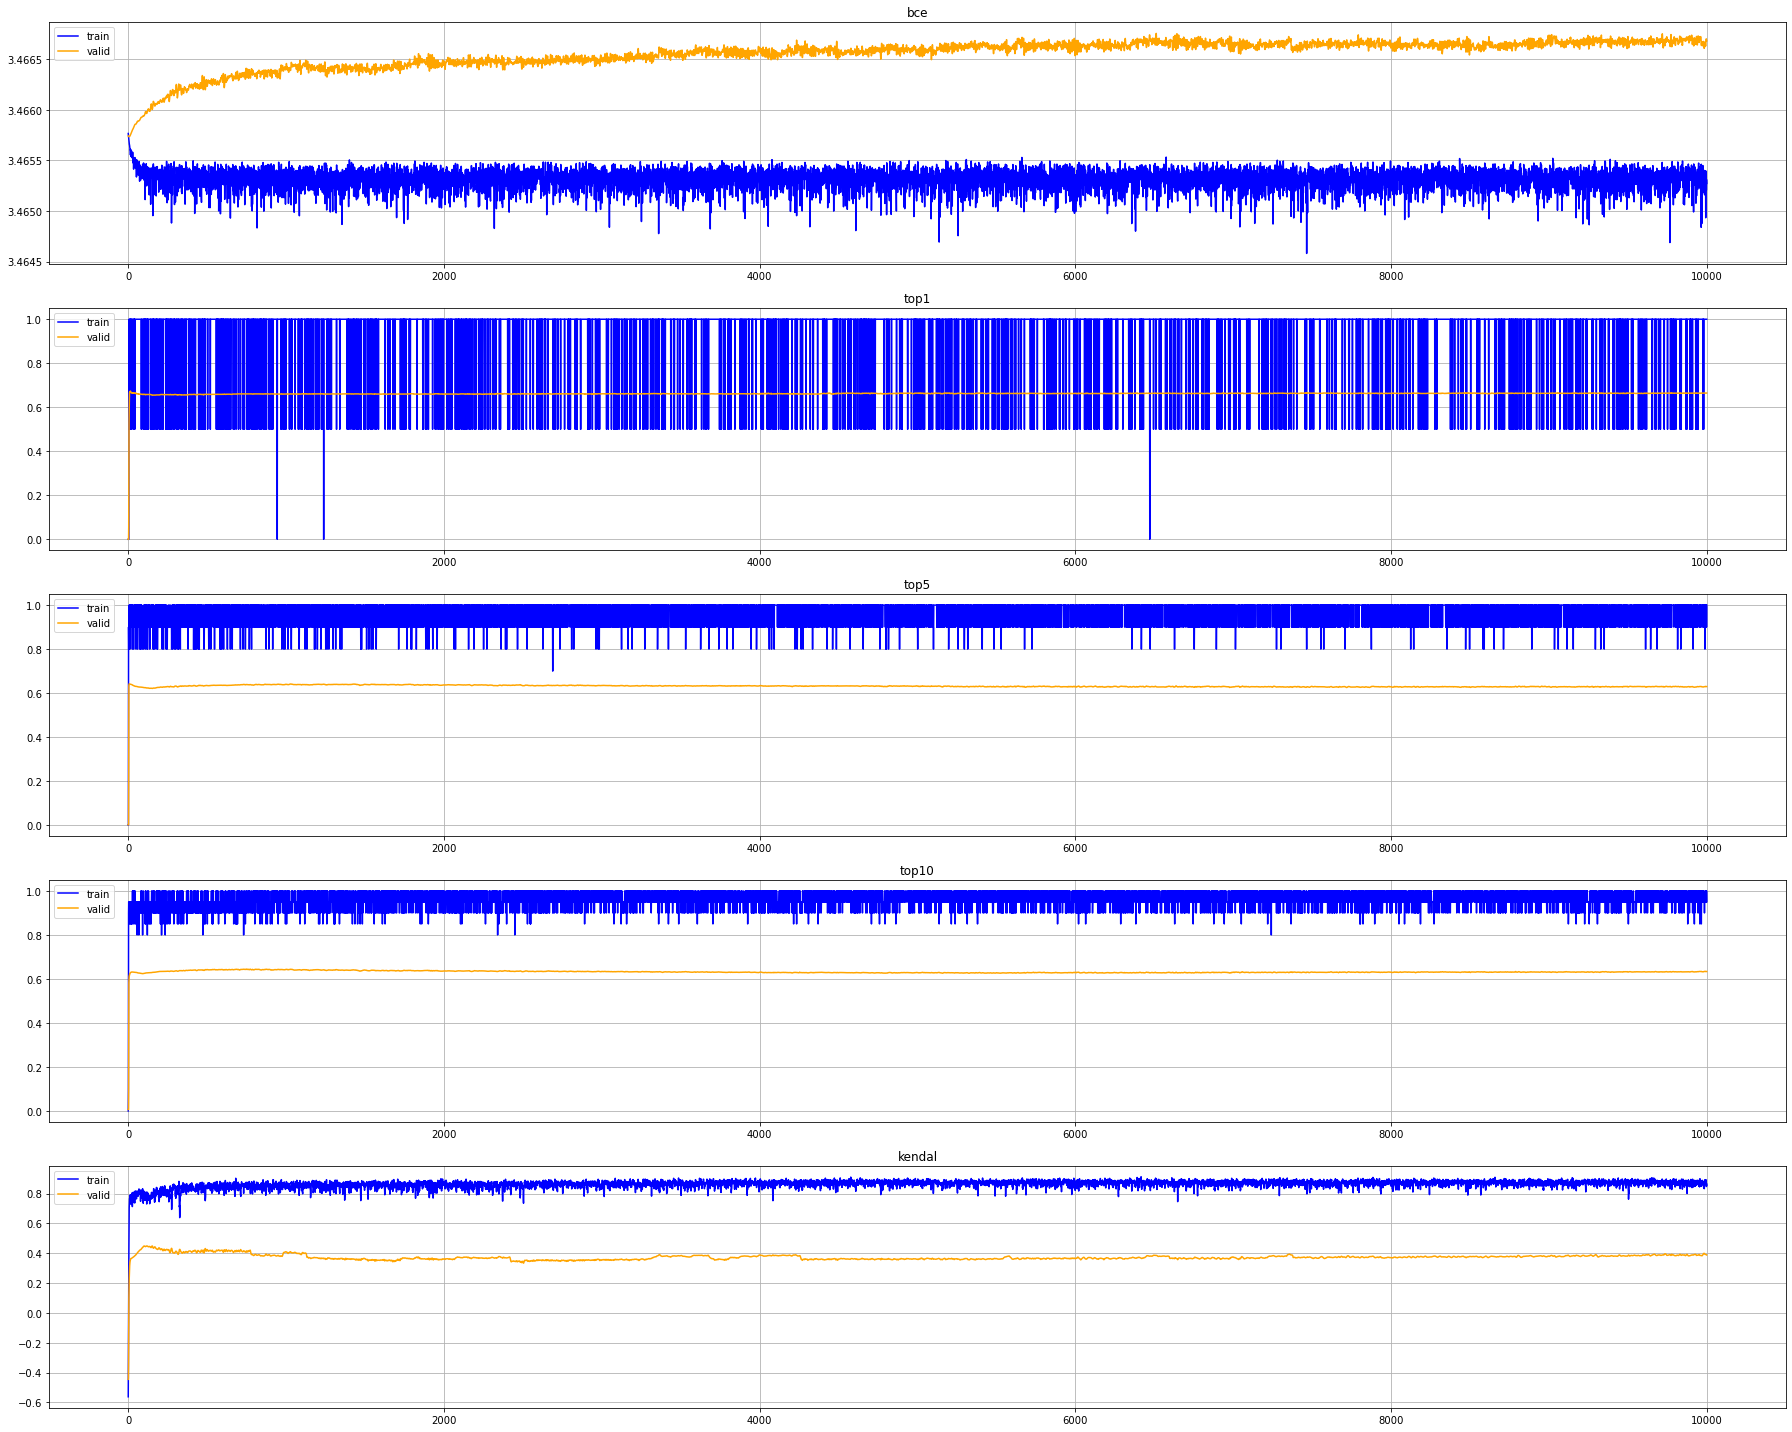

In [62]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    epochs = setting.epochs
    keys = list(train.keys())

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Baseline

In [ ]:
import networkit as nk

In [ ]:
G = nk.readGraph("/hw1_data/Synthetic/5000/0.txt", nk.Format.EdgeListTabZero)

## RK (DIAM)

### ApproxBetweenness

In [ ]:
ab = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
ab.run()

In [ ]:
# The 10 most central nodes according to betweenness are then 
ab.ranking()[:10]

## ARBA

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.ranking()[:10]

## K-BC (KPATH)

In [ ]:
kbc = nk.centrality.KPathCentrality(G, alpha=0.2, k=0)
kbc.run()

In [ ]:
kbc.ranking()[:10]